In [2]:
%matplotlib inline

import os, re, glob
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from tqdm import tqdm_notebook
from ast import literal_eval as make_tuple

sns.set_context('paper')

In [19]:
gsearch = lambda *args: glob.glob(opj(*args))
str_extract = lambda pattern, s: re.search(pattern, s).group(0)

In [4]:
data_dir = '../data/publicLifeLogData'
all_files = gsearch(data_dir, 'lifeLog*', '2*y.txt')
all_files.sort()
print(*all_files[:10], sep='\n')

../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_25_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_26_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_27_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_28_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver1.onehouronelife.com/2019_01January_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_01January_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_01January_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_01January_31_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_02February_01_Friday.txt


In [5]:
def date_extract(s):
    
    date_regex = '([0-9]{4})_([0-9]{2})[A-Za-z]+_([0-9]{2})'
    date_search = re.findall(date_regex, s)
    date_str = ''.join(date_search[0])
    date_int = int(date_str)
    
    return date_int

In [6]:
def find_version(file):
    file_date = date_extract(file)

    tmp_ver = ver.copy()
    tmp_ver['lag'] = file_date - tmp_ver['release_date']
    tmp_ver = tmp_ver[tmp_ver['lag'] >= 0]

    file_ver = tmp_ver.loc[tmp_ver['lag'].idxmin()].version
    
    return file_ver

In [43]:
ver_file = '../1_download/outputs/version_history_full.tsv'

# Load file
ver = pd.read_csv(ver_file, sep='\t')

# Clean up release date
ver.release_date = [s.replace('-', '') for s in ver.release_date]
ver.release_date = pd.to_numeric(ver.release_date)

In [7]:
all_dates = [date_extract(f) for f in all_files]
all_dates

[20190125,
 20190126,
 20190127,
 20190128,
 20190129,
 20190130,
 20190129,
 20190130,
 20190131,
 20190201,
 20190202,
 20190203,
 20190204,
 20190205,
 20190206,
 20190207,
 20190208,
 20190209,
 20190210,
 20190211,
 20190212,
 20190213,
 20190214,
 20190215,
 20190216,
 20190217,
 20190218,
 20190219,
 20190220,
 20190221,
 20190222,
 20190223,
 20190224,
 20190225,
 20190226,
 20190227,
 20190228,
 20190301,
 20190302,
 20190303,
 20190304,
 20190305,
 20190306,
 20190307,
 20190308,
 20190309,
 20190310,
 20190311,
 20190312,
 20190313,
 20190314,
 20190315,
 20190316,
 20190317,
 20190318,
 20190319,
 20190320,
 20190321,
 20190322,
 20190323,
 20190324,
 20190325,
 20190326,
 20190327,
 20190328,
 20190329,
 20190330,
 20190331,
 20190401,
 20190402,
 20190403,
 20190404,
 20190405,
 20190406,
 20190407,
 20190408,
 20190409,
 20190410,
 20190411,
 20190412,
 20190413,
 20190414,
 20190415,
 20190416,
 20190417,
 20190418,
 20190419,
 20190420,
 20190421,
 20190422,
 20190423,

In [122]:
start = 20190726

# Check if date is within range
between_dates = lambda d: (d >= start)

file_df = pd.DataFrame({'file': all_files,
                        'date': all_dates})
file_df['include'] = file_df.date.apply(between_dates)
file_df = file_df[file_df.include == True]

file_df.head()

,file,date,include
184,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190726,True
185,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190727,True
186,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190728,True
187,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190729,True
188,../data/publicLifeLogData/lifeLog_bigserver2.o...,20190730,True


In [123]:
from tqdm import tqdm
data_files = file_df['file'].values
data_files

array(['../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_26_Friday.txt',
       '../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_27_Saturday.txt',
       '../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_28_Sunday.txt',
       ...,
       '../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_06June_14_Sunday.txt',
       '../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_06June_15_Monday.txt',
       '../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_06June_16_Tuesday.txt'],
      dtype=object)

In [124]:
data_list = []
empty_files = []
for i in tqdm(range(len(data_files))):
    f = data_files[i]
    print(f)
# for f in data_files:
    try:
        tmp_server = str_extract('(?<=lifeLog_)[a-zA-Z0-9]+', f)
        tmp_ver = find_version(f)
        
        tmp_d = pd.read_csv(f, sep =' ', header=None)
        tmp_d.insert(0, 'server', tmp_server)
        tmp_d.insert(0, 'release', tmp_ver)
        data_list.append(tmp_d)

    except:
        empty_files.append(f)



  0%|          | 0/4654 [00:00<?, ?it/s]

  0%|          | 2/4654 [00:00<06:52, 11.28it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_26_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_28_Sunday.txt




  0%|          | 3/4654 [00:00<07:39, 10.12it/s]

  0%|          | 5/4654 [00:00<07:17, 10.61it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_07July_31_Wednesday.txt




  0%|          | 7/4654 [00:00<06:30, 11.91it/s]

  0%|          | 9/4654 [00:00<06:02, 12.81it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_04_Sunday.txt




  0%|          | 11/4654 [00:00<05:39, 13.66it/s]

  0%|          | 13/4654 [00:00<05:15, 14.72it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_08_Thursday.txt




  0%|          | 16/4654 [00:01<04:45, 16.25it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_13_Tuesday.txt




  0%|          | 19/4654 [00:01<04:22, 17.67it/s]

  0%|          | 22/4654 [00:01<03:57, 19.50it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_15_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_16_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_17_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_18_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_19_Monday.txt



  1%|          | 25/4654 [00:01<03:45, 20.56it/s]

  1%|          | 28/4654 [00:01<03:29, 22.07it/s]


../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_20_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_21_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_22_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_23_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_25_Sunday.txt




  1%|          | 31/4654 [00:01<03:32, 21.78it/s]

  1%|          | 34/4654 [00:01<03:54, 19.73it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_27_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_28_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_29_Thursday.txt




  1%|          | 37/4654 [00:02<03:42, 20.77it/s]

  1%|          | 40/4654 [00:02<03:31, 21.86it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_30_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_02_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_03_Tuesday.txt




  1%|          | 43/4654 [00:02<03:31, 21.79it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_08_Sunday.txt




  1%|          | 46/4654 [00:02<03:50, 19.96it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_12_Thursday.txt




  1%|          | 49/4654 [00:02<03:40, 20.86it/s]

  1%|          | 52/4654 [00:02<03:40, 20.85it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_13_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_14_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_15_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_16_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_17_Tuesday.txt




  1%|          | 56/4654 [00:02<03:18, 23.12it/s]

  1%|▏         | 59/4654 [00:02<03:12, 23.91it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_19_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_20_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_21_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_22_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_23_Monday.txt




  1%|▏         | 62/4654 [00:03<03:03, 25.03it/s]

  1%|▏         | 65/4654 [00:03<03:05, 24.72it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_26_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_27_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_28_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_29_Sunday.txt




  1%|▏         | 68/4654 [00:03<03:02, 25.18it/s]

  2%|▏         | 71/4654 [00:03<02:55, 26.05it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_09September_30_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_01_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_05_Saturday.txt




  2%|▏         | 74/4654 [00:03<02:57, 25.83it/s]

  2%|▏         | 77/4654 [00:03<02:53, 26.32it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_11_Friday.txt




  2%|▏         | 80/4654 [00:03<02:53, 26.42it/s]

  2%|▏         | 83/4654 [00:03<02:48, 27.13it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_13_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_14_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_15_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_16_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_17_Thursday.txt




  2%|▏         | 86/4654 [00:04<02:56, 25.86it/s]

  2%|▏         | 90/4654 [00:04<02:41, 28.22it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_18_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_19_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_20_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_21_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_22_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_23_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_24_Thursday.txt




  2%|▏         | 93/4654 [00:04<02:45, 27.61it/s]

  2%|▏         | 96/4654 [00:04<02:43, 27.93it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_25_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_26_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_27_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_30_Wednesday.txt




  2%|▏         | 99/4654 [00:04<02:41, 28.29it/s]

  2%|▏         | 103/4654 [00:04<02:34, 29.37it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_10October_31_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_04_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_06_Wednesday.txt




  2%|▏         | 107/4654 [00:04<02:30, 30.23it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_07_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_12_Tuesday.txt




  2%|▏         | 111/4654 [00:04<02:44, 27.58it/s]

  2%|▏         | 115/4654 [00:05<02:39, 28.42it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_14_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_15_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_19_Tuesday.txt



  3%|▎         | 118/4654 [00:05<03:04, 24.59it/s]


../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_21_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_22_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_23_Saturday.txt




  3%|▎         | 121/4654 [00:05<03:09, 23.86it/s]

  3%|▎         | 124/4654 [00:05<03:24, 22.18it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_24_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_25_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_28_Thursday.txt




  3%|▎         | 127/4654 [00:05<03:23, 22.30it/s]

  3%|▎         | 130/4654 [00:05<03:10, 23.73it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_11November_30_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_02_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_04_Wednesday.txt



  3%|▎         | 133/4654 [00:05<03:05, 24.39it/s]

  3%|▎         | 136/4654 [00:05<03:01, 24.83it/s]


../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_10_Tuesday.txt




  3%|▎         | 139/4654 [00:06<02:57, 25.41it/s]

  3%|▎         | 142/4654 [00:06<02:49, 26.61it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_16_Monday.txt




  3%|▎         | 145/4654 [00:06<02:57, 25.47it/s]

  3%|▎         | 148/4654 [00:06<02:54, 25.78it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_19_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_20_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_22_Sunday.txt




  3%|▎         | 151/4654 [00:06<02:53, 25.91it/s]

  3%|▎         | 154/4654 [00:06<02:50, 26.43it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_23_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_26_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_27_Friday.txt




  3%|▎         | 157/4654 [00:06<03:08, 23.89it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_28_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_29_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_30_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2019_12December_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_01_Wednesday.txt




  3%|▎         | 160/4654 [00:06<03:18, 22.65it/s]

  4%|▎         | 163/4654 [00:07<03:11, 23.40it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_02_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_03_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_04_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_05_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_06_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_07_Tuesday.txt




  4%|▎         | 166/4654 [00:07<03:06, 24.05it/s]

  4%|▎         | 169/4654 [00:07<02:56, 25.42it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_13_Monday.txt




  4%|▎         | 172/4654 [00:07<02:55, 25.47it/s]

  4%|▍         | 175/4654 [00:07<02:49, 26.43it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_19_Sunday.txt




  4%|▍         | 178/4654 [00:07<02:51, 26.09it/s]

  4%|▍         | 182/4654 [00:07<02:40, 27.88it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_23_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_24_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_25_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_26_Sunday.txt




  4%|▍         | 185/4654 [00:07<02:43, 27.32it/s]

  4%|▍         | 189/4654 [00:07<02:37, 28.30it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_27_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_28_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_29_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_30_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_01January_31_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_01_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_02_Sunday.txt




  4%|▍         | 192/4654 [00:08<02:37, 28.28it/s]

  4%|▍         | 195/4654 [00:08<02:39, 27.95it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_09_Sunday.txt



  4%|▍         | 199/4654 [00:08<02:35, 28.63it/s]

  4%|▍         | 203/4654 [00:08<02:30, 29.60it/s]


../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_15_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_16_Sunday.txt




  4%|▍         | 206/4654 [00:08<02:31, 29.40it/s]

  4%|▍         | 209/4654 [00:08<02:33, 28.97it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_17_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_18_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_19_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_20_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_21_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_22_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_23_Sunday.txt



  5%|▍         | 213/4654 [00:08<02:31, 29.28it/s]

  5%|▍         | 218/4654 [00:08<02:12, 33.42it/s]

  5%|▍         | 223/4654 [00:08<02:00, 36.82it/s]


../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_24_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_25_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_26_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_27_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_04_Wednesday.txt




  5%|▍         | 228/4654 [00:09<01:56, 37.92it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_09_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_12_Thursday.txt




  5%|▍         | 232/4654 [00:09<02:01, 36.29it/s]

  5%|▌         | 236/4654 [00:09<02:05, 35.09it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_16_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_19_Thursday.txt




  5%|▌         | 240/4654 [00:09<02:03, 35.60it/s]

  5%|▌         | 244/4654 [00:09<02:06, 34.93it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_22_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_26_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_27_Friday.txt




  5%|▌         | 248/4654 [00:09<02:18, 31.79it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_28_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_29_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_30_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_03March_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_02_Thursday.txt




  5%|▌         | 252/4654 [00:09<02:28, 29.58it/s]

  6%|▌         | 256/4654 [00:10<02:44, 26.71it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_04_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_07_Tuesday.txt




  6%|▌         | 259/4654 [00:10<03:02, 24.12it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_12_Sunday.txt




  6%|▌         | 262/4654 [00:10<03:07, 23.39it/s]

  6%|▌         | 265/4654 [00:10<03:24, 21.44it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_13_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_16_Thursday.txt




  6%|▌         | 268/4654 [00:10<03:38, 20.10it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_18_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_21_Tuesday.txt




  6%|▌         | 271/4654 [00:10<03:30, 20.77it/s]

  6%|▌         | 274/4654 [00:10<03:24, 21.40it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_23_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_24_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_25_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_26_Sunday.txt




  6%|▌         | 277/4654 [00:11<03:22, 21.60it/s]

  6%|▌         | 280/4654 [00:11<03:09, 23.04it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_27_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_28_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_29_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_04April_30_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_01_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_02_Saturday.txt




  6%|▌         | 283/4654 [00:11<03:03, 23.79it/s]

  6%|▌         | 286/4654 [00:11<03:04, 23.67it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_03_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_04_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_07_Thursday.txt




  6%|▌         | 289/4654 [00:11<03:03, 23.79it/s]

  6%|▋         | 292/4654 [00:11<03:01, 24.00it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_09_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_10_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_11_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_12_Tuesday.txt




  6%|▋         | 295/4654 [00:11<03:00, 24.08it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_18_Monday.txt




  6%|▋         | 298/4654 [00:11<02:57, 24.59it/s]

  6%|▋         | 302/4654 [00:12<02:41, 27.00it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_24_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_26_Tuesday.txt




  7%|▋         | 306/4654 [00:12<02:29, 29.03it/s]

  7%|▋         | 310/4654 [00:12<02:23, 30.35it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_28_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_29_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_01_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_02_Tuesday.txt




  7%|▋         | 314/4654 [00:12<02:27, 29.35it/s]

  7%|▋         | 318/4654 [00:12<02:31, 28.66it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_03_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_04_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_05_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_06_Saturday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_07_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_08_Monday.txt




  7%|▋         | 321/4654 [00:12<02:35, 27.84it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_09_Tuesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_10_Wednesday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_11_Thursday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_12_Friday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_13_Saturday.txt




  7%|▋         | 324/4654 [00:12<02:54, 24.85it/s]

  7%|▋         | 328/4654 [00:12<02:41, 26.79it/s]

../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_14_Sunday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_15_Monday.txt
../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_06June_16_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_07July_26_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLog



  7%|▋         | 336/4654 [00:13<02:09, 33.25it/s]

  7%|▋         | 345/4654 [00:13<01:46, 40.49it/s]


../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_13_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/



  8%|▊         | 355/4654 [00:13<01:28, 48.35it/s]

  8%|▊         | 362/4654 [00:13<01:20, 53.16it/s]

  8%|▊         | 372/4654 [00:13<01:10, 60.79it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_25_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_27_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_28_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_29_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_30_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_02_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_03_Tuesday.txt
.



  8%|▊         | 381/4654 [00:13<01:03, 66.94it/s]

  8%|▊         | 390/4654 [00:13<00:59, 72.09it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_16_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_20_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_23_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09September_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_09Se



  9%|▊         | 399/4654 [00:13<00:56, 75.46it/s]

  9%|▉         | 408/4654 [00:13<00:53, 79.16it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_16_Wednesday



  9%|▉         | 418/4654 [00:14<00:51, 82.98it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_25_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_26_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_27_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_10October_31_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_04_Monday.



  9%|▉         | 427/4654 [00:14<00:55, 75.62it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_14_Thursday.txt




  9%|▉         | 435/4654 [00:14<01:35, 44.11it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_15_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_22_Friday.txt



  9%|▉         | 442/4654 [00:14<02:13, 31.45it/s]


../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_25_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_27_Wednesday.txt




 10%|▉         | 447/4654 [00:15<02:20, 29.98it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_11November_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_02_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_03_Tuesday.txt




 10%|▉         | 452/4654 [00:15<02:20, 29.94it/s]

 10%|▉         | 459/4654 [00:15<01:57, 35.58it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_



 10%|▉         | 464/4654 [00:15<01:49, 38.21it/s]

 10%|█         | 477/4654 [00:15<01:26, 48.12it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_16_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_20_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_23_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2019_12December_2



 11%|█         | 489/4654 [00:15<01:11, 57.98it/s]

 11%|█         | 500/4654 [00:15<01:02, 66.44it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_13_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_01January_22_Wednesday.tx



 11%|█         | 512/4654 [00:15<00:54, 76.17it/s]

 11%|█▏        | 524/4654 [00:15<00:48, 84.89it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_02February



 12%|█▏        | 537/4654 [00:16<00:44, 91.99it/s]

 12%|█▏        | 548/4654 [00:16<00:46, 88.32it/s]


../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_09_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_16_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_17_Tuesday.txt
../data/publicLifeLo



 12%|█▏        | 558/4654 [00:16<01:04, 63.06it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_27_Friday.txt


../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_30_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_03March_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_04_Saturday.txt




 12%|█▏        | 567/4654 [00:16<01:26, 47.17it/s]

 12%|█▏        | 574/4654 [00:16<01:31, 44.75it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_15_Wednesday.txt




 12%|█▏        | 580/4654 [00:17<01:31, 44.57it/s]

 13%|█▎        | 587/4654 [00:17<01:21, 49.80it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_24_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_04April_26_Sunday.txt
../data/publicLifeLo



 13%|█▎        | 598/4654 [00:17<01:09, 58.55it/s]

 13%|█▎        | 610/4654 [00:17<00:59, 68.39it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_04_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_11_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.



 13%|█▎        | 620/4654 [00:17<00:53, 75.40it/s]

 14%|█▎        | 632/4654 [00:17<00:49, 81.14it/s]

../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_29_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_01_Monday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_02_Tuesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_03_Wednesday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_04_Thursday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_05_Friday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_06_Saturday.txt
../data/publicLifeLogData/lifeLog_server1.onehouronelife.com/2020_06June_07_Sunday.txt
../data/publicLifeLogData/lifeLog_s



 14%|█▍        | 642/4654 [00:17<01:08, 58.44it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_06_Tuesday.txt




 14%|█▍        | 651/4654 [00:18<01:02, 63.94it/s]

 14%|█▍        | 662/4654 [00:18<00:55, 72.57it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_13_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_17_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_18_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_19_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_20_Tuesday.tx



 15%|█▍        | 675/4654 [00:18<00:48, 82.59it/s]

 15%|█▍        | 691/4654 [00:18<00:41, 96.02it/s]


../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_30_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_02_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/201



 15%|█▌        | 705/4654 [00:18<00:37, 105.95it/s]

 15%|█▌        | 719/4654 [00:18<00:34, 113.50it/s]


../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_01_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10Octobe

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_10October_31_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_04_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11

 16%|█▌        | 732/4654 [00:18<00:44, 88.02it/s] 

 16%|█▌        | 743/4654 [00:18<00:44, 87.58it/s]

 16%|█▌        | 753/4654 [00:19<00:43, 90.66it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_1



 17%|█▋        | 768/4654 [00:19<00:38, 101.77it/s]

 17%|█▋        | 782/4654 [00:19<00:34, 110.85it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/201



 17%|█▋        | 796/4654 [00:19<00:32, 117.50it/s]

 17%|█▋        | 809/4654 [00:19<00:32, 118.81it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_06_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_01January



 18%|█▊        | 822/4654 [00:19<00:33, 113.48it/s]

 18%|█▊        | 834/4654 [00:19<00:33, 114.77it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020



 18%|█▊        | 847/4654 [00:19<00:32, 118.51it/s]

 18%|█▊        | 860/4654 [00:19<00:33, 112.81it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_10_Tuesday.txt
../d



 19%|█▉        | 873/4654 [00:19<00:32, 115.63it/s]

 19%|█▉        | 888/4654 [00:20<00:30, 123.54it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_27_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_30_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_03March_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_04April_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_04April_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_04April_04_Saturday.txt
../data



 19%|█▉        | 903/4654 [00:20<00:29, 129.09it/s]

 20%|█▉        | 918/4654 [00:20<00:28, 132.81it/s]

../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_11_Monday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server10.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_s



 20%|██        | 933/4654 [00:20<00:27, 135.33it/s]

 20%|██        | 948/4654 [00:20<00:26, 138.66it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_08August_12_Monday.txt




 21%|██        | 962/4654 [00:20<00:51, 71.14it/s] 

 21%|██        | 976/4654 [00:21<00:44, 83.39it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_16_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_20_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_23_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_09September_30_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/



 21%|██▏       | 990/4654 [00:21<00:38, 94.83it/s]

 22%|██▏       | 1003/4654 [00:21<00:35, 103.11it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_17_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_19_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_20_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_21_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_22_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_23_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_25_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_26_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_27_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_10October_29_



 22%|██▏       | 1016/4654 [00:21<00:33, 108.15it/s]

 22%|██▏       | 1031/4654 [00:21<00:30, 116.99it/s]


../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_25_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_11November_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_02_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12



 22%|██▏       | 1047/4654 [00:21<00:28, 125.49it/s]

 23%|██▎       | 1061/4654 [00:21<00:27, 128.68it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_30_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2019_12December_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_03_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01Jan



 23%|██▎       | 1075/4654 [00:21<00:27, 131.60it/s]

 23%|██▎       | 1090/4654 [00:21<00:26, 135.38it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_26_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_27_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_28_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_29_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_30_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_01January_31_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_01_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_02_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February



 24%|██▎       | 1105/4654 [00:21<00:25, 137.49it/s]

 24%|██▍       | 1120/4654 [00:22<00:25, 140.55it/s]


../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_25_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_26_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_27_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_07_Satur



 24%|██▍       | 1135/4654 [00:22<00:24, 142.05it/s]

 25%|██▍       | 1150/4654 [00:22<00:24, 141.14it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_30_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_03March_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_04April_09_Thursday.txt
../data



 25%|██▌       | 1165/4654 [00:22<00:24, 142.35it/s]

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_04_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/life



 25%|██▌       | 1180/4654 [00:22<00:30, 112.28it/s]

 26%|██▌       | 1193/4654 [00:22<00:35, 96.25it/s] 

../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_29_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_01_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_02_Tuesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_03_Wednesday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_04_Thursday.txt
../data/publicLifeLogData



 26%|██▌       | 1205/4654 [00:22<00:34, 101.05it/s]

 26%|██▌       | 1219/4654 [00:22<00:31, 109.66it/s]


../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_12_Friday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_13_Saturday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_14_Sunday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_15_Monday.txt
../data/publicLifeLogData/lifeLog_server11.onehouronelife.com/2020_06June_16_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_07July_26_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogD



 26%|██▋       | 1232/4654 [00:23<00:29, 114.51it/s]

 27%|██▋       | 1246/4654 [00:23<00:28, 120.28it/s]


../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_19_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_20_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_21_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_22_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_23_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_25_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_27_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_28_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_08August_29_Thursday



 27%|██▋       | 1259/4654 [00:23<00:30, 109.78it/s]

 27%|██▋       | 1271/4654 [00:23<00:33, 102.48it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_16_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_20_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_23_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_09September_27_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com



 28%|██▊       | 1286/4654 [00:23<00:30, 111.52it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_13_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_14_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_15_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_17_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_18_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_19_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_10October_2



 28%|██▊       | 1299/4654 [00:23<00:29, 115.21it/s]

 28%|██▊       | 1312/4654 [00:23<00:28, 118.60it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_11November_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_1



 28%|██▊       | 1325/4654 [00:23<00:30, 109.18it/s]

 29%|██▊       | 1337/4654 [00:24<00:33, 99.04it/s] 

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_16_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12D



 29%|██▉       | 1348/4654 [00:24<00:33, 99.46it/s]

 29%|██▉       | 1359/4654 [00:24<00:33, 98.83it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_23_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_27_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_30_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2019_12December_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01



 29%|██▉       | 1370/4654 [00:24<00:34, 95.99it/s]

 30%|██▉       | 1380/4654 [00:24<00:33, 96.65it/s]


../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01January_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_01Januar



 30%|██▉       | 1390/4654 [00:24<00:35, 93.17it/s]

 30%|███       | 1403/4654 [00:24<00:32, 100.86it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_0



 30%|███       | 1414/4654 [00:24<00:32, 99.78it/s] 

 31%|███       | 1425/4654 [00:24<00:32, 100.43it/s]


../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_26_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_27_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_07_Saturd



 31%|███       | 1436/4654 [00:25<00:31, 102.68it/s]

 31%|███       | 1447/4654 [00:25<00:31, 102.76it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_27_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_03March_28_Saturday.txt
../dat



 31%|███▏      | 1458/4654 [00:25<00:31, 101.31it/s]

 32%|███▏      | 1470/4654 [00:25<00:30, 104.70it/s]


../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_13_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_04April_22_Wednesday.txt
../data



 32%|███▏      | 1481/4654 [00:25<00:32, 98.63it/s] 

 32%|███▏      | 1492/4654 [00:25<00:31, 101.08it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lif



 32%|███▏      | 1503/4654 [00:25<00:31, 100.00it/s]

 33%|███▎      | 1514/4654 [00:25<00:31, 100.71it/s]

../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_05_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_06_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_07_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_08_Monday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_09_Tuesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_10_Wednesday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_11_Thursday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_12_Friday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_13_Saturday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_14_Sunday.txt
../data/publicLifeLogData/lifeLog_server12.onehouronelife.com/2020_06June_15_Monday.txt
../data/publicLifeLogD



 33%|███▎      | 1525/4654 [00:25<00:33, 93.67it/s] 

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_15_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_16_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_17_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_18_Sunday



 33%|███▎      | 1536/4654 [00:26<00:32, 96.24it/s]

 33%|███▎      | 1547/4654 [00:26<00:31, 98.48it/s]

 33%|███▎      | 1559/4654 [00:26<00:30, 102.85it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_28_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_29_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_02_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/20



 34%|███▍      | 1571/4654 [00:26<00:29, 106.07it/s]

 34%|███▍      | 1583/4654 [00:26<00:28, 107.84it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_01_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_13



 34%|███▍      | 1594/4654 [00:26<00:29, 105.19it/s]

 34%|███▍      | 1605/4654 [00:26<00:28, 106.54it/s]


../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_27_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_10October_31_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_04_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11Novemb



 35%|███▍      | 1617/4654 [00:26<00:27, 109.73it/s]

 35%|███▌      | 1630/4654 [00:26<00:26, 113.83it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_25_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_



 35%|███▌      | 1642/4654 [00:27<00:26, 112.63it/s]

 36%|███▌      | 1654/4654 [00:27<00:27, 110.25it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_27_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_30_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2019_12December_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_0



 36%|███▌      | 1666/4654 [00:27<00:27, 108.81it/s]



../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_24_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_01January_2

 36%|███▌      | 1677/4654 [00:27<00:30, 98.05it/s] 

 36%|███▋      | 1688/4654 [00:27<00:30, 97.26it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_15_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_17_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_18_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_02February_19_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_0



 37%|███▋      | 1699/4654 [00:27<00:29, 98.63it/s]

 37%|███▋      | 1710/4654 [00:27<00:29, 100.28it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_16_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_03March_22_Sunday.txt
../data/p



 37%|███▋      | 1721/4654 [00:27<00:29, 98.98it/s] 

 37%|███▋      | 1733/4654 [00:27<00:28, 103.94it/s]



../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_13_Monday.txt
../data/pub

 37%|███▋      | 1745/4654 [00:28<00:27, 107.01it/s]

 38%|███▊      | 1756/4654 [00:28<00:27, 107.08it/s]



../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_04April_30_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_01_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_04_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_11_Monday.txt
../data/publicLifeLogData/lifeL

 38%|███▊      | 1768/4654 [00:28<00:26, 107.43it/s]

 38%|███▊      | 1779/4654 [00:28<00:26, 107.32it/s]

../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_02_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_03_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_06_Saturday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_07_Sunday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_08_Monday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_09_Tuesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_10_Wednesday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_11_Thursday.txt
../data/publicLifeLogData/lifeLog_server13.onehouronelife.com/2020_06June_12_Friday.txt
../data/publicLifeLo



 38%|███▊      | 1790/4654 [00:28<00:27, 104.10it/s]

 39%|███▊      | 1802/4654 [00:28<00:26, 106.50it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_12_Monday.txt




 39%|███▉      | 1813/4654 [00:28<00:29, 96.28it/s] 

 39%|███▉      | 1823/4654 [00:28<00:29, 96.36it/s]


../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_23_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_25_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_27_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_28_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_29_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_30_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_02_Mond



 39%|███▉      | 1833/4654 [00:28<00:29, 96.10it/s]

 40%|███▉      | 1843/4654 [00:29<00:29, 94.34it/s]


../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_16_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_20_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_23_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_09September_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife



 40%|███▉      | 1854/4654 [00:29<00:28, 98.32it/s]

 40%|████      | 1866/4654 [00:29<00:27, 102.90it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_15_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_16_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_17_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_19_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10October_21_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_10Octob



 40%|████      | 1877/4654 [00:29<00:26, 104.23it/s]

 41%|████      | 1888/4654 [00:29<00:26, 103.14it/s]

 41%|████      | 1900/4654 [00:29<00:25, 106.90it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_15_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_



 41%|████      | 1911/4654 [00:29<00:26, 104.19it/s]

 41%|████▏     | 1922/4654 [00:29<00:25, 105.47it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_11November_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_02_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12D



 42%|████▏     | 1933/4654 [00:29<00:25, 105.08it/s]

 42%|████▏     | 1944/4654 [00:29<00:25, 106.42it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_23_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_27_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_30_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12D



 42%|████▏     | 1956/4654 [00:30<00:24, 108.60it/s]

 42%|████▏     | 1967/4654 [00:30<00:24, 108.46it/s]


../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_13_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_01January_



 43%|████▎     | 1978/4654 [00:30<00:25, 105.76it/s]

 43%|████▎     | 1989/4654 [00:30<00:25, 106.23it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_15_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_17_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_18_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_02February_19_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_0



 43%|████▎     | 2000/4654 [00:30<00:25, 105.06it/s]

 43%|████▎     | 2012/4654 [00:30<00:24, 107.13it/s]


../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_09_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_16_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_03March_21_Saturday.txt
../data/pub



 43%|████▎     | 2024/4654 [00:30<00:23, 109.63it/s]

 44%|████▎     | 2036/4654 [00:30<00:23, 111.83it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_13_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publ



 44%|████▍     | 2048/4654 [00:30<00:23, 109.40it/s]

 44%|████▍     | 2059/4654 [00:31<00:23, 109.21it/s]

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_29_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_04April_30_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_01_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_04_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_09_Saturday.txt
../data/publicLifeLogDat



 44%|████▍     | 2070/4654 [00:31<00:24, 106.82it/s]

 45%|████▍     | 2081/4654 [00:31<00:23, 107.39it/s]


../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_29_Friday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2020_06June_01_Monday.txt
../data/publicLifeLogData/lifeL



 45%|████▍     | 2092/4654 [00:31<00:23, 107.26it/s]

 45%|████▌     | 2103/4654 [00:31<00:24, 104.27it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_07July_26_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_05_Monday.txt
../data/publ



 45%|████▌     | 2114/4654 [00:31<00:24, 103.42it/s]

 46%|████▌     | 2126/4654 [00:31<00:23, 106.70it/s]


../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_17_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_18_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_19_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_20_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_21_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_22_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_23_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_25_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_08August_27_Tuesday.tx



 46%|████▌     | 2137/4654 [00:31<00:23, 105.94it/s]

 46%|████▌     | 2148/4654 [00:31<00:23, 106.34it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_13_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_16_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.



 46%|████▋     | 2159/4654 [00:31<00:23, 106.03it/s]

 47%|████▋     | 2171/4654 [00:32<00:22, 109.14it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_



 47%|████▋     | 2182/4654 [00:32<00:23, 107.21it/s]

 47%|████▋     | 2193/4654 [00:32<00:22, 107.44it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_27_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_10October_31_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_04_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11Novembe



 47%|████▋     | 2205/4654 [00:32<00:22, 108.85it/s]

 48%|████▊     | 2217/4654 [00:32<00:22, 110.74it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_22_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_25_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_11November_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_1



 48%|████▊     | 2229/4654 [00:32<00:21, 112.89it/s]

 48%|████▊     | 2241/4654 [00:32<00:21, 113.07it/s]


../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_16_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_20_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12December_23_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2019_12



 48%|████▊     | 2253/4654 [00:32<00:21, 112.90it/s]

 49%|████▊     | 2265/4654 [00:32<00:21, 112.82it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_13_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_01January



 49%|████▉     | 2277/4654 [00:33<00:20, 113.78it/s]

 49%|████▉     | 2289/4654 [00:33<00:21, 110.82it/s]


../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_02_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02F



 49%|████▉     | 2301/4654 [00:33<00:20, 113.41it/s]

 50%|████▉     | 2313/4654 [00:33<00:21, 110.76it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_09_Monday.txt
../da



 50%|████▉     | 2325/4654 [00:33<00:20, 112.62it/s]

 50%|█████     | 2338/4654 [00:33<00:20, 115.55it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_27_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_30_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_03March_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_02_Thursday.txt
../data



 51%|█████     | 2351/4654 [00:33<00:19, 119.38it/s]

 51%|█████     | 2365/4654 [00:33<00:18, 124.00it/s]


../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_24_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_26_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_27_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_28_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_04April_29_Wednesday.txt
../data/



 51%|█████     | 2380/4654 [00:33<00:17, 128.32it/s]

 51%|█████▏    | 2394/4654 [00:33<00:17, 130.77it/s]

../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_29_Friday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server15.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeL



 52%|█████▏    | 2408/4654 [00:34<00:17, 130.27it/s]

 52%|█████▏    | 2422/4654 [00:34<00:17, 130.28it/s]


../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicL



 52%|█████▏    | 2436/4654 [00:34<00:17, 128.53it/s]

 53%|█████▎    | 2449/4654 [00:34<00:17, 127.37it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_02_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09September_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_09Septem



 53%|█████▎    | 2463/4654 [00:34<00:16, 129.23it/s]

 53%|█████▎    | 2477/4654 [00:34<00:16, 130.54it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_01_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_10October_11_Friday.



 54%|█████▎    | 2491/4654 [00:34<00:16, 132.75it/s]

 54%|█████▍    | 2505/4654 [00:34<00:16, 131.79it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_04_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_11November_18_M



 54%|█████▍    | 2519/4654 [00:34<00:16, 132.52it/s]

 54%|█████▍    | 2533/4654 [00:35<00:15, 133.59it/s]

 55%|█████▍    | 2548/4654 [00:35<00:15, 135.56it/s]


../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2019_12December_16



 55%|█████▌    | 2562/4654 [00:35<00:15, 136.16it/s]

 55%|█████▌    | 2576/4654 [00:35<00:15, 137.20it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_06_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_13_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_01January_16_Thursday.



 56%|█████▌    | 2590/4654 [00:35<00:15, 134.30it/s]

 56%|█████▌    | 2605/4654 [00:35<00:14, 136.70it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_15_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_02February_1



 56%|█████▋    | 2619/4654 [00:35<00:15, 134.70it/s]

 57%|█████▋    | 2633/4654 [00:35<00:14, 135.82it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_16_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLife



 57%|█████▋    | 2647/4654 [00:35<00:14, 134.20it/s]

 57%|█████▋    | 2661/4654 [00:35<00:14, 133.80it/s]

../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_24_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_26_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_04April_29_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_01_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/



 57%|█████▋    | 2675/4654 [00:36<00:14, 132.48it/s]

 58%|█████▊    | 2689/4654 [00:36<00:15, 128.54it/s]


../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_28_Thursday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_29_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_06June_02_Tuesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_06June_03_Wednesday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_06June_05_Friday.txt
../data/publicLifeLogData/lifeLog_server2.onehouronelife.com/2020_06June_07_Sunday.txt
../data/publicLifeLogData/lifeLog_ser



 58%|█████▊    | 2702/4654 [00:36<00:15, 125.95it/s]

 58%|█████▊    | 2716/4654 [00:36<00:15, 129.02it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_13_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_08August_15_Thursday.txt
../data



 59%|█████▊    | 2729/4654 [00:36<00:15, 127.82it/s]

 59%|█████▉    | 2743/4654 [00:36<00:14, 129.23it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_09September_13_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_0



 59%|█████▉    | 2756/4654 [00:36<00:14, 127.39it/s]

 60%|█████▉    | 2770/4654 [00:36<00:14, 130.88it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_10October_12_Saturday



 60%|█████▉    | 2784/4654 [00:36<00:14, 132.36it/s]

 60%|██████    | 2800/4654 [00:37<00:13, 138.33it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_04_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_11November_12_Tu



 60%|██████    | 2814/4654 [00:37<00:13, 138.07it/s]

 61%|██████    | 2829/4654 [00:37<00:13, 139.97it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_16_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_20_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2019_12December_23



 61%|██████    | 2844/4654 [00:37<00:13, 137.30it/s]

 61%|██████▏   | 2860/4654 [00:37<00:12, 142.36it/s]


../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_24_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_01January_26_Sunday.tx



 62%|██████▏   | 2875/4654 [00:37<00:12, 140.46it/s]

 62%|██████▏   | 2890/4654 [00:37<00:12, 140.74it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_09_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_03March_12_Thursday.txt
../data/publicLi



 62%|██████▏   | 2905/4654 [00:37<00:12, 138.08it/s]

 63%|██████▎   | 2921/4654 [00:37<00:12, 142.37it/s]


../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLif



 63%|██████▎   | 2936/4654 [00:37<00:12, 137.36it/s]

 63%|██████▎   | 2950/4654 [00:38<00:12, 138.03it/s]

../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server3.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server



 64%|██████▎   | 2964/4654 [00:38<00:12, 136.52it/s]

 64%|██████▍   | 2978/4654 [00:38<00:12, 134.89it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLi



 64%|██████▍   | 2992/4654 [00:38<00:12, 135.65it/s]

 65%|██████▍   | 3006/4654 [00:38<00:12, 135.23it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_13_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09September_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_09S



 65%|██████▍   | 3020/4654 [00:38<00:12, 128.41it/s]

 65%|██████▌   | 3033/4654 [00:38<00:12, 127.88it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_13_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_14_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_15_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_16_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_17_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_18_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_10October_19_Saturday.txt



 65%|██████▌   | 3046/4654 [00:38<00:12, 126.54it/s]

 66%|██████▌   | 3059/4654 [00:38<00:12, 123.94it/s]


../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_11Novemb



 66%|██████▌   | 3072/4654 [00:39<00:12, 125.18it/s]

 66%|██████▋   | 3085/4654 [00:39<00:12, 123.73it/s]


../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_20_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2019_12December



 67%|██████▋   | 3098/4654 [00:39<00:12, 120.42it/s]

 67%|██████▋   | 3111/4654 [00:39<00:12, 120.87it/s]


../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_24_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_01January_25_Saturda



 67%|██████▋   | 3124/4654 [00:39<00:12, 120.78it/s]

 67%|██████▋   | 3139/4654 [00:39<00:11, 127.63it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_15_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_16_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_17_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_18_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_19_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February_20_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_02February



 68%|██████▊   | 3152/4654 [00:39<00:13, 109.30it/s]

 68%|██████▊   | 3167/4654 [00:39<00:12, 117.84it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeL



 68%|██████▊   | 3181/4654 [00:39<00:12, 122.34it/s]

 69%|██████▊   | 3194/4654 [00:40<00:12, 120.25it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_13_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeL



 69%|██████▉   | 3207/4654 [00:40<00:11, 120.83it/s]

../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_11_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server



 69%|██████▉   | 3220/4654 [00:40<00:12, 114.30it/s]

 69%|██████▉   | 3233/4654 [00:40<00:12, 117.39it/s]


../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_01_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_02_Tuesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_03_Wednesday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_04_Thursday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_05_Friday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_06_Saturday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_07_Sunday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_08_Monday.txt
../data/publicLifeLogData/lifeLog_server4.onehouronelife.com/2020_06June_09_Tuesday.txt
../data/publicLifeLogData/lifeLog



 70%|██████▉   | 3247/4654 [00:40<00:11, 122.45it/s]

 70%|███████   | 3261/4654 [00:40<00:11, 125.43it/s]

../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_13_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_08August_15_Thursday.txt
../data



 70%|███████   | 3276/4654 [00:40<00:10, 131.62it/s]

 71%|███████   | 3290/4654 [00:40<00:10, 132.33it/s]

 71%|███████   | 3304/4654 [00:40<00:10, 134.18it/s]


../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_13_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_20_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_23_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_09September_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019



 71%|███████▏  | 3318/4654 [00:41<00:09, 135.49it/s]

 72%|███████▏  | 3332/4654 [00:41<00:09, 136.09it/s]


../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_18_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_19_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_20_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_22_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_23_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_24_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_25_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_26_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_10October_31_Thursda



 72%|███████▏  | 3346/4654 [00:41<00:09, 134.40it/s]

 72%|███████▏  | 3361/4654 [00:41<00:09, 137.48it/s]


../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_11November_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_02_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2019_12December_09



 73%|███████▎  | 3375/4654 [00:41<00:09, 135.73it/s]

 73%|███████▎  | 3389/4654 [00:41<00:09, 136.21it/s]

../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_03_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_06_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_01January_12_Sunday.tx



 73%|███████▎  | 3403/4654 [00:41<00:09, 135.72it/s]

 73%|███████▎  | 3418/4654 [00:41<00:09, 137.22it/s]


../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_01_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_02_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_02February_11



 74%|███████▎  | 3432/4654 [00:41<00:08, 136.77it/s]

 74%|███████▍  | 3446/4654 [00:41<00:08, 136.85it/s]

../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_09_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_13_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_03March_15_Sunday.txt
../data/publicLifeLo



 74%|███████▍  | 3460/4654 [00:42<00:08, 136.83it/s]

 75%|███████▍  | 3475/4654 [00:42<00:08, 139.15it/s]

../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeL



 75%|███████▍  | 3489/4654 [00:42<00:08, 138.23it/s]

 75%|███████▌  | 3505/4654 [00:42<00:08, 141.41it/s]

../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_05May_31_Sunday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_06June_01_Monday.txt
../data/publicLifeLogData/lifeLog_server5.onehouronelife.com/2020_06June_04_Thursday.txt
../data/publicLifeLogData/lifeLog_serv



 76%|███████▌  | 3520/4654 [00:42<00:08, 136.82it/s]

 76%|███████▌  | 3534/4654 [00:42<00:08, 135.91it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_10_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_11_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_12_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_13_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_14_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_08August_15_Thursday.txt
../data/pu



 76%|███████▌  | 3548/4654 [00:42<00:08, 132.32it/s]

 77%|███████▋  | 3564/4654 [00:42<00:07, 138.04it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_13_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_09September_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019



 77%|███████▋  | 3578/4654 [00:42<00:07, 137.89it/s]

 77%|███████▋  | 3592/4654 [00:43<00:07, 135.73it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_14_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_15_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_16_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_10October_17_Thursda



 77%|███████▋  | 3606/4654 [00:43<00:07, 135.13it/s]

 78%|███████▊  | 3620/4654 [00:43<00:07, 134.90it/s]


../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_22_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_11November_2



 78%|███████▊  | 3634/4654 [00:43<00:07, 132.74it/s]

 78%|███████▊  | 3648/4654 [00:43<00:07, 131.38it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_16_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_23_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12December_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2019_12Decembe



 79%|███████▊  | 3662/4654 [00:43<00:07, 131.23it/s]

 79%|███████▉  | 3676/4654 [00:43<00:07, 133.02it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_20_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_24_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_26_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_27_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_28_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_01January_29_Wednesday.



 79%|███████▉  | 3690/4654 [00:43<00:07, 133.31it/s]

 80%|███████▉  | 3706/4654 [00:43<00:06, 138.70it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_02February_25_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_02February_26_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_02February_27_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_03March_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_03March_07_Saturday.txt
../



 80%|███████▉  | 3720/4654 [00:43<00:06, 137.64it/s]

 80%|████████  | 3734/4654 [00:44<00:06, 136.09it/s]

../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_04April_16_Thursday.txt
../data/publicLifeL



 81%|████████  | 3748/4654 [00:44<00:06, 134.72it/s]

 81%|████████  | 3764/4654 [00:44<00:06, 139.65it/s]


../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server6.onehouronelife.com/2020_05May_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server6



 81%|████████  | 3779/4654 [00:44<00:06, 136.75it/s]

 81%|████████▏ | 3793/4654 [00:44<00:06, 136.44it/s]

../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_07_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_08_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_09_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_10_Saturday.txt
../data/



 82%|████████▏ | 3807/4654 [00:44<00:07, 110.60it/s]

 82%|████████▏ | 3822/4654 [00:44<00:06, 119.73it/s]

../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_02_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09September_09_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_09Septe



 82%|████████▏ | 3836/4654 [00:44<00:06, 124.28it/s]

 83%|████████▎ | 3851/4654 [00:44<00:06, 130.09it/s]

../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_06_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_07_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_08_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_10October_12_Saturday



 83%|████████▎ | 3865/4654 [00:45<00:06, 130.67it/s]

 83%|████████▎ | 3879/4654 [00:45<00:05, 131.87it/s]

../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_08_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_09_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_10_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_11_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_15_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_11November_18_



 84%|████████▎ | 3893/4654 [00:45<00:05, 130.65it/s]

 84%|████████▍ | 3908/4654 [00:45<00:05, 134.19it/s]

../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_09_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2019_12December_16_



 84%|████████▍ | 3922/4654 [00:45<00:05, 129.43it/s]

 85%|████████▍ | 3936/4654 [00:45<00:05, 130.33it/s]

../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_06_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_13_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_15_Wednesday.tx



 85%|████████▍ | 3950/4654 [00:45<00:05, 129.28it/s]

 85%|████████▌ | 3965/4654 [00:45<00:05, 132.66it/s]


../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_01January_31_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_01_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_02_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_03_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_04_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_05_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_06_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_10_



 85%|████████▌ | 3979/4654 [00:45<00:05, 130.38it/s]

 86%|████████▌ | 3994/4654 [00:46<00:04, 133.99it/s]


../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_02_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_06_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_09_Monday.txt
../data/publicL



 86%|████████▌ | 4008/4654 [00:46<00:04, 131.83it/s]

 86%|████████▋ | 4022/4654 [00:46<00:04, 133.16it/s]


../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_03March_30_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_03_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_06_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_07_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_08_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_04April_10_Friday.txt
../data/publicLifeLog



 87%|████████▋ | 4036/4654 [00:46<00:04, 133.08it/s]

 87%|████████▋ | 4051/4654 [00:46<00:04, 136.74it/s]


../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_04_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_08_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server7.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server7.



 87%|████████▋ | 4065/4654 [00:46<00:04, 134.77it/s]

 88%|████████▊ | 4079/4654 [00:46<00:04, 134.55it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_01_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_02_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_03_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_04_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_05_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_06_Tuesday.txt
../data/publicLifeLo



 88%|████████▊ | 4093/4654 [00:46<00:04, 134.34it/s]

 88%|████████▊ | 4107/4654 [00:46<00:04, 135.69it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_23_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_29_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_30_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_08August_31_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_09September_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_09September_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_09September_06_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_09September_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_09September_09_Monday.tx



 89%|████████▊ | 4121/4654 [00:47<00:04, 132.27it/s]

 89%|████████▉ | 4135/4654 [00:47<00:03, 134.30it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_10_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_11_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_12_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_13_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_14_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_15_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_16_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_17_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_18_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_10October_19_Saturday



 89%|████████▉ | 4149/4654 [00:47<00:03, 132.61it/s]

 89%|████████▉ | 4164/4654 [00:47<00:03, 135.15it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_12_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_13_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_14_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_15_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_18_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_11November



 90%|████████▉ | 4178/4654 [00:47<00:03, 133.87it/s]

 90%|█████████ | 4193/4654 [00:47<00:03, 136.25it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_10_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_11_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_12_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_13_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_14_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_15_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_16_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_20_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2019_12December_21



 90%|█████████ | 4207/4654 [00:47<00:03, 134.19it/s]

 91%|█████████ | 4221/4654 [00:47<00:03, 135.67it/s]


../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_09_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_10_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_11_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_12_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_13_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_17_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_01January_20_Monday.txt



 91%|█████████ | 4235/4654 [00:47<00:03, 135.25it/s]

 91%|█████████▏| 4250/4654 [00:47<00:02, 137.36it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_07_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_08_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_09_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_10_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_11_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_12_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_13_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_14_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_15_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_16_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_02February_17_



 92%|█████████▏| 4264/4654 [00:48<00:02, 137.87it/s]

 92%|█████████▏| 4278/4654 [00:48<00:02, 136.85it/s]


../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_16_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_17_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_03March_26_Thursday.txt
../data/publicLif



 92%|█████████▏| 4292/4654 [00:48<00:02, 135.09it/s]

 93%|█████████▎| 4306/4654 [00:48<00:02, 136.27it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_14_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_04April_24_Friday.txt
../data/publicLife



 93%|█████████▎| 4320/4654 [00:48<00:02, 133.85it/s]

 93%|█████████▎| 4334/4654 [00:48<00:02, 133.71it/s]


../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_15_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_16_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_server8.o



 93%|█████████▎| 4348/4654 [00:48<00:02, 132.66it/s]

 94%|█████████▎| 4362/4654 [00:48<00:02, 132.93it/s]

../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_06June_12_Friday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_06June_13_Saturday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_06June_14_Sunday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_06June_15_Monday.txt
../data/publicLifeLogData/lifeLog_server8.onehouronelife.com/2020_06June_16_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_07July_26_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_07July_27_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_07July_28_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_07July_29_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_07July_30_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_07July_31_Wednesday.txt
../data/publicLifeLogData/lifeLog_



 94%|█████████▍| 4376/4654 [00:48<00:02, 131.22it/s]

 94%|█████████▍| 4391/4654 [00:49<00:01, 134.92it/s]

../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_18_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_19_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_20_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_21_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_22_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_23_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_24_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_25_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_26_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_28_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_08August_29_Thursday.txt
../data/



 95%|█████████▍| 4405/4654 [00:49<00:01, 135.79it/s]

 95%|█████████▍| 4419/4654 [00:49<00:01, 136.51it/s]


../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_09September_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_09September_27_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_09September_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_09September_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_09September_30_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_01_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_02_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_03_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_04_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_05_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_0



 95%|█████████▌| 4433/4654 [00:49<00:01, 135.45it/s]

 96%|█████████▌| 4448/4654 [00:49<00:01, 138.52it/s]


../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_28_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_29_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_30_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_10October_31_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_01_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_02_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_03_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_05_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_06_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_07_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_08



 96%|█████████▌| 4462/4654 [00:49<00:01, 136.56it/s]

 96%|█████████▌| 4477/4654 [00:49<00:01, 138.33it/s]


../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_29_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_11November_30_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_02_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_03_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_04_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_06_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_07_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_08_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_09



 96%|█████████▋| 4491/4654 [00:49<00:01, 133.26it/s]

 97%|█████████▋| 4505/4654 [00:49<00:01, 132.93it/s]

../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_28_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_29_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_30_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2019_12December_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_01_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_02_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_03_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_05_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_06_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_07_Tuesday



 97%|█████████▋| 4519/4654 [00:49<00:01, 131.66it/s]

 97%|█████████▋| 4533/4654 [00:50<00:00, 132.20it/s]

../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_24_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_25_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_26_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_27_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_28_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_29_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_30_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_01January_31_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_01_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_02_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_03_Monday.t



 98%|█████████▊| 4547/4654 [00:50<00:00, 131.55it/s]

 98%|█████████▊| 4561/4654 [00:50<00:00, 131.35it/s]

../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_20_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_22_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_23_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_24_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_25_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_26_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_27_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_28_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_02February_29_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_01_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_02_Mond



 98%|█████████▊| 4575/4654 [00:50<00:00, 125.08it/s]

 99%|█████████▊| 4589/4654 [00:50<00:00, 127.26it/s]


../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_18_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_19_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_20_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_21_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_22_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_23_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_24_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_26_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_27_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_03March_28_Saturday.txt
../data/publicLi



 99%|█████████▉| 4602/4654 [00:50<00:00, 125.19it/s]

 99%|█████████▉| 4616/4654 [00:50<00:00, 129.05it/s]


../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_15_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_16_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_17_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_18_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_19_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_20_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_21_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_22_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_23_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_24_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_04April_26_Sunday.txt
../data/publicLife



 99%|█████████▉| 4629/4654 [00:50<00:00, 126.64it/s]

100%|█████████▉| 4643/4654 [00:50<00:00, 128.72it/s]

../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_17_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_18_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_19_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_20_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_21_Thursday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_22_Friday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_23_Saturday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_24_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_25_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_26_Tuesday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_05May_27_Wednesday.txt
../data/publicLifeLogData/lifeLog_server9.

100%|██████████| 4654/4654 [00:51<00:00, 91.21it/s] 


../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_06June_14_Sunday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_06June_15_Monday.txt
../data/publicLifeLogData/lifeLog_server9.onehouronelife.com/2020_06June_16_Tuesday.txt


In [303]:
raw_data = pd.concat(data_list)
raw_data.columns = ['release', 'server', 'event', 'timestamp', 'playerID', 'uniqueID', 'param1', 'param2',
                 'param3', 'param4', 'param5']
raw_data.head()

,release,server,event,timestamp,playerID,uniqueID,param1,param2,param3,param4,param5
0,251,bigserver2,D,1564099205,1806575,91f6003fa6a03933f72b1f95a7002f1f07928deb,age=33.40,M,"(277,-2434)",hunger,pop=67
1,251,bigserver2,D,1564099220,1806488,1a7f24be09f45519e96d4f017b36ad38eb5e329d,age=60.00,M,"(-2516,-1279)",oldAge,pop=66
2,251,bigserver2,D,1564099234,1806629,3dc579b91219e519dfee2f9d7a24aec8e9a83b03,age=19.04,F,"(-1919,-2078)",hunger,pop=65
3,251,bigserver2,D,1564099254,1806530,780359de9275c29b15b65d3cdba5b22bf90169c5,age=47.75,F,"(-2525,-1276)",hunger,pop=64
4,251,bigserver2,D,1564099256,1806662,bcc9ac263a4036f0141ffb04e9224e00443bb791,age=10.92,F,"(277,-2433)",hunger,pop=64


In [304]:
birth_data = raw_data[raw_data['event'] == 'B'].copy()
birth_data = birth_data[['release','server', 'playerID', 'uniqueID', 'param2','param5']]
birth_data = birth_data.rename({'param2': 'birth_location','param5': 'chain'}, axis='columns')
birth_data.head()

,release,server,playerID,uniqueID,birth_location,chain
6,251,bigserver2,1806690,610232431bd719fc6ae03c734f0f2569a659d59b,"(-1933,-2118)",chain=45
9,251,bigserver2,1806691,14a34de5ef24a092c09f2f726904939a8b7fbd1f,"(-1802,-719)",chain=5
10,251,bigserver2,1806692,207e9318d08219318f00fd32e483251f81247dc8,"(-2432,-4839)",chain=10
11,251,bigserver2,1806693,52c80bc1fa937e1eceb41ba28610da4c0da196f2,"(-1930,-2023)",chain=44
12,251,bigserver2,1806694,265223909fa4f36f07a340f020cafdb74d91615e,"(-2519,-1282)",chain=21


In [306]:
death_data = raw_data[raw_data['event'] == 'D'].copy()
death_data = death_data[['release','server', 'playerID', 'uniqueID', 'param3']]
death_data = death_data.rename({'param3': 'death_location'}, axis='columns')
death_data.head()


,release,server,playerID,uniqueID,death_location
0,251,bigserver2,1806575,91f6003fa6a03933f72b1f95a7002f1f07928deb,"(277,-2434)"
1,251,bigserver2,1806488,1a7f24be09f45519e96d4f017b36ad38eb5e329d,"(-2516,-1279)"
2,251,bigserver2,1806629,3dc579b91219e519dfee2f9d7a24aec8e9a83b03,"(-1919,-2078)"
3,251,bigserver2,1806530,780359de9275c29b15b65d3cdba5b22bf90169c5,"(-2525,-1276)"
4,251,bigserver2,1806662,bcc9ac263a4036f0141ffb04e9224e00443bb791,"(277,-2433)"


In [308]:
loc_data = birth_data.merge(death_data, on = ['release','server','playerID','uniqueID'])
loc_data['birth'] = loc_data['birth_location'].apply(make_tuple).apply(np.array)
loc_data['death'] = loc_data['death_location'].apply(make_tuple).apply(np.array)

# Split coordinates (for easier plotting)
loc_data[['birthX', 'birthY']] = pd.DataFrame(loc_data['birth'].tolist(),
                                              index=loc_data.index)   
loc_data[['deathX', 'deathY']] = pd.DataFrame(loc_data['death'].tolist(),
                                              index=loc_data.index)

lifeLog = loc_data[['release','server','playerID','uniqueID','birthX','birthY','deathX','deathY','chain']]


lifeLog.head()

,release,server,playerID,uniqueID,birthX,birthY,deathX,deathY,chain
0,251,bigserver2,1806690,610232431bd719fc6ae03c734f0f2569a659d59b,-1933,-2118,-1950,-2089,chain=45
1,251,bigserver2,1806691,14a34de5ef24a092c09f2f726904939a8b7fbd1f,-1802,-719,-1825,-549,chain=5
2,251,bigserver2,1806692,207e9318d08219318f00fd32e483251f81247dc8,-2432,-4839,-2426,-4832,chain=10
3,251,bigserver2,1806693,52c80bc1fa937e1eceb41ba28610da4c0da196f2,-1930,-2023,-1946,-2557,chain=44
4,251,bigserver2,1806694,265223909fa4f36f07a340f020cafdb74d91615e,-2519,-1282,-2518,-1348,chain=21


In [309]:
# turn str under chain into num
digit = lambda x: int(x.split("=")[1])
lifeLog['num_chain'] = lifeLog['chain'].apply(digit)
lifeLogNew = lifeLog.drop(['chain'], axis=1)
lifeLogNew

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,release,server,playerID,uniqueID,birthX,birthY,deathX,deathY,num_chain
0,251,bigserver2,1806690,610232431bd719fc6ae03c734f0f2569a659d59b,-1933,-2118,-1950,-2089,45
1,251,bigserver2,1806691,14a34de5ef24a092c09f2f726904939a8b7fbd1f,-1802,-719,-1825,-549,5
2,251,bigserver2,1806692,207e9318d08219318f00fd32e483251f81247dc8,-2432,-4839,-2426,-4832,10
3,251,bigserver2,1806693,52c80bc1fa937e1eceb41ba28610da4c0da196f2,-1930,-2023,-1946,-2557,44
4,251,bigserver2,1806694,265223909fa4f36f07a340f020cafdb74d91615e,-2519,-1282,-2518,-1348,21
5,251,bigserver2,1806695,fc3bd1a094a40c690a0d467342e7d4f8d982b63b,278,-2432,277,-2433,22
6,251,bigserver2,1806696,6fabc3ffaa352d114611a30853609026c11dab32,-2436,-4838,-2390,-4829,11
7,251,bigserver2,1806697,8959782ac00c8dea5bafbdfc4ded8c1d447bf626,-1493,-3080,-1443,-3076,3
8,251,bigserver2,1806698,f086015734074d67d9c6b08506e094a5151fecbf,-2423,-1300,-2522,-1268,21
9,251,bigserver2,1806699,dcbdb24bbab66952b72baca3050b2d071d09d38b,-774,-5169,-785,-5166,8


In [294]:
def plot_individual_immigration(sub_version):
    loc_subset = lifeLog[lifeLog['release'] == sub_version] ##plot migration for each version
    
    n_data = len(loc_subset)
    
    if n_data > 1: ##seems like it's missing data from some of the versions
        if n_data > 5000:
            a = 0.25
        else:
            a = 1

        fig = plt.figure(figsize=(30,30))
        for i, row in loc_subset.iterrows():
            plt.arrow(row['birthX'], row['birthY'],
                      row['deathX']-row['birthX'],
                      row['deathY']-row['birthY'],
                      alpha=0.2)
        sns.scatterplot(data = loc_subset, x = 'birthX', y = 'birthY', hue ='num_chain', alpha=a) #color indicates chain
        sns.scatterplot(data = loc_subset, x = 'deathX', y = 'deathY', marker = "+", hue ='num_chain', alpha=a) #marker type indicates birth/death 
        plt.xlabel('x')
        plt.ylabel('y')
    #     plt.ylim(-30000, 30000)
    #     plt.xlim(-50000, 100000)

        plt.title(sub_version)

#         out_file = 'plots/migration2_v%s.png' % sub_version
#         plt.savefig(out_file)

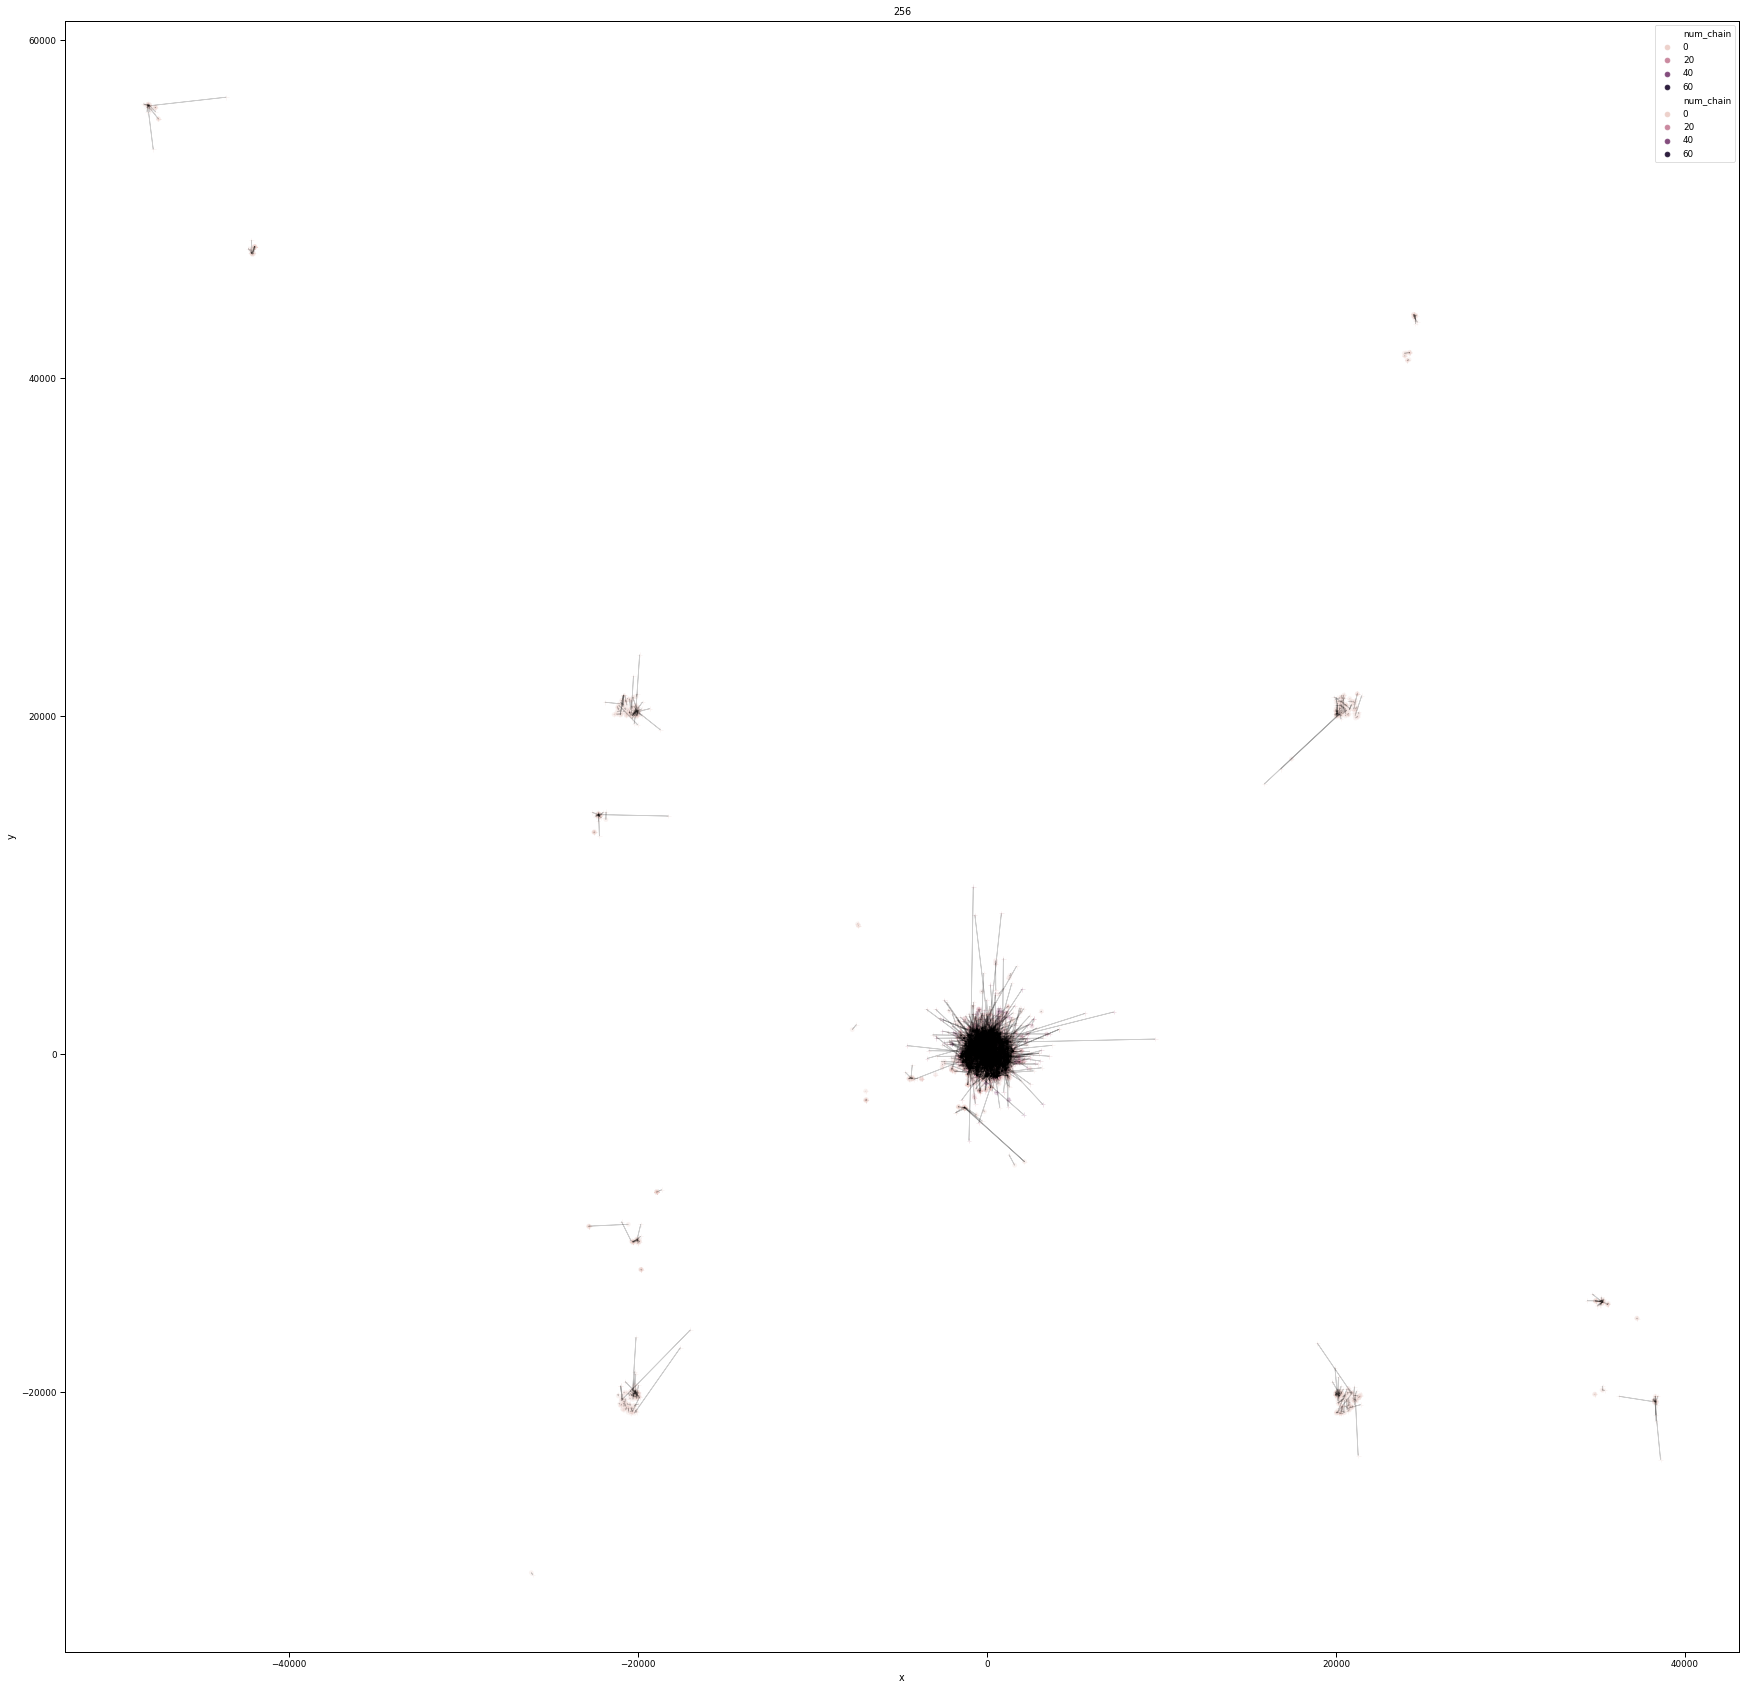

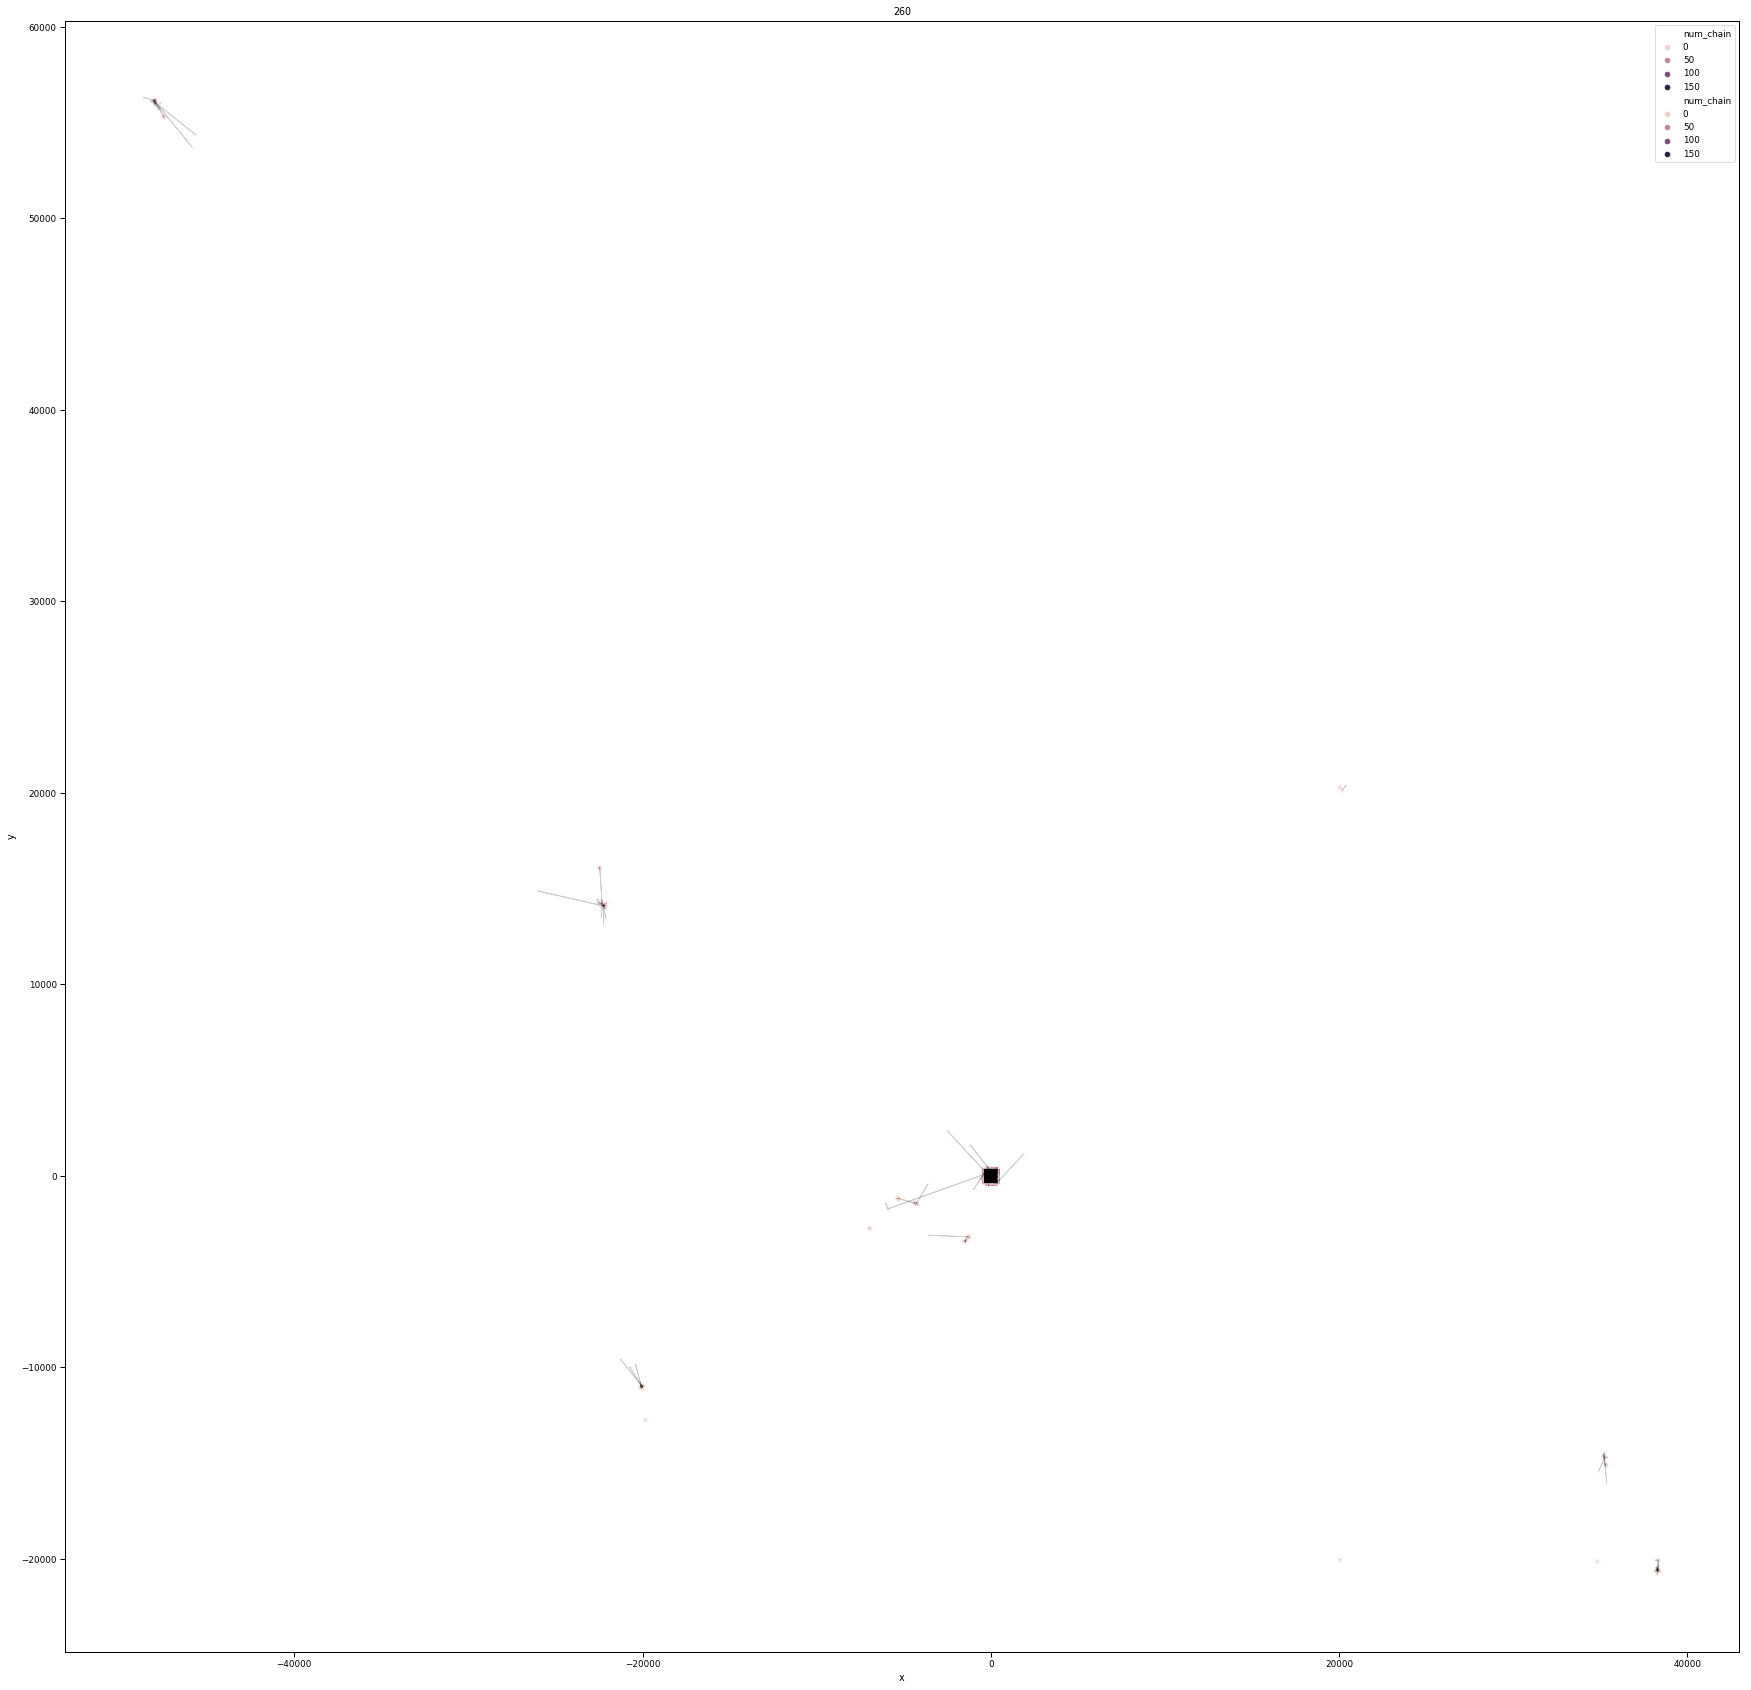

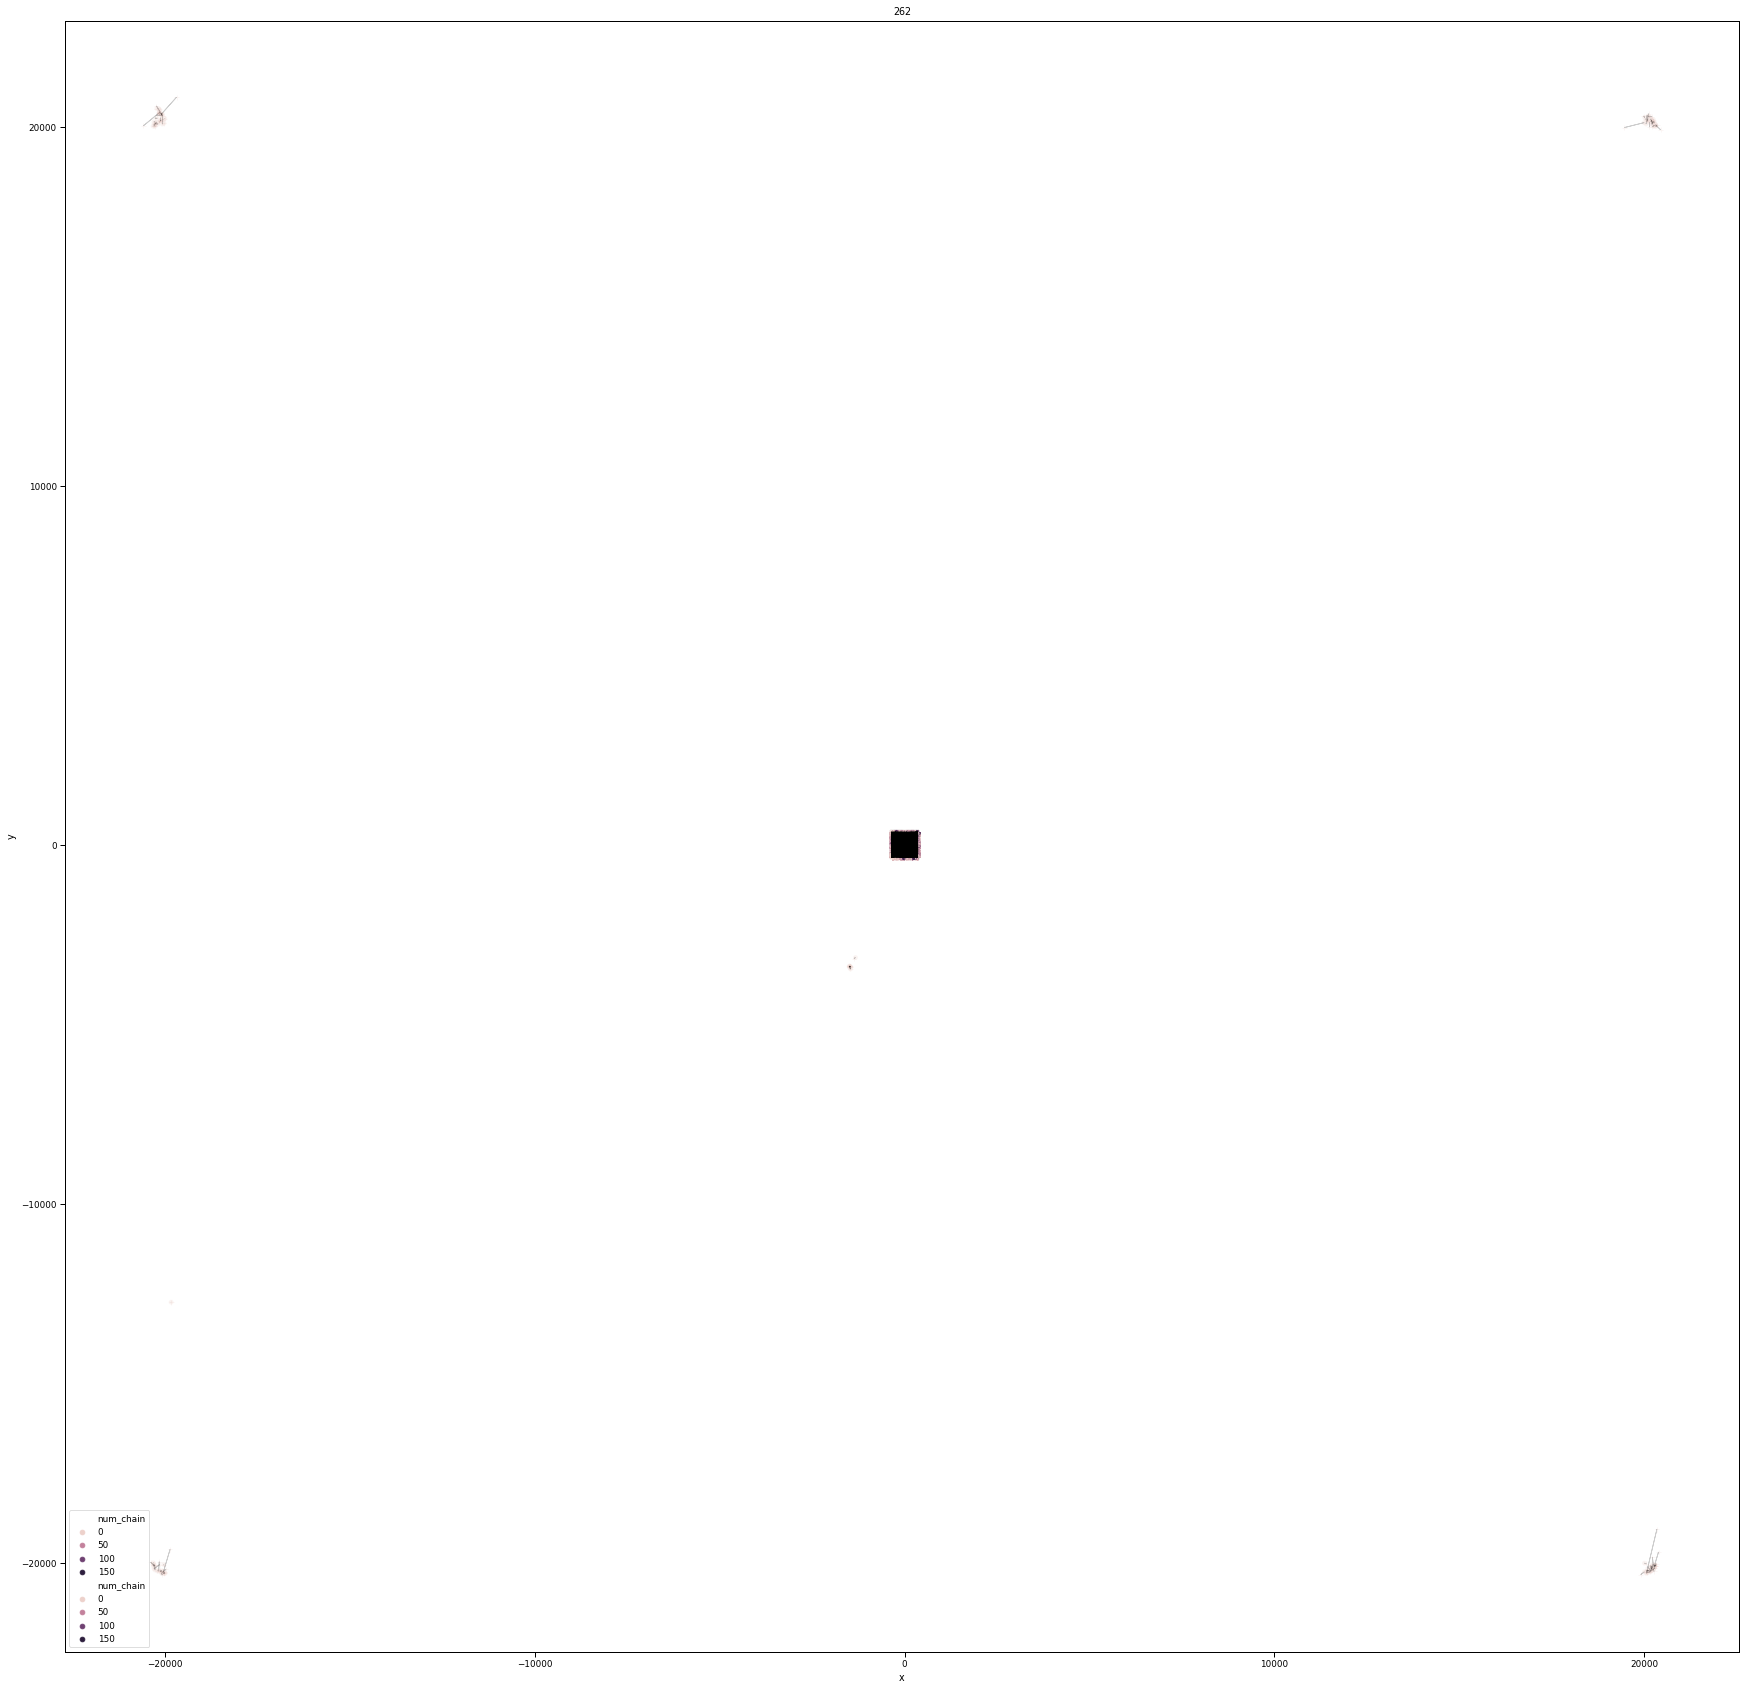

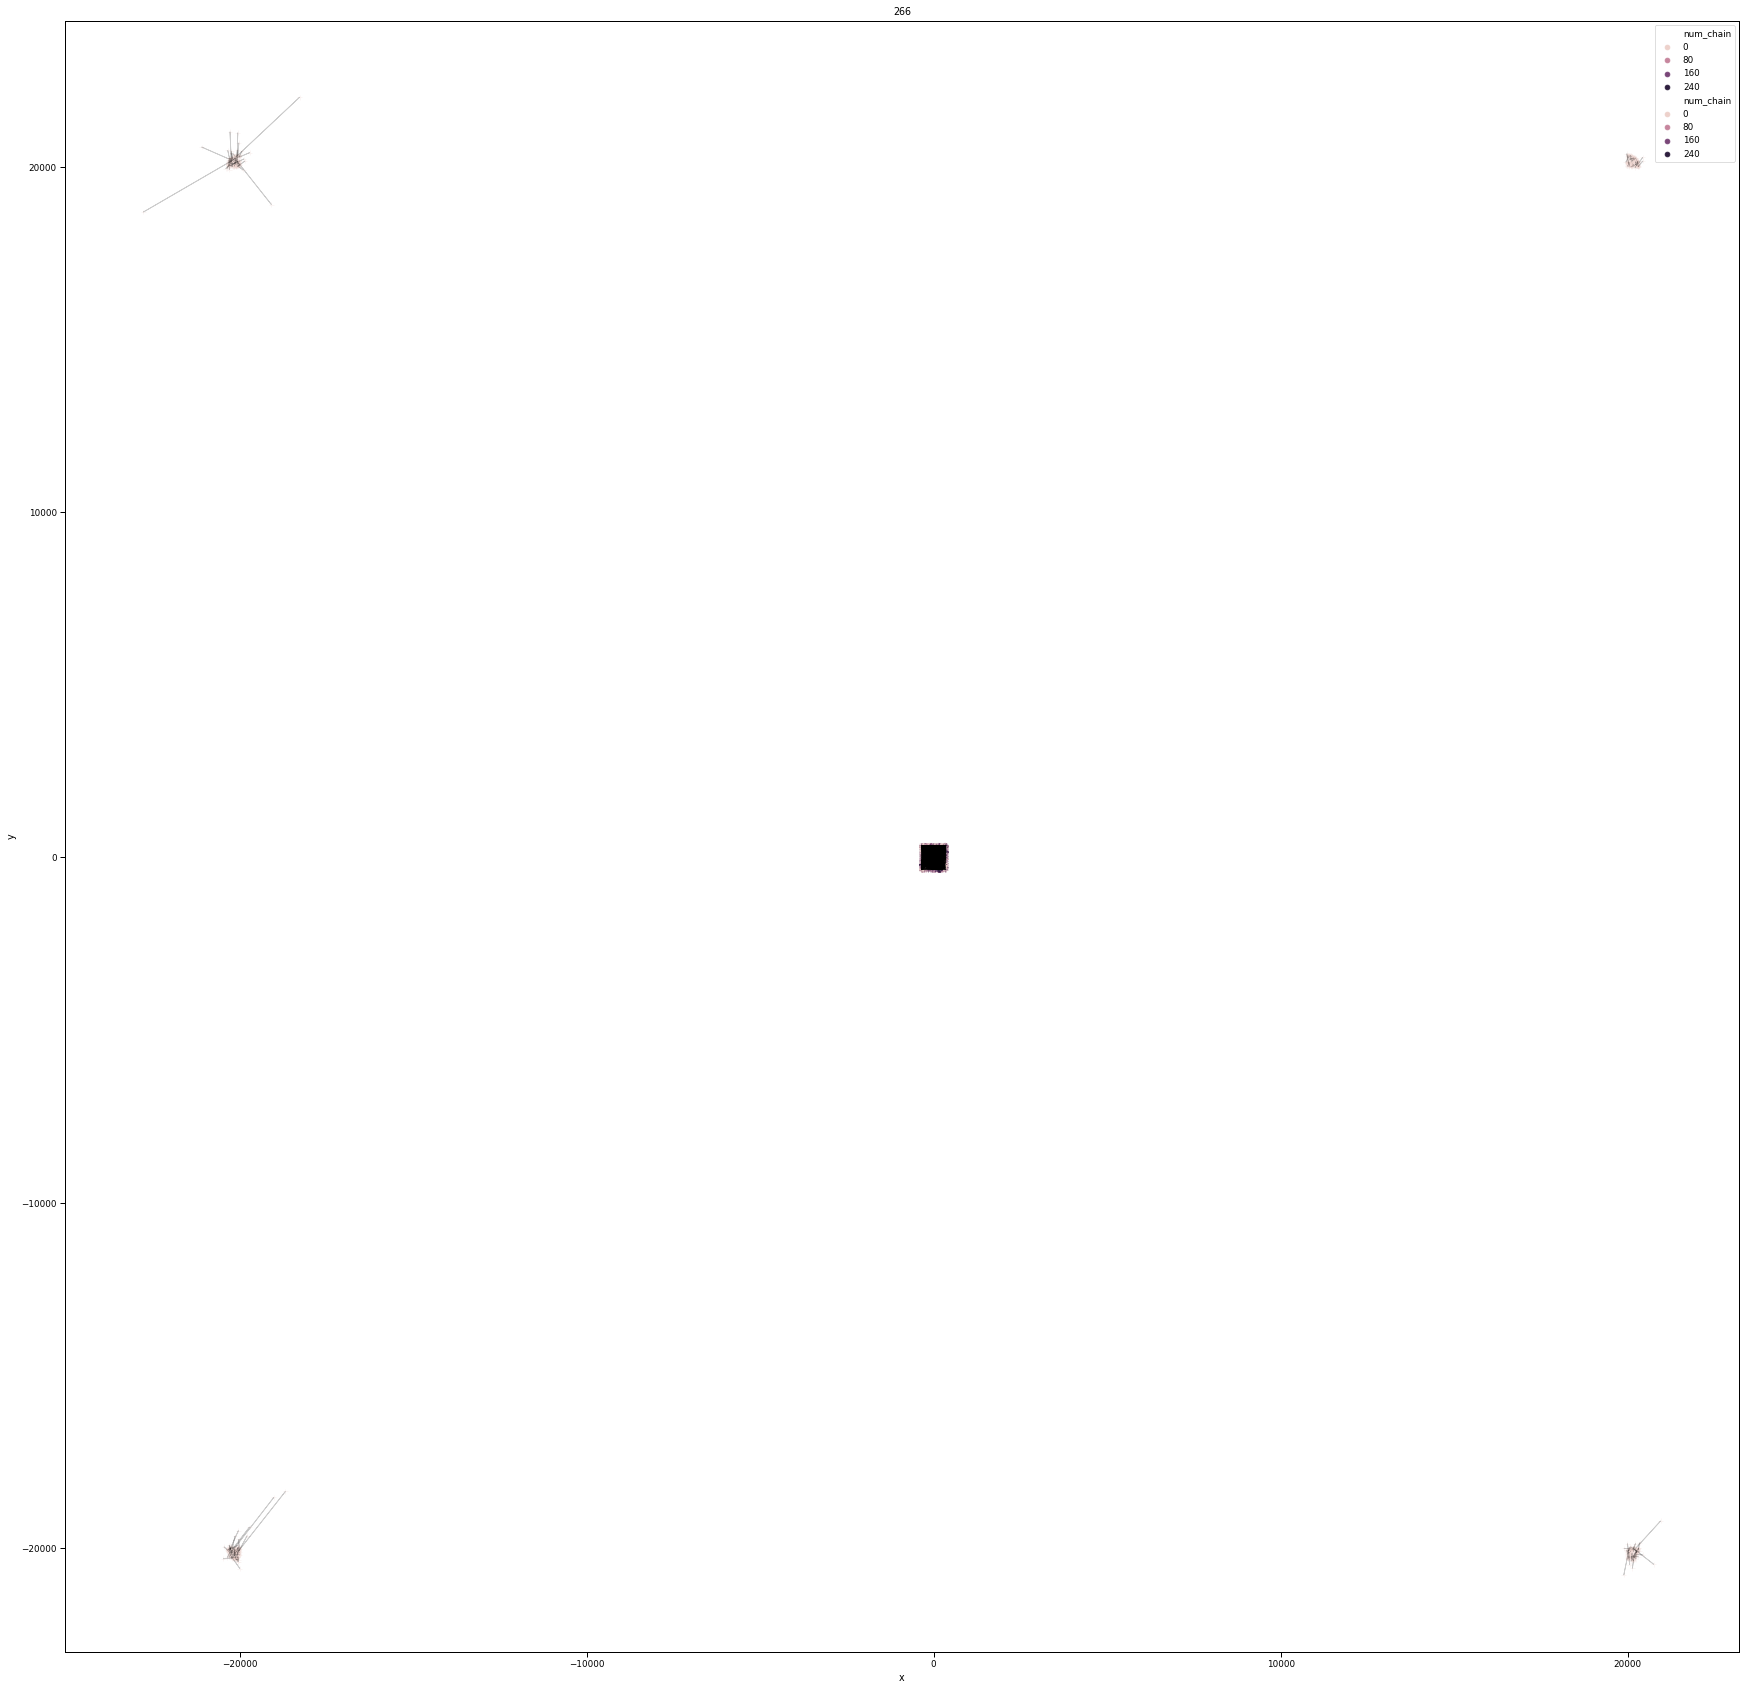

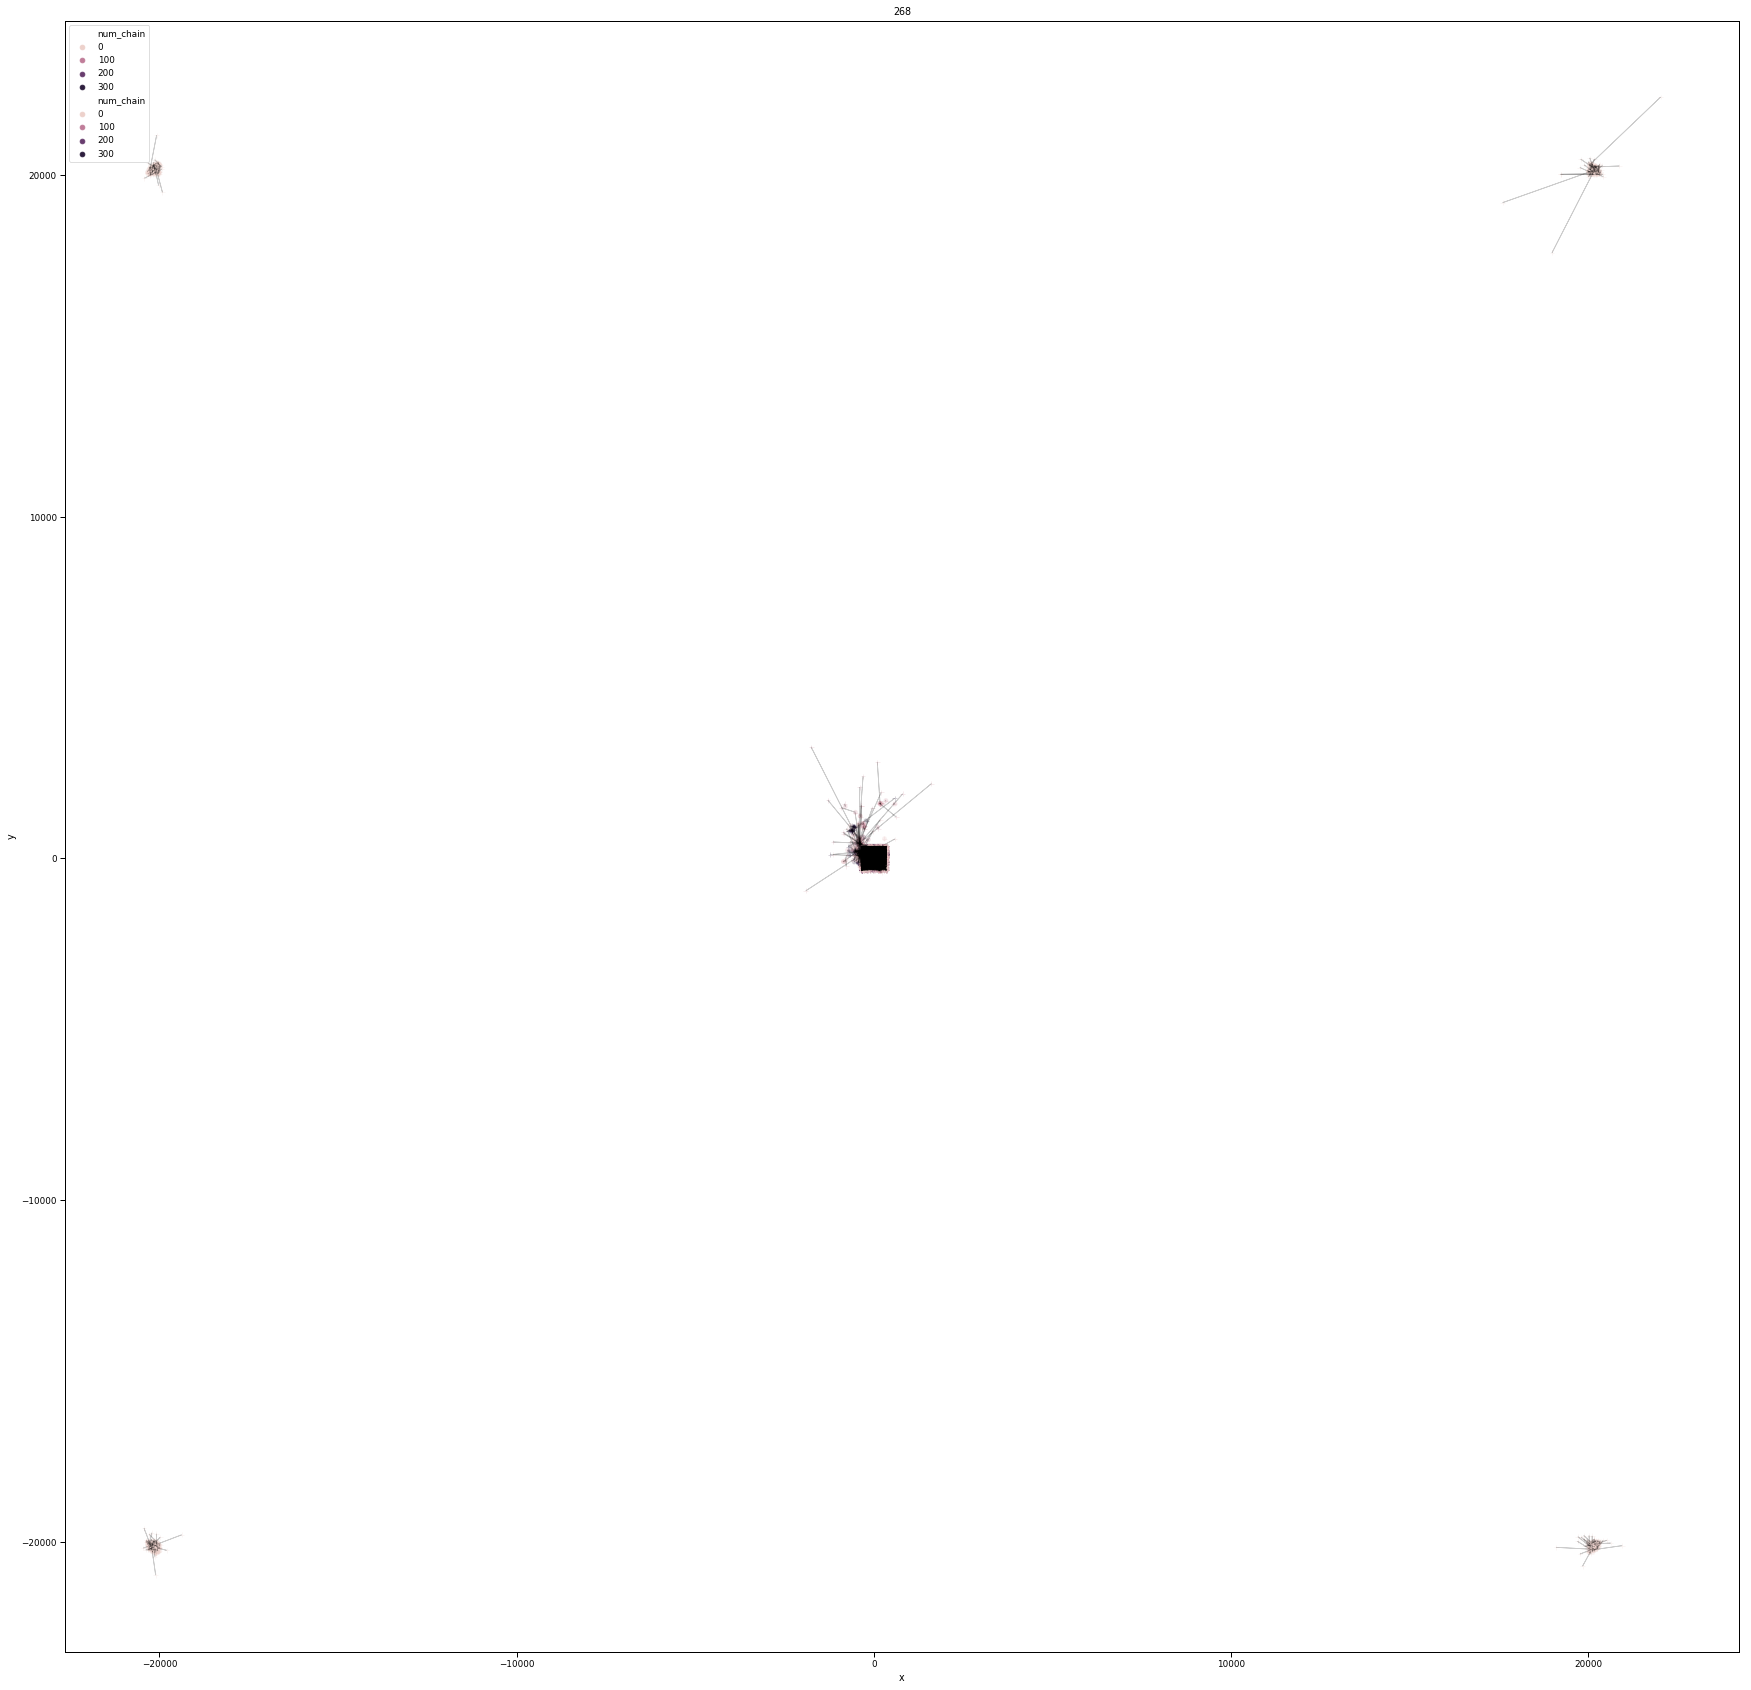

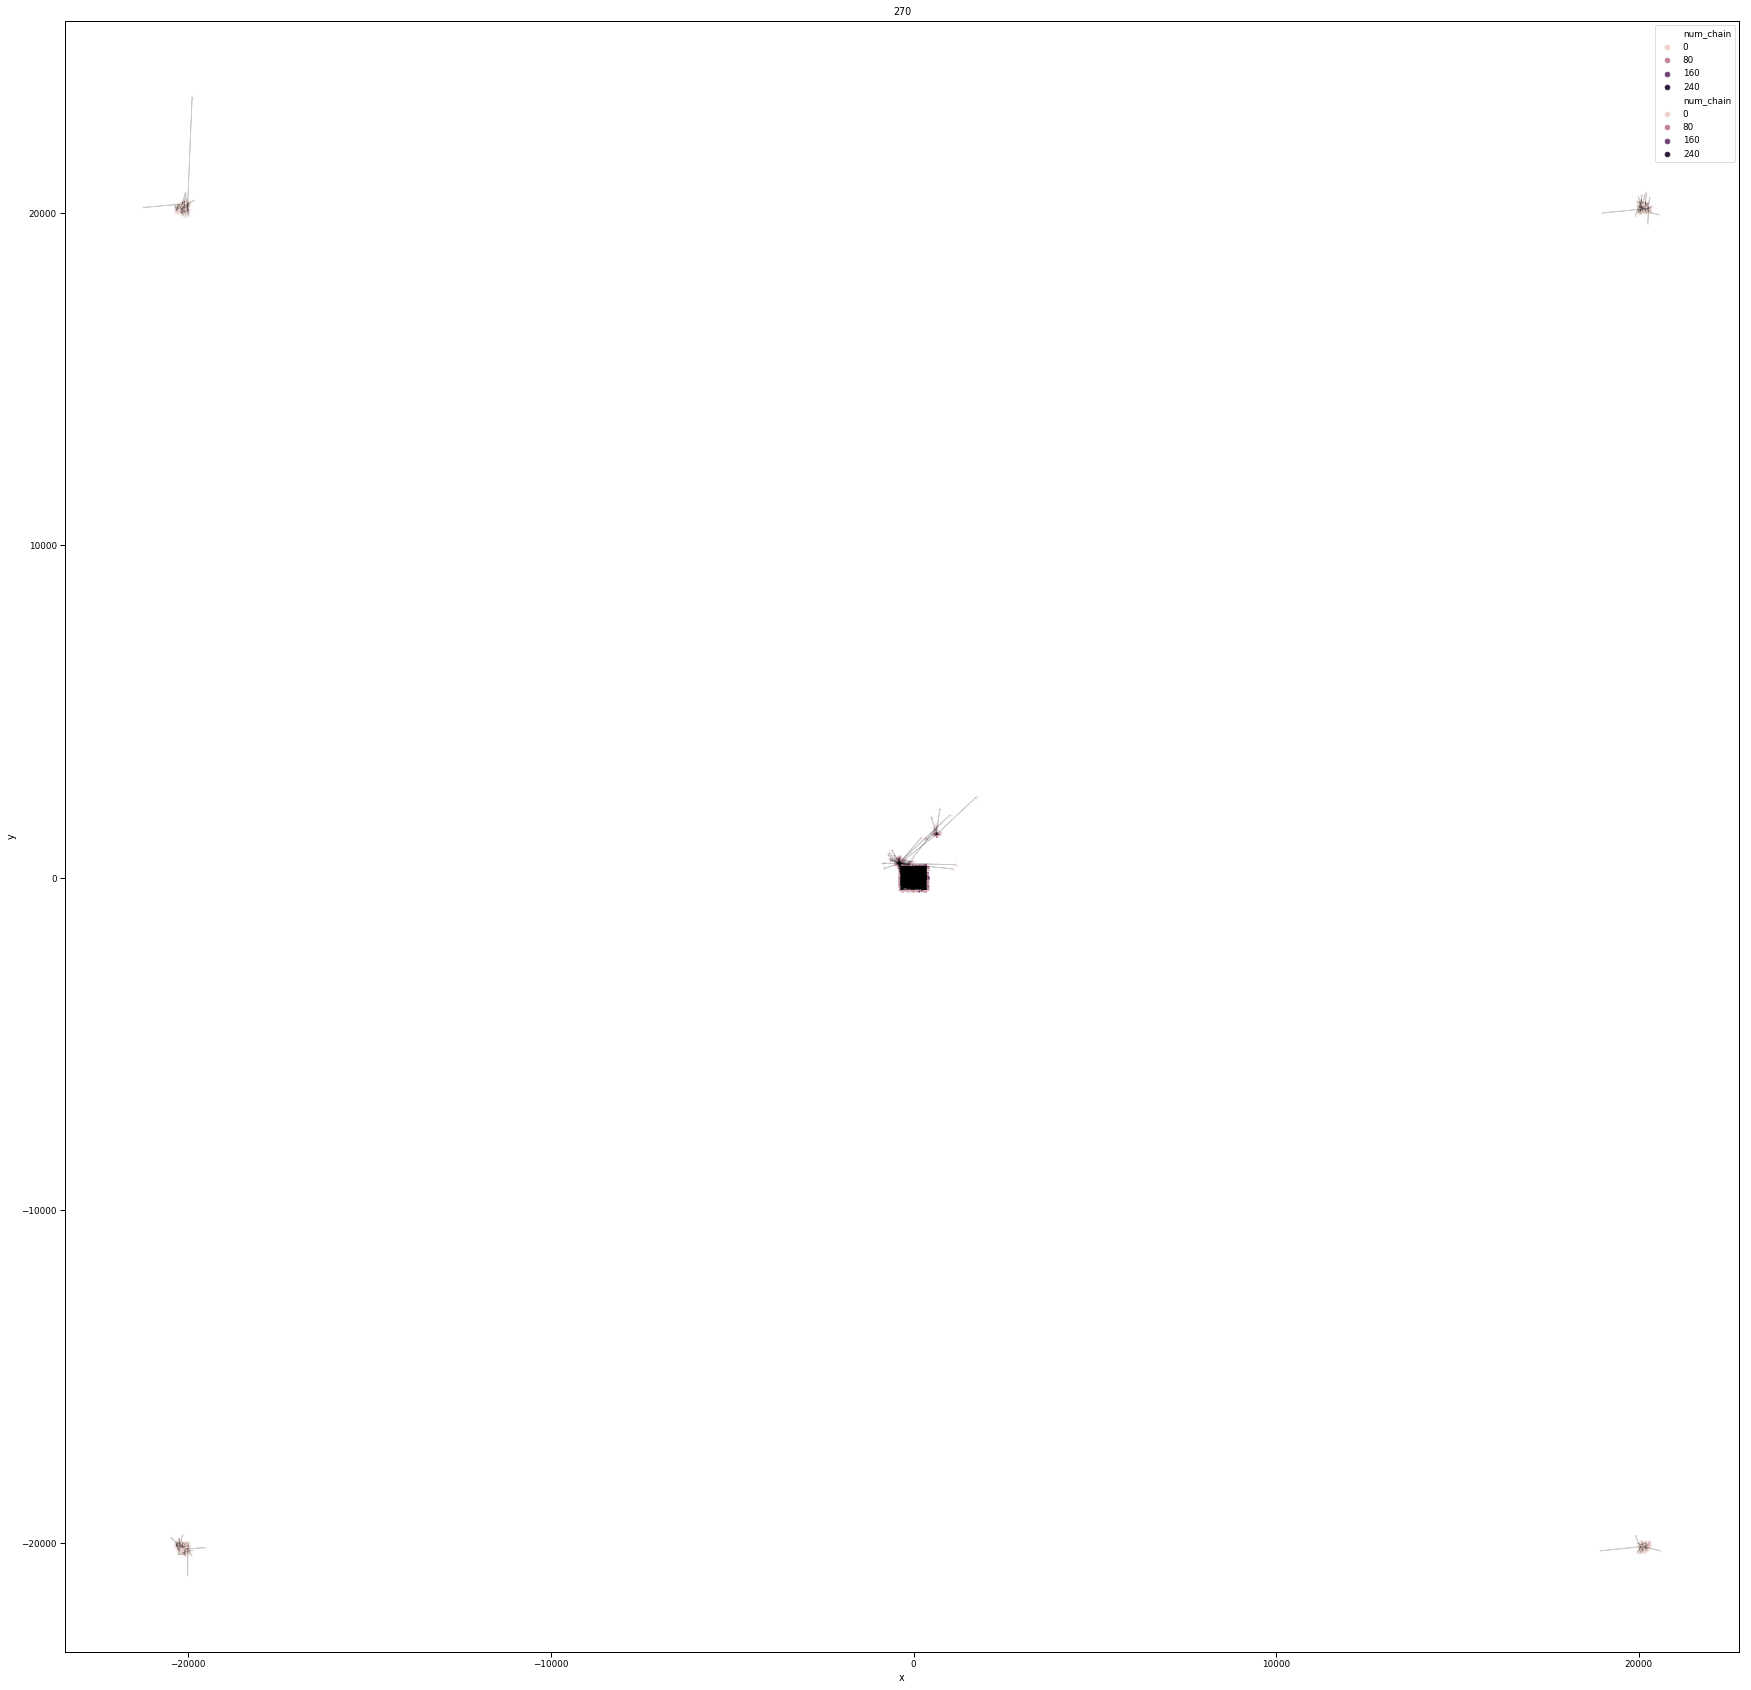

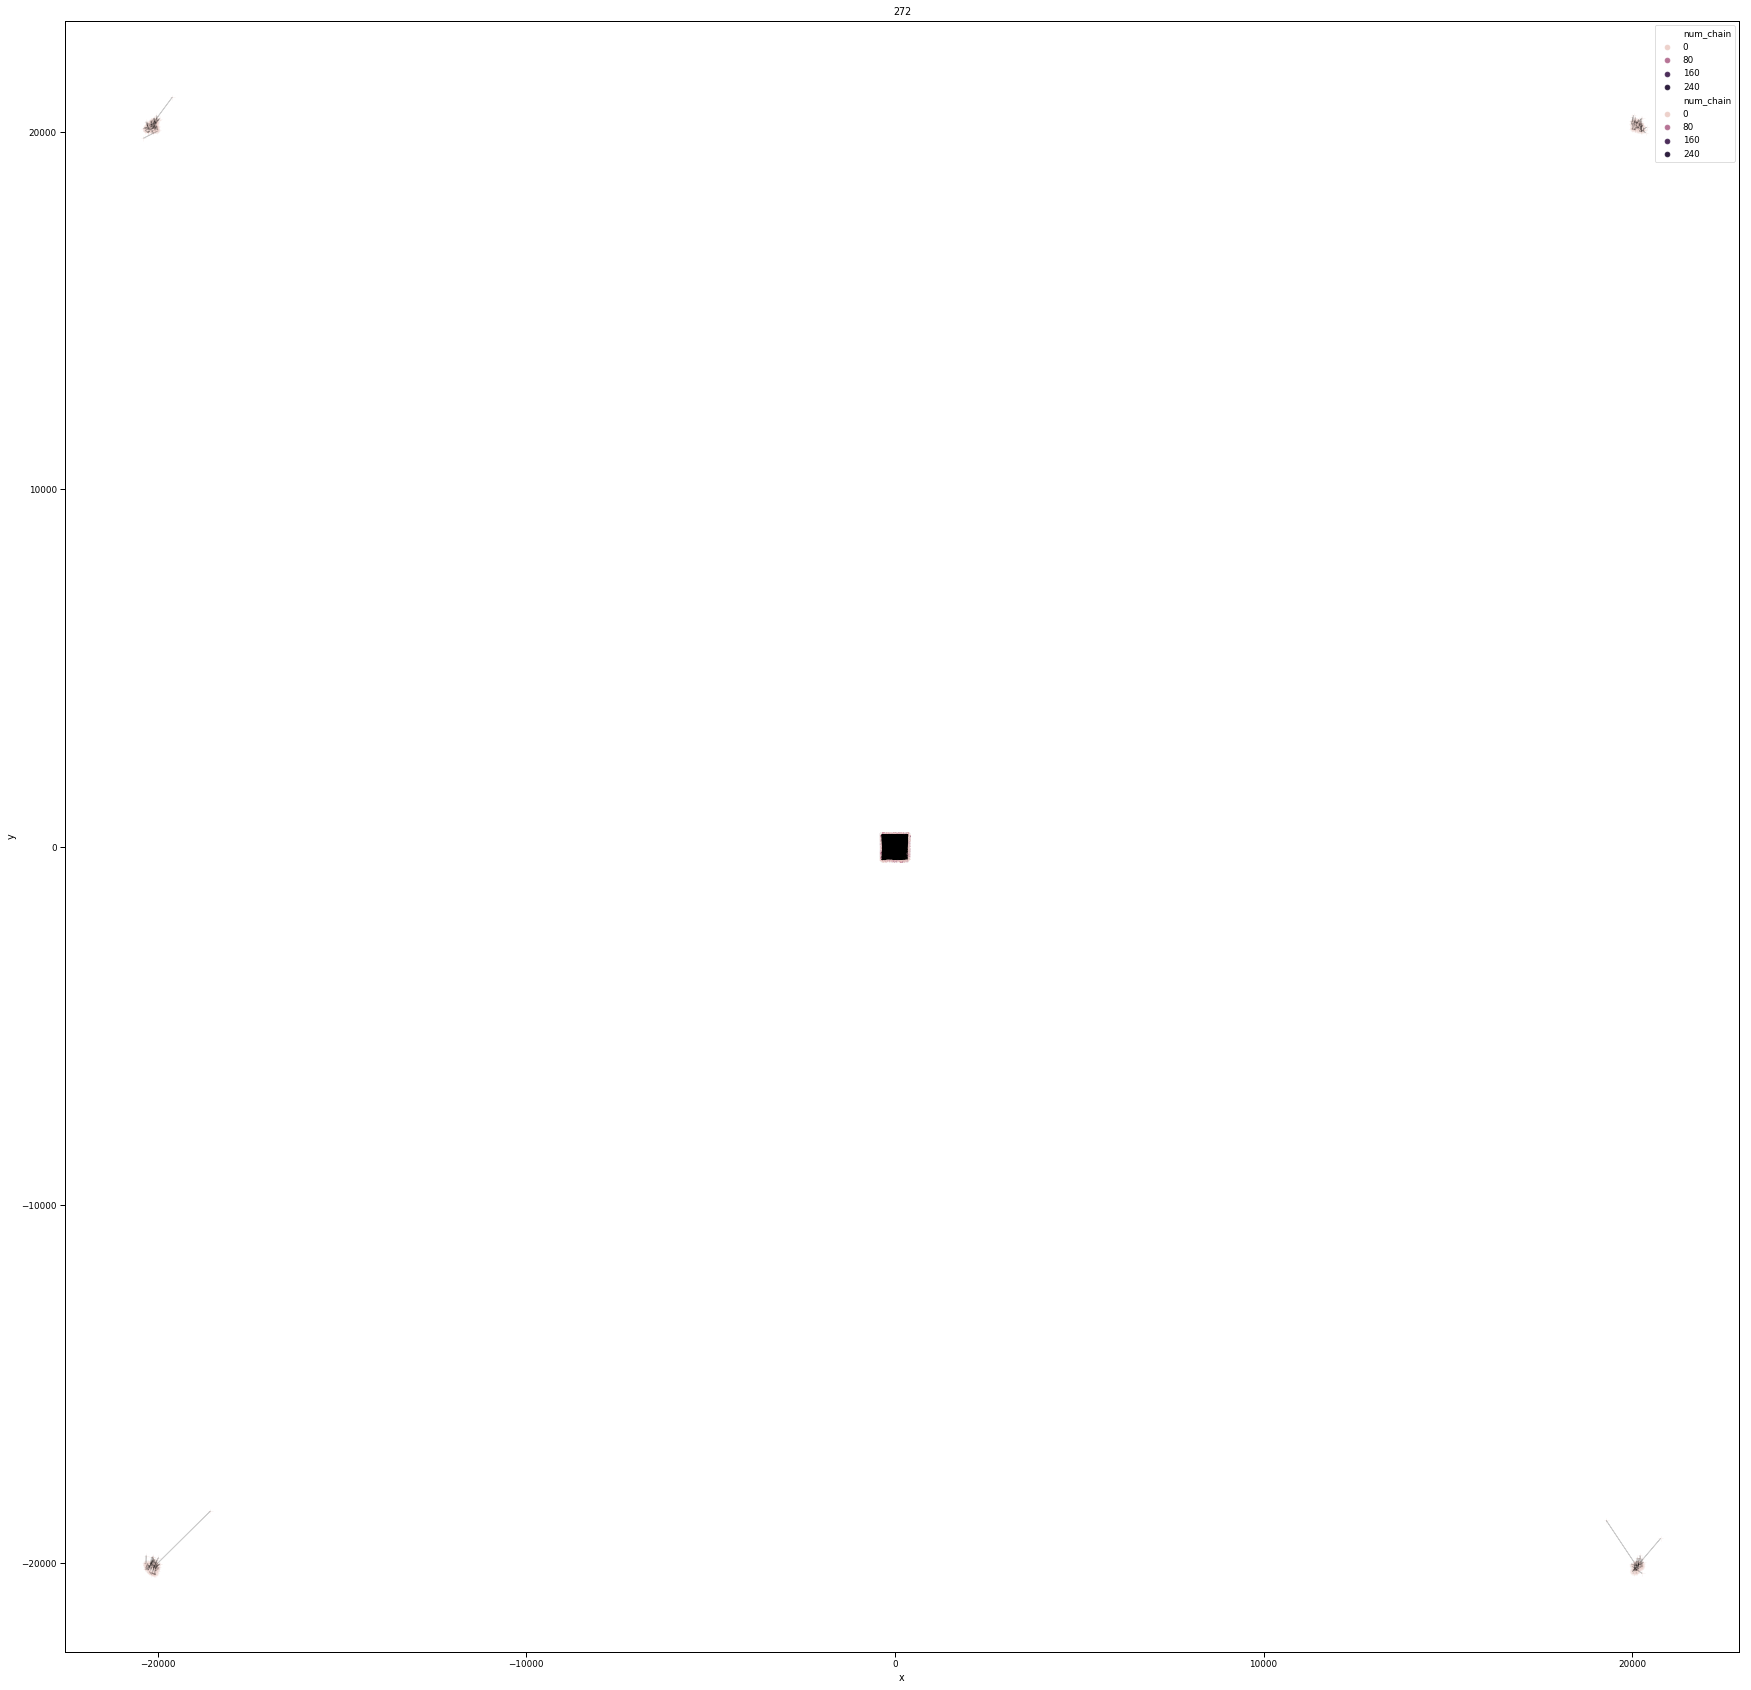

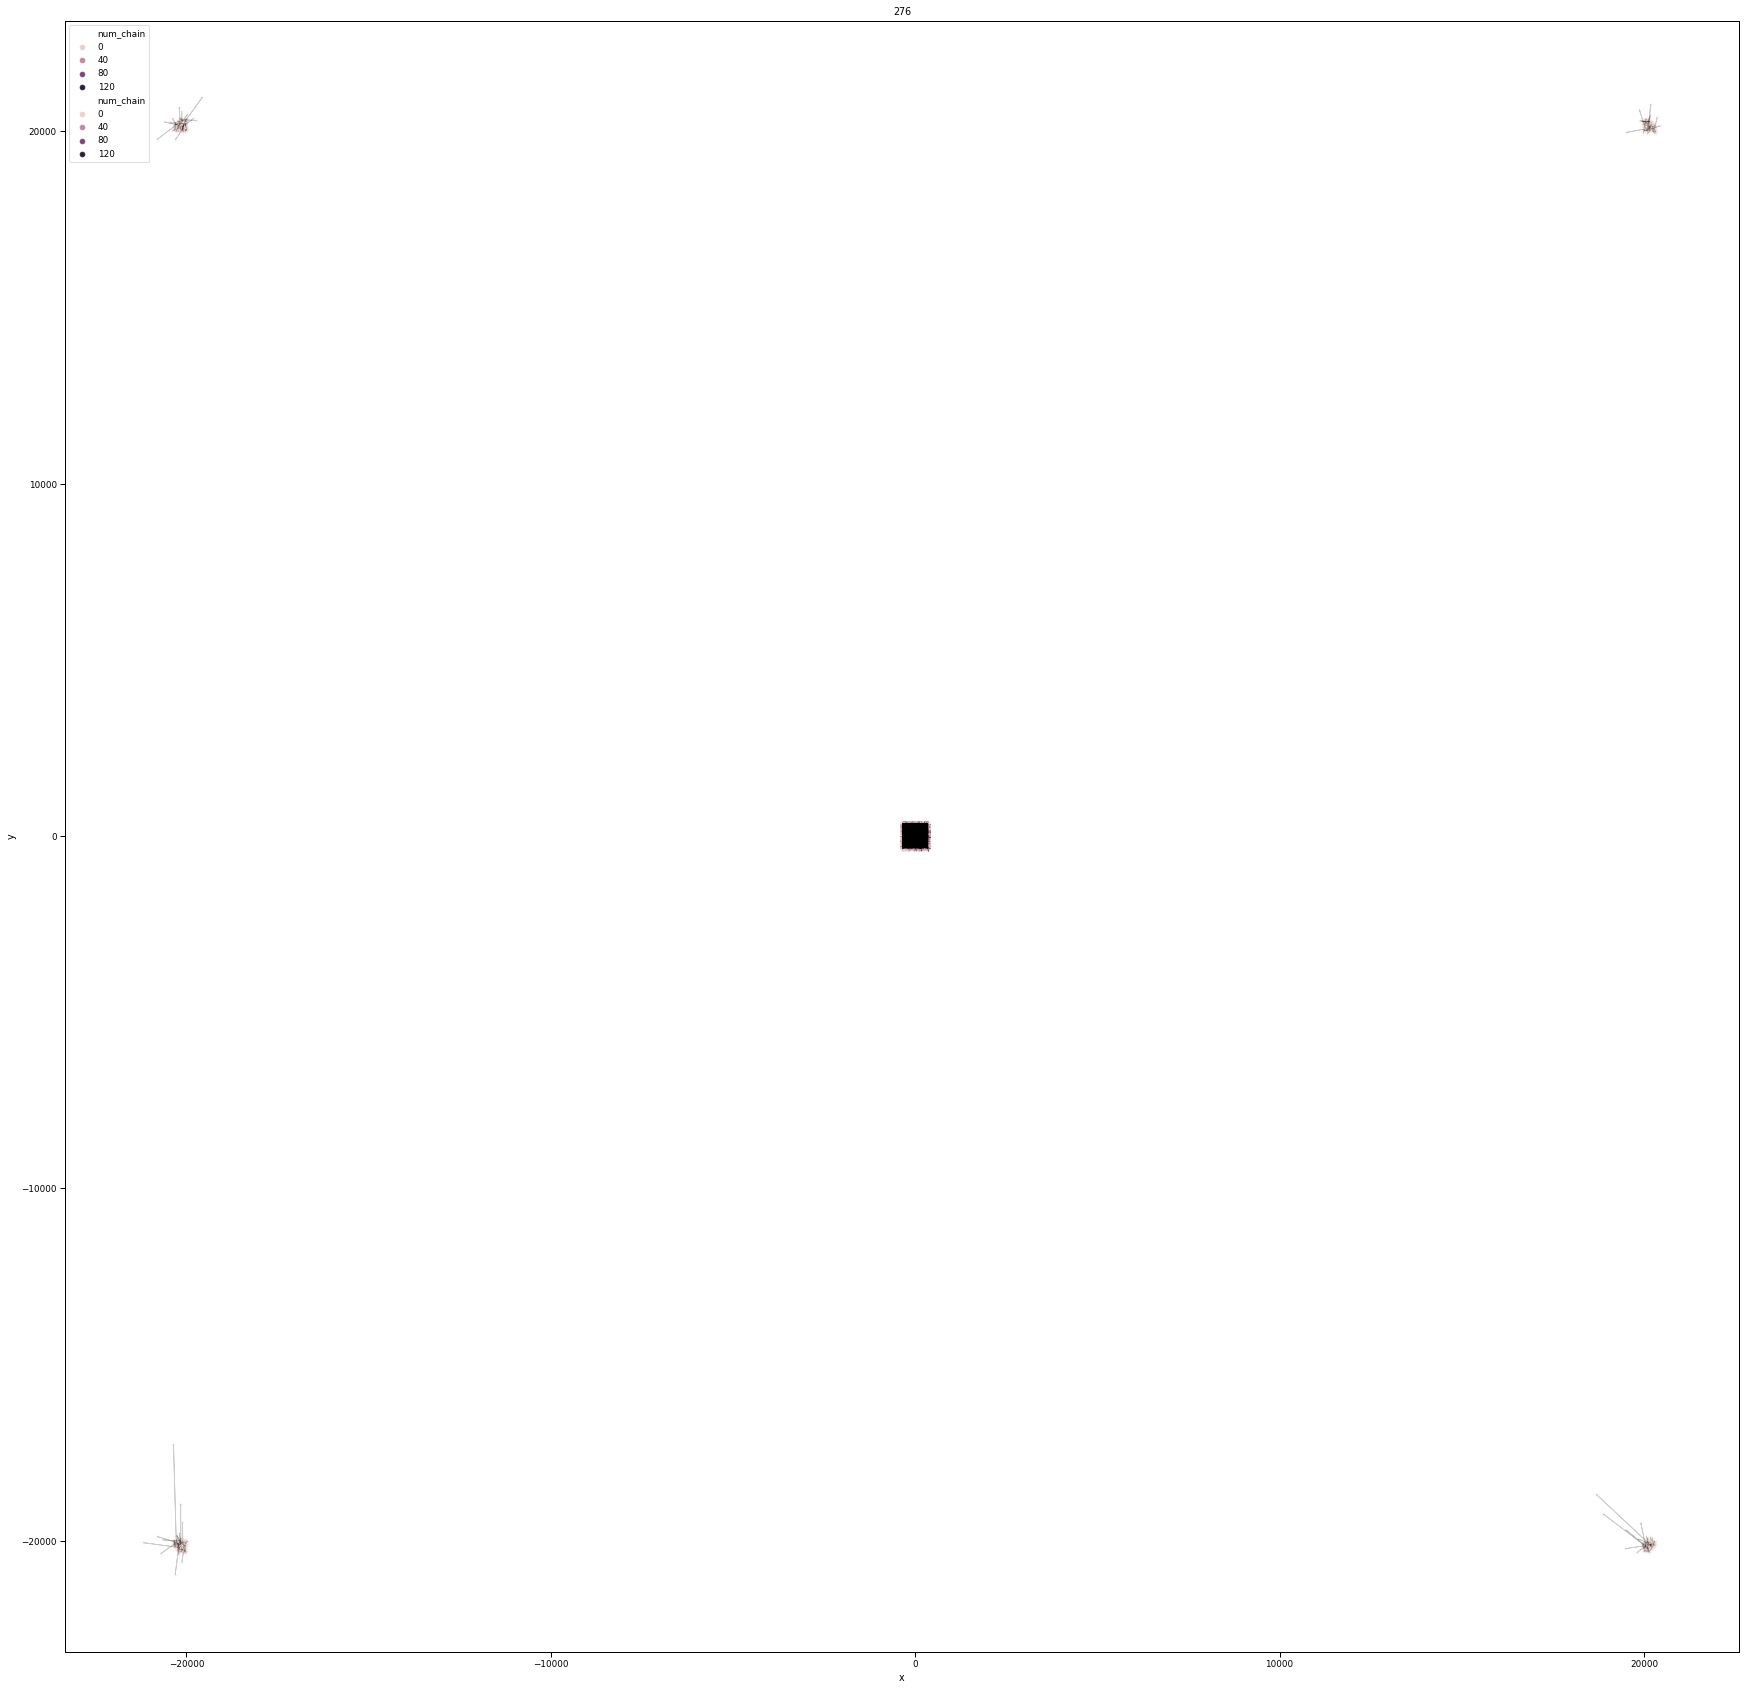

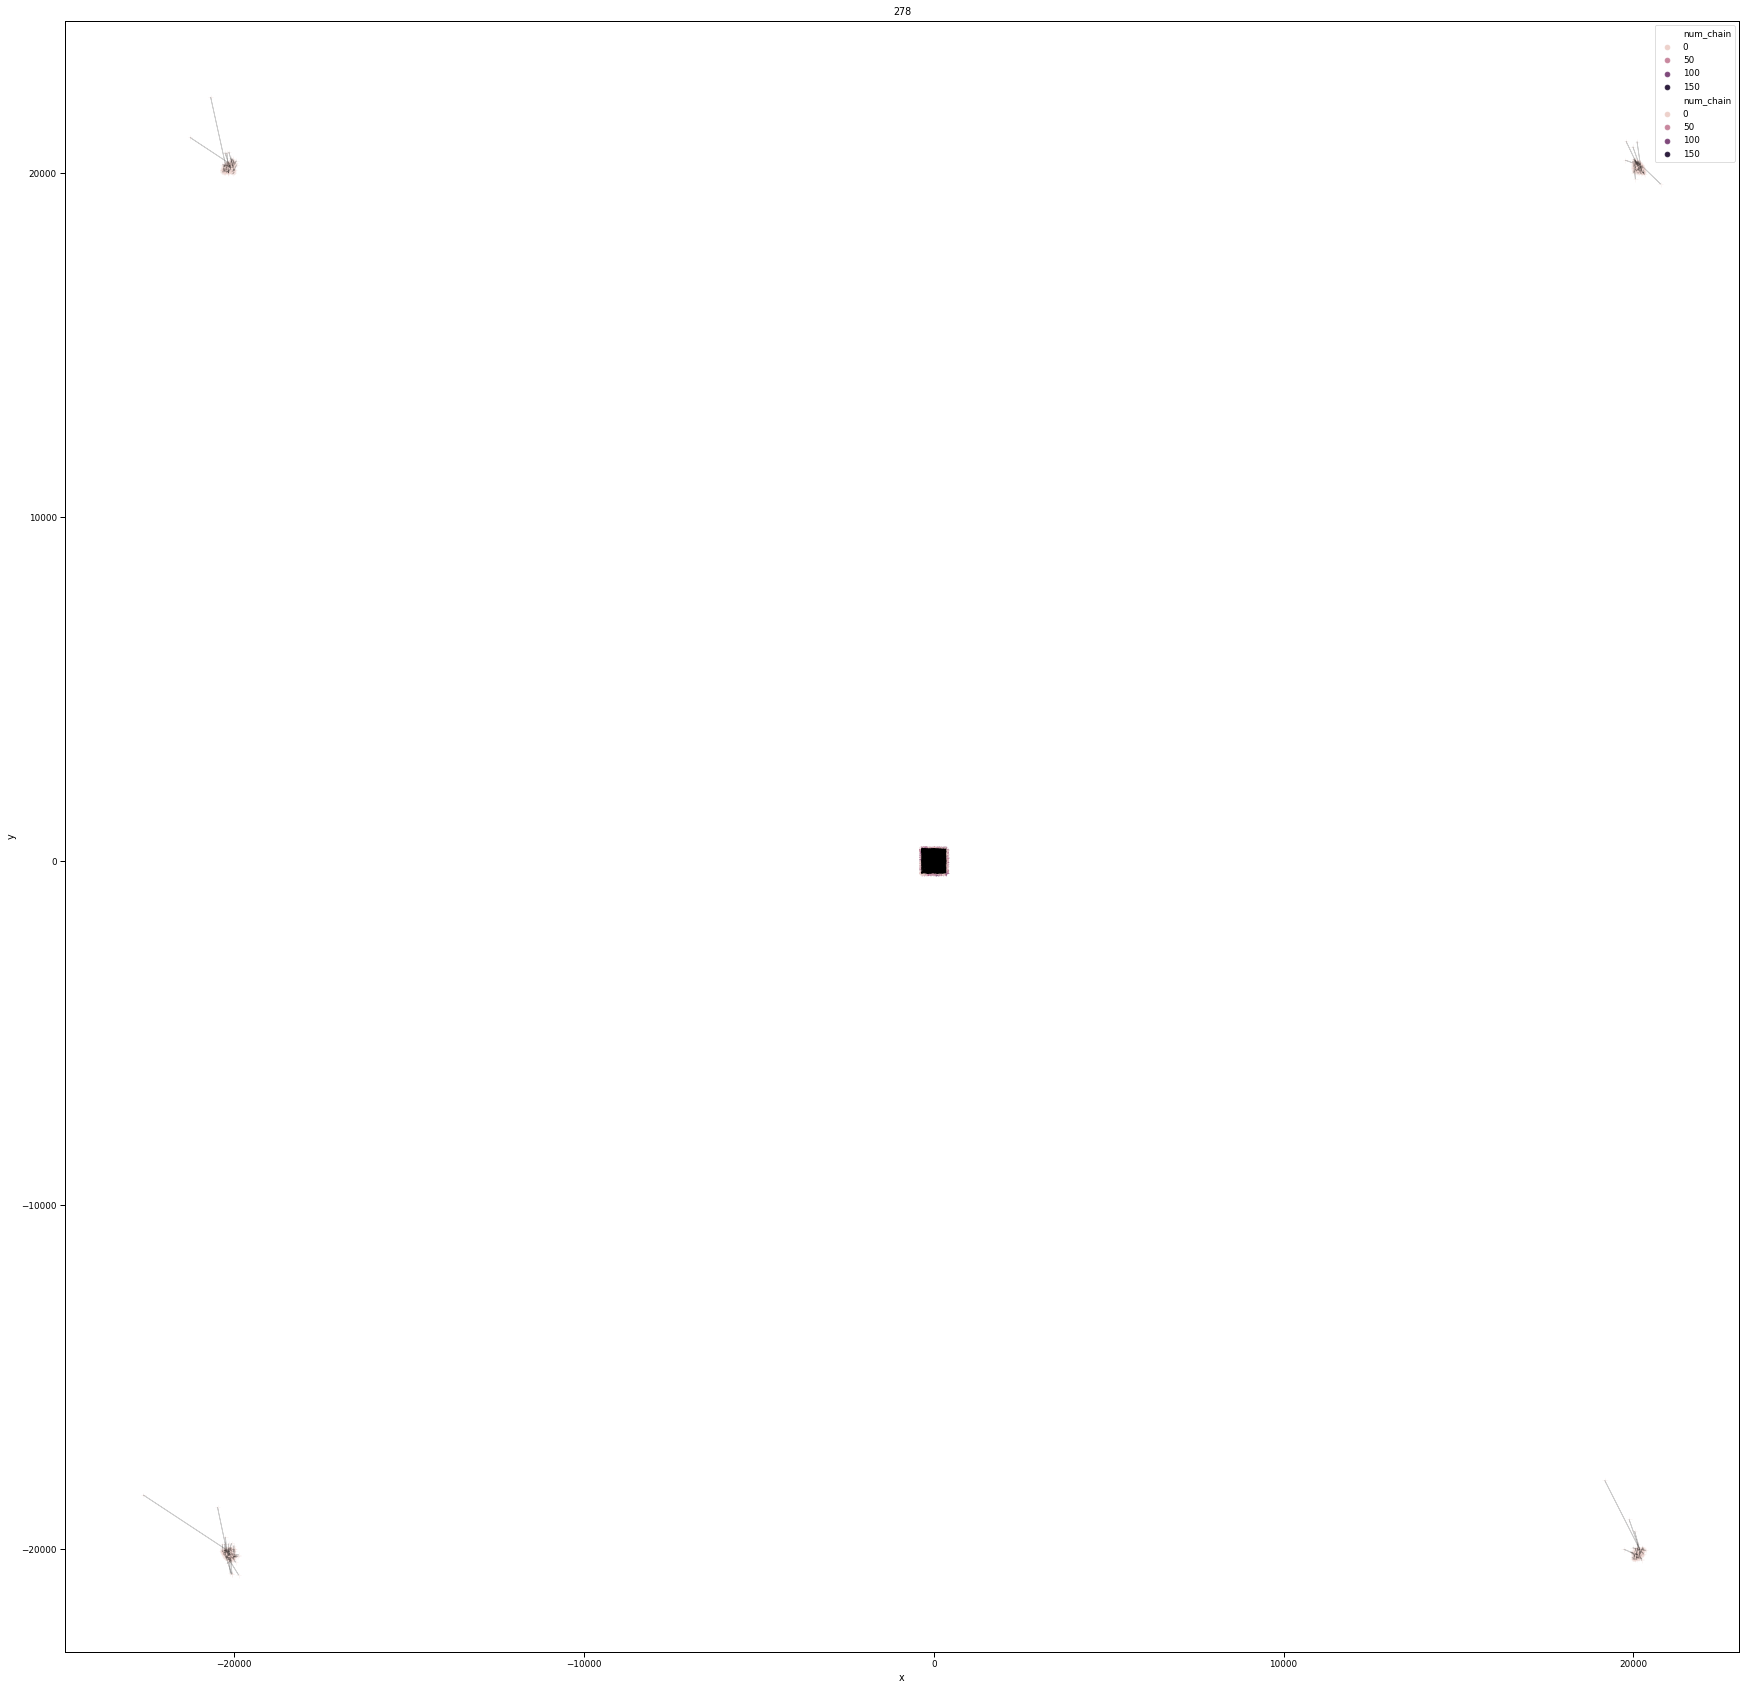

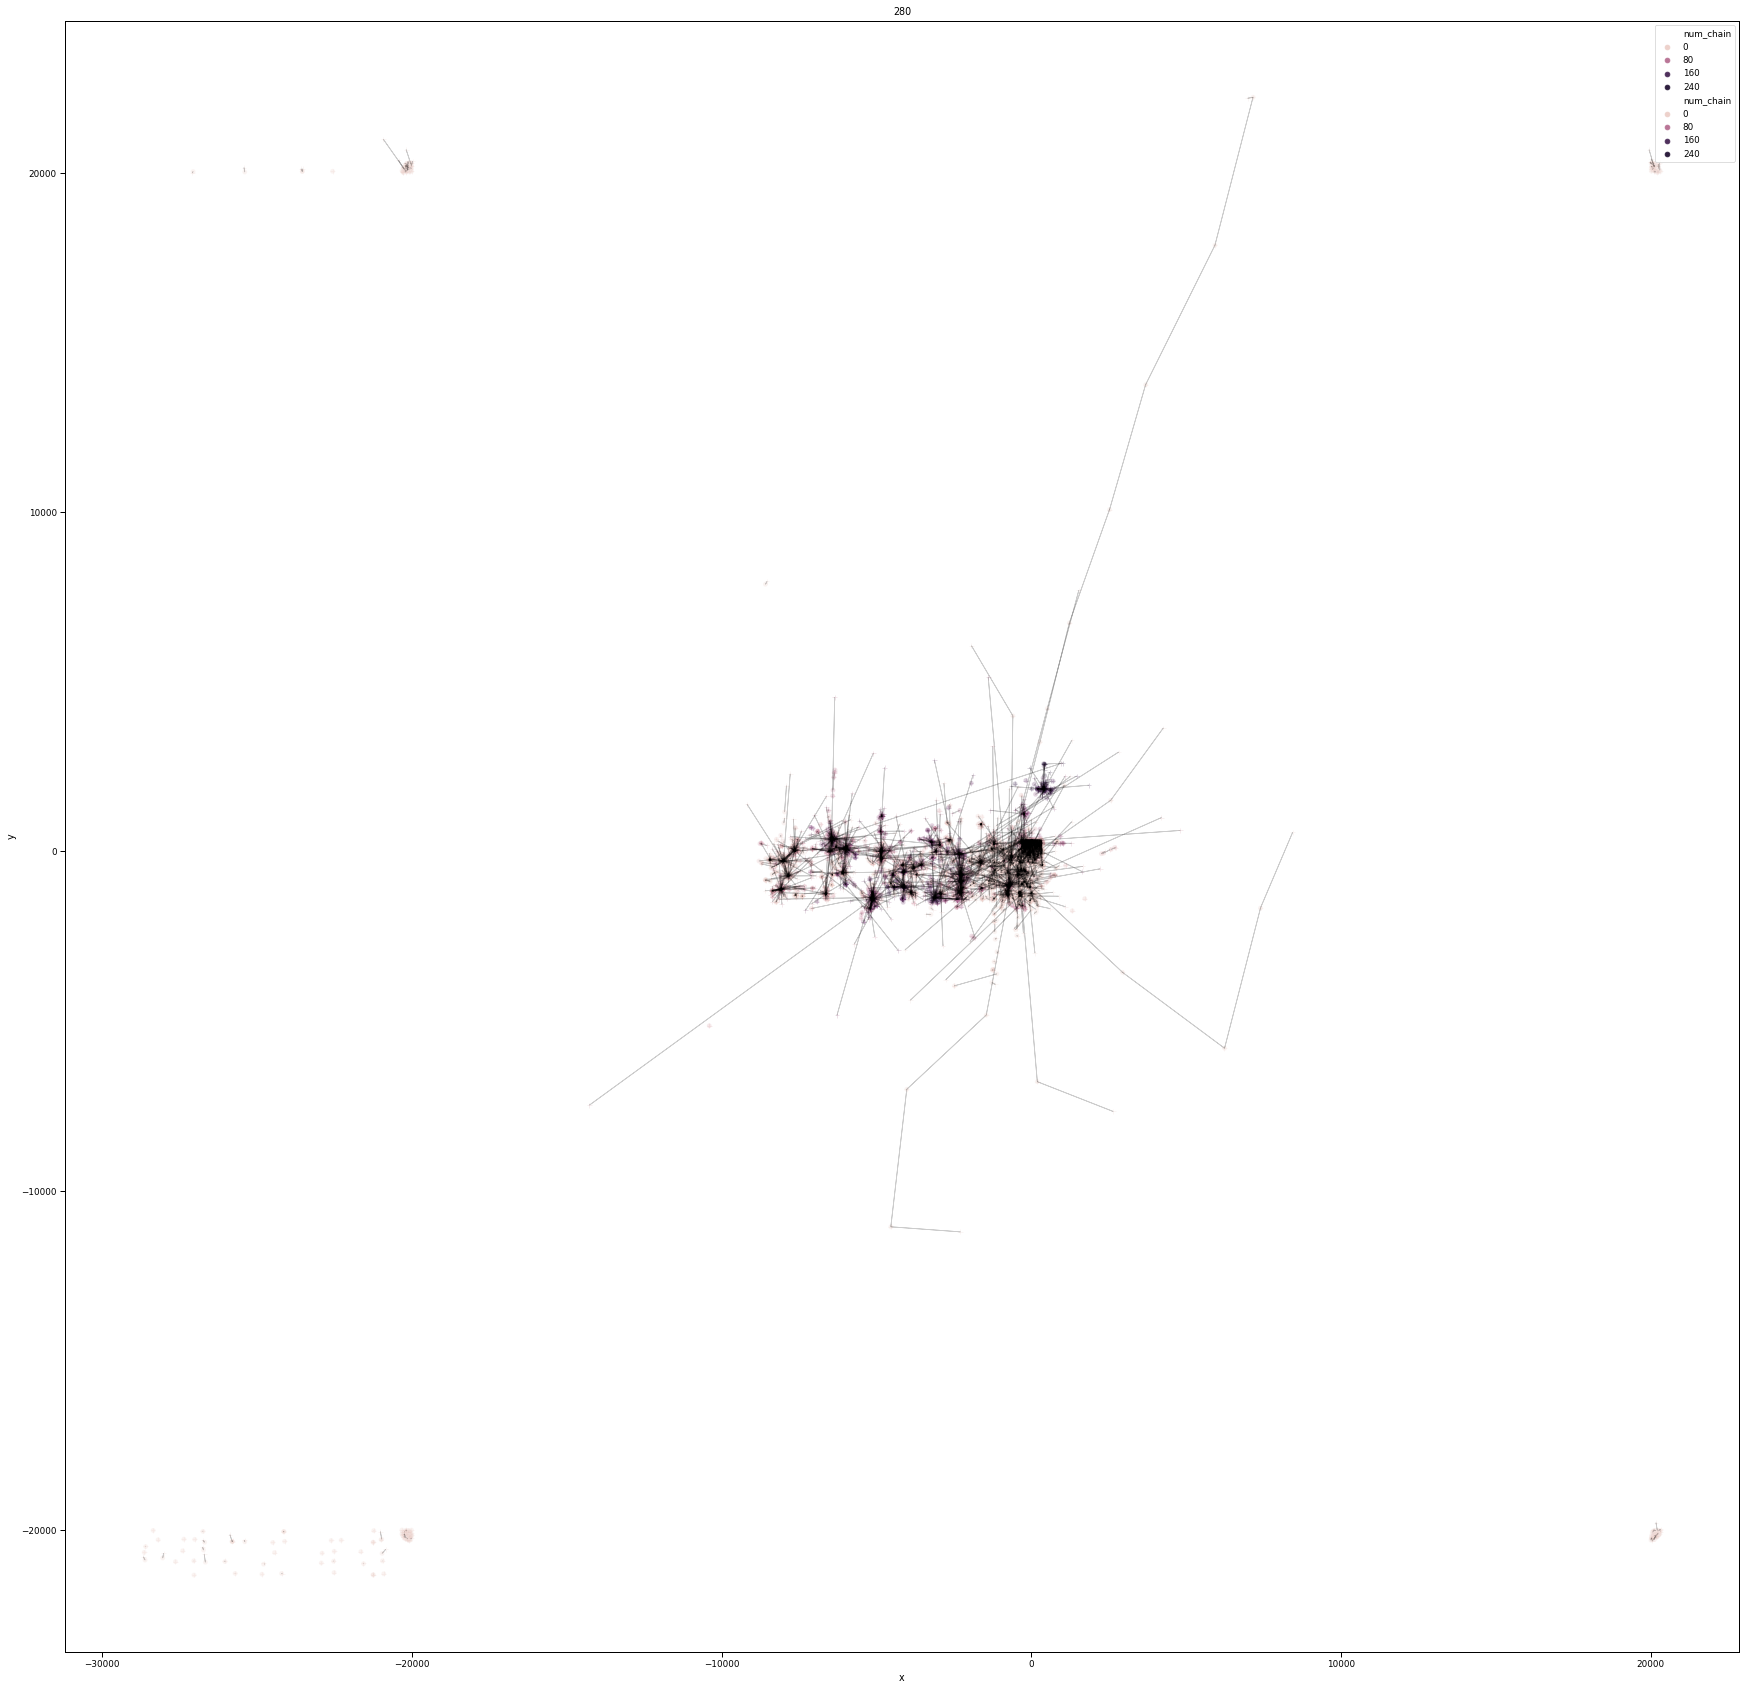

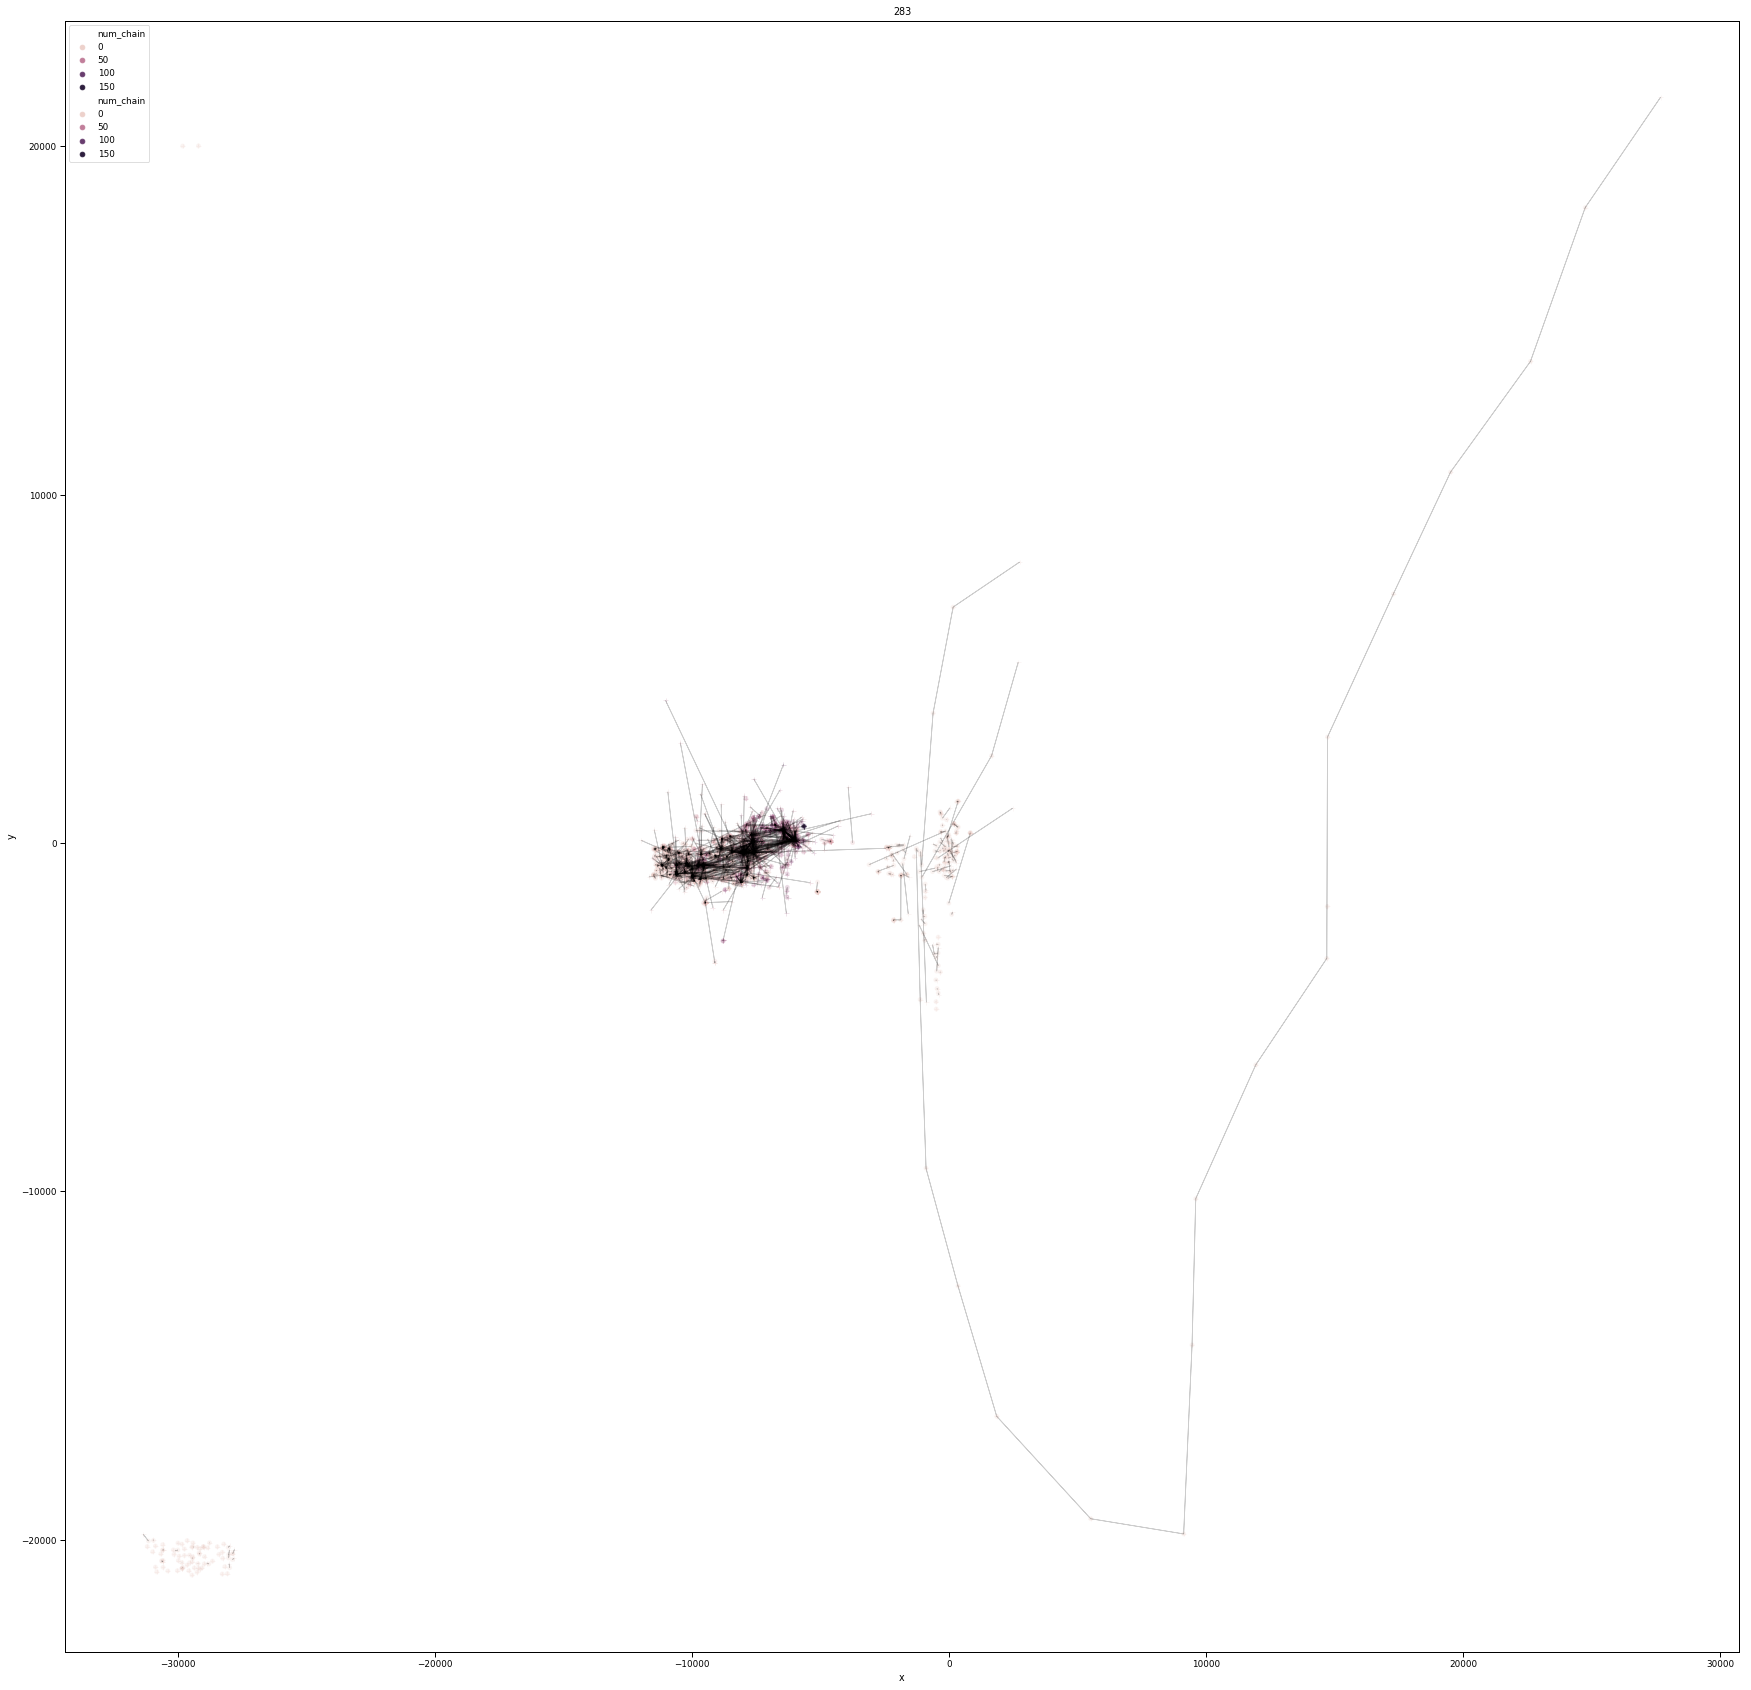

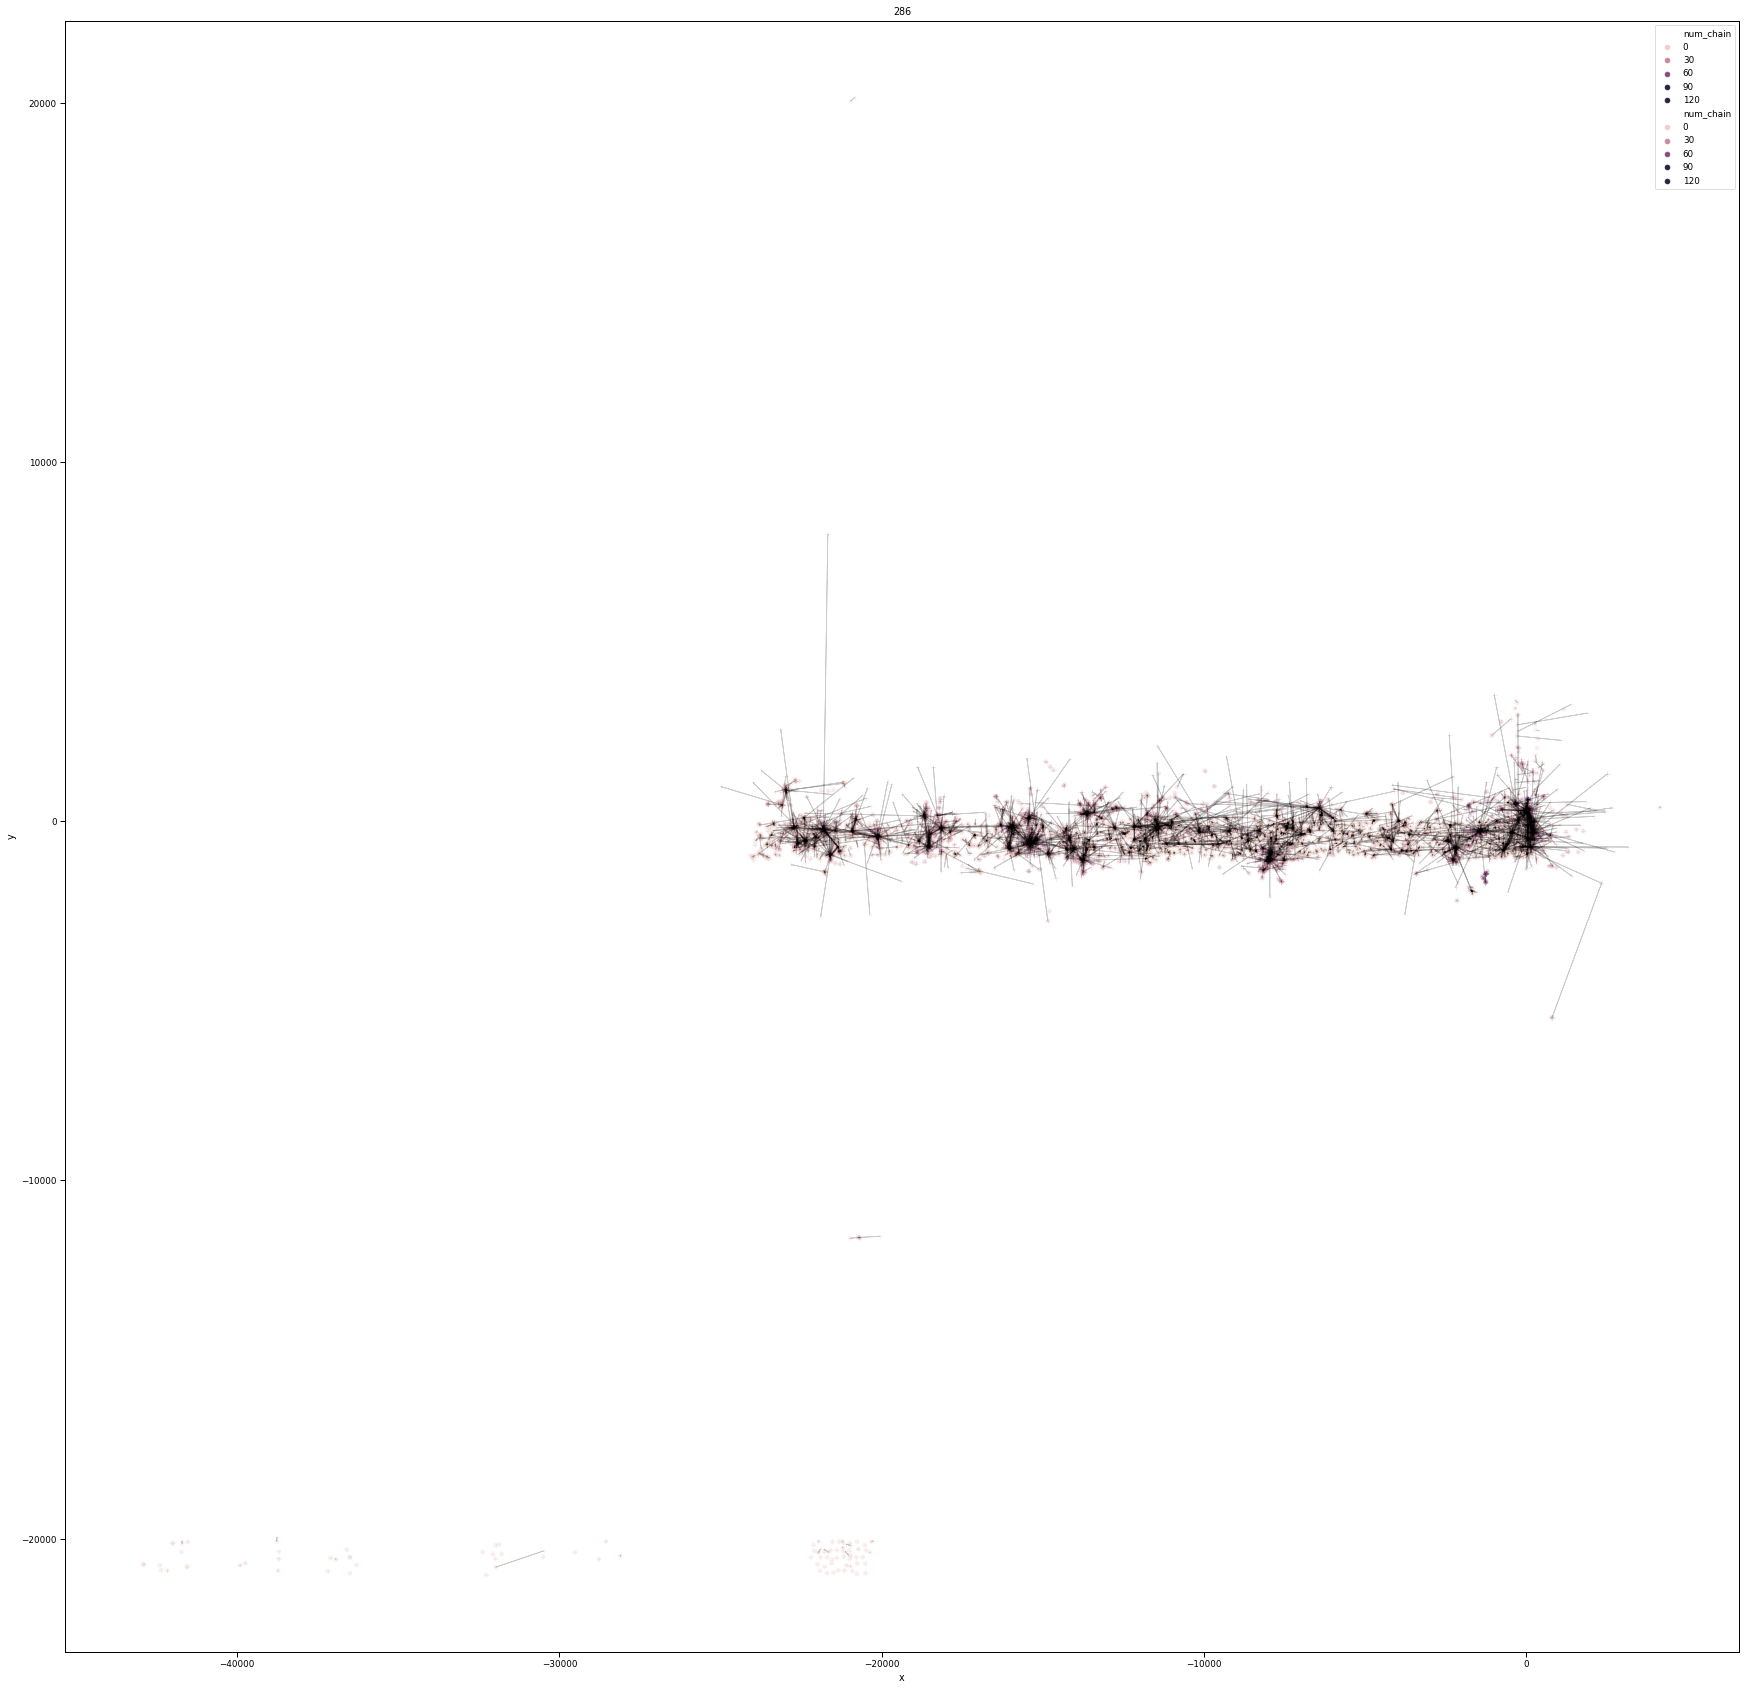

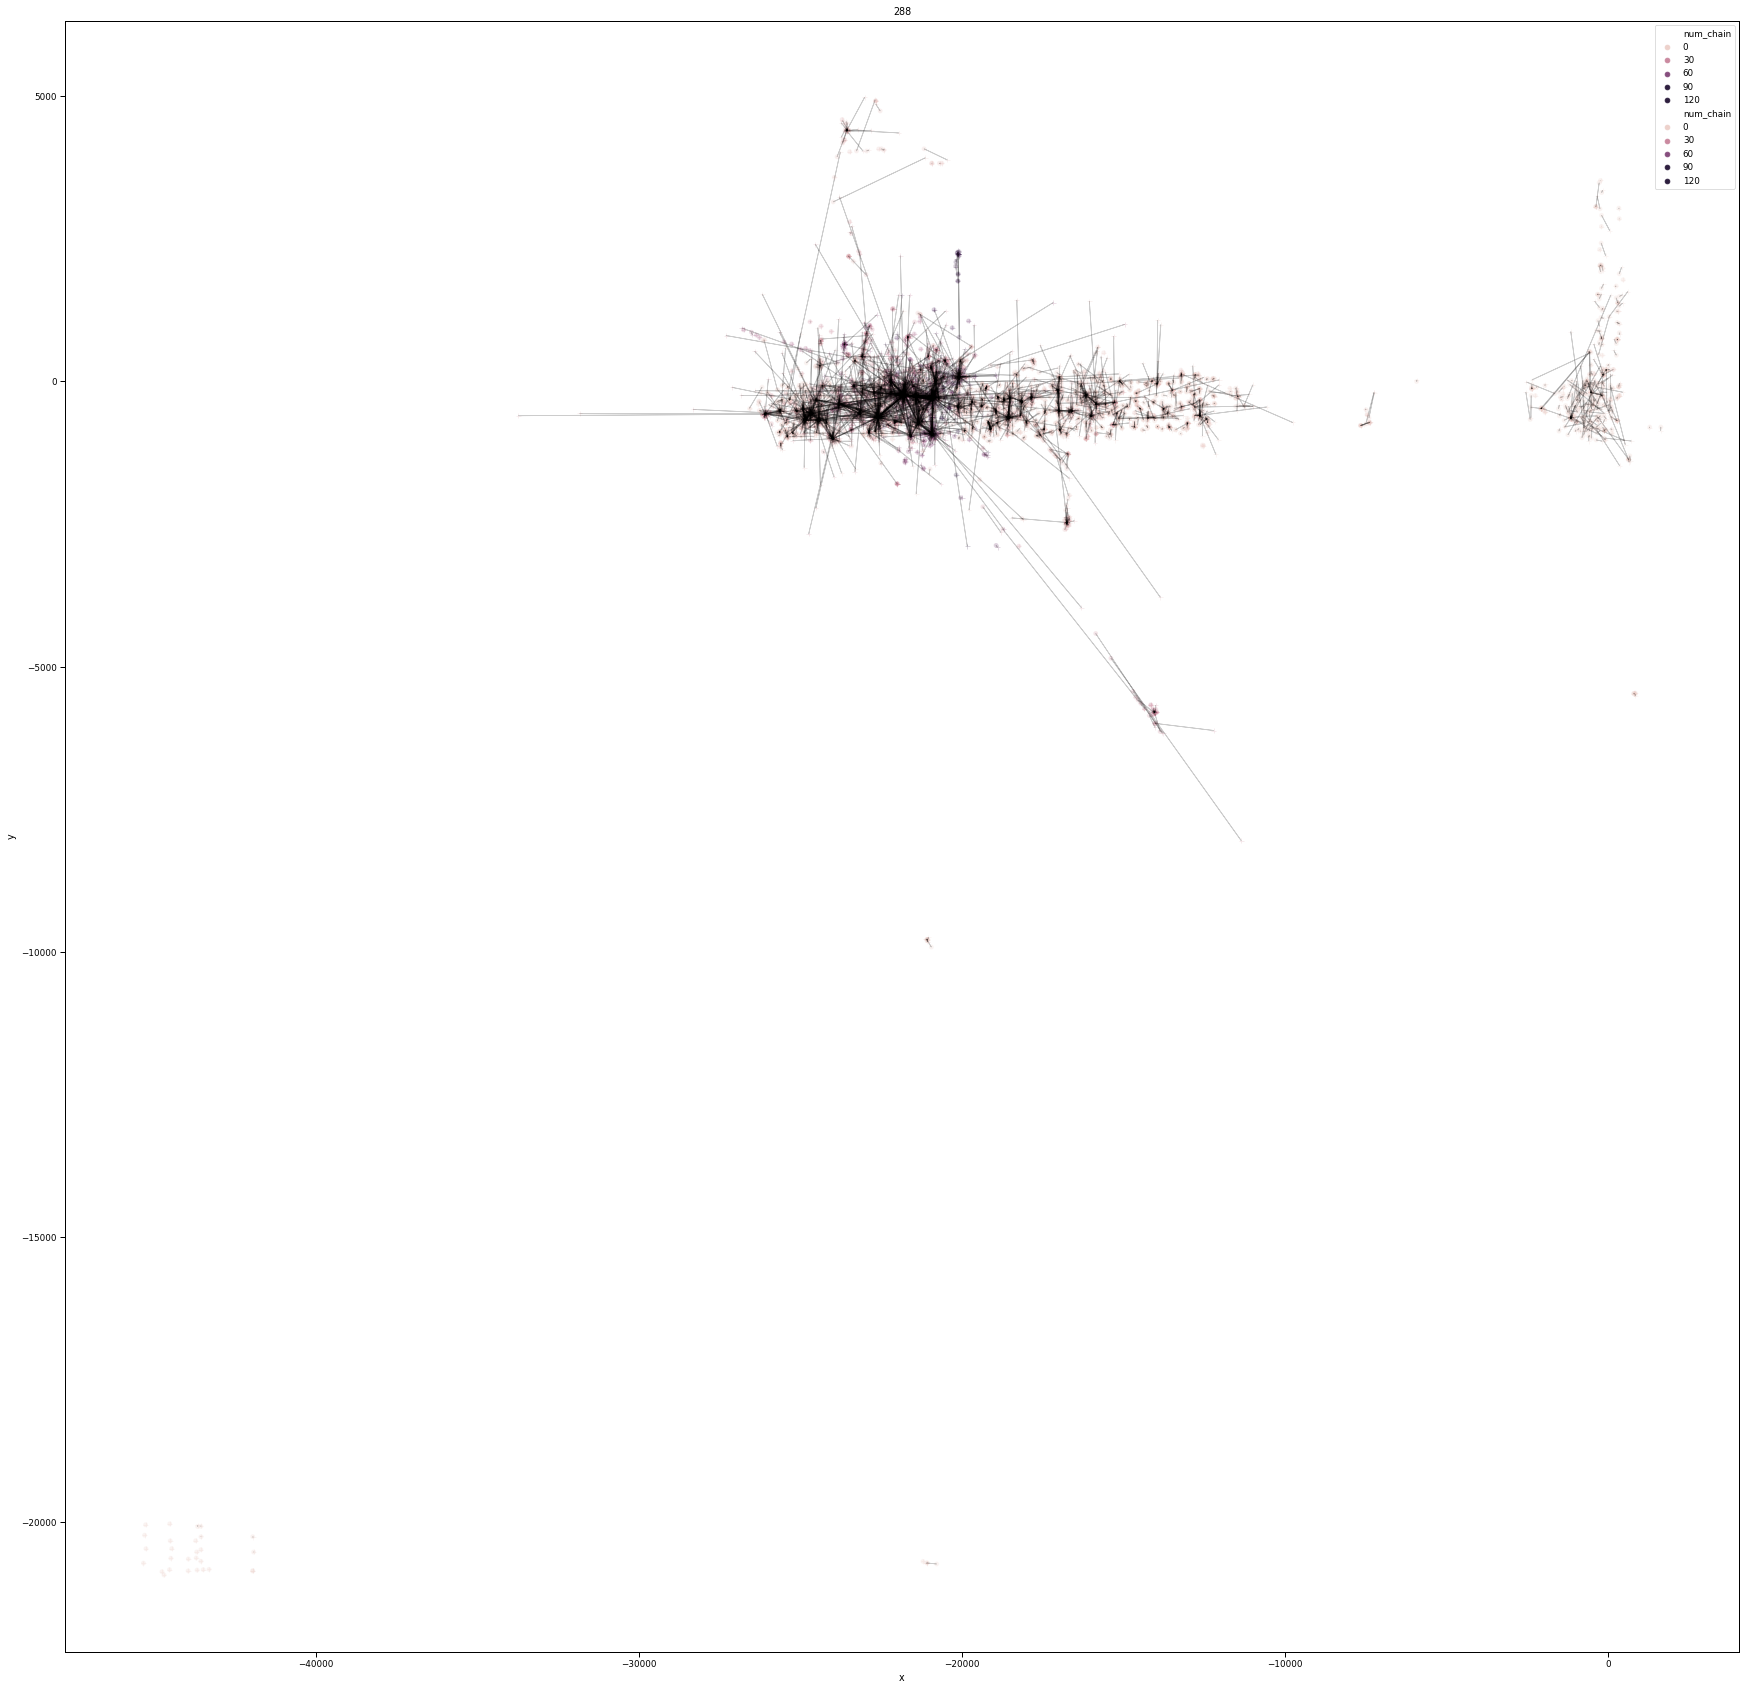

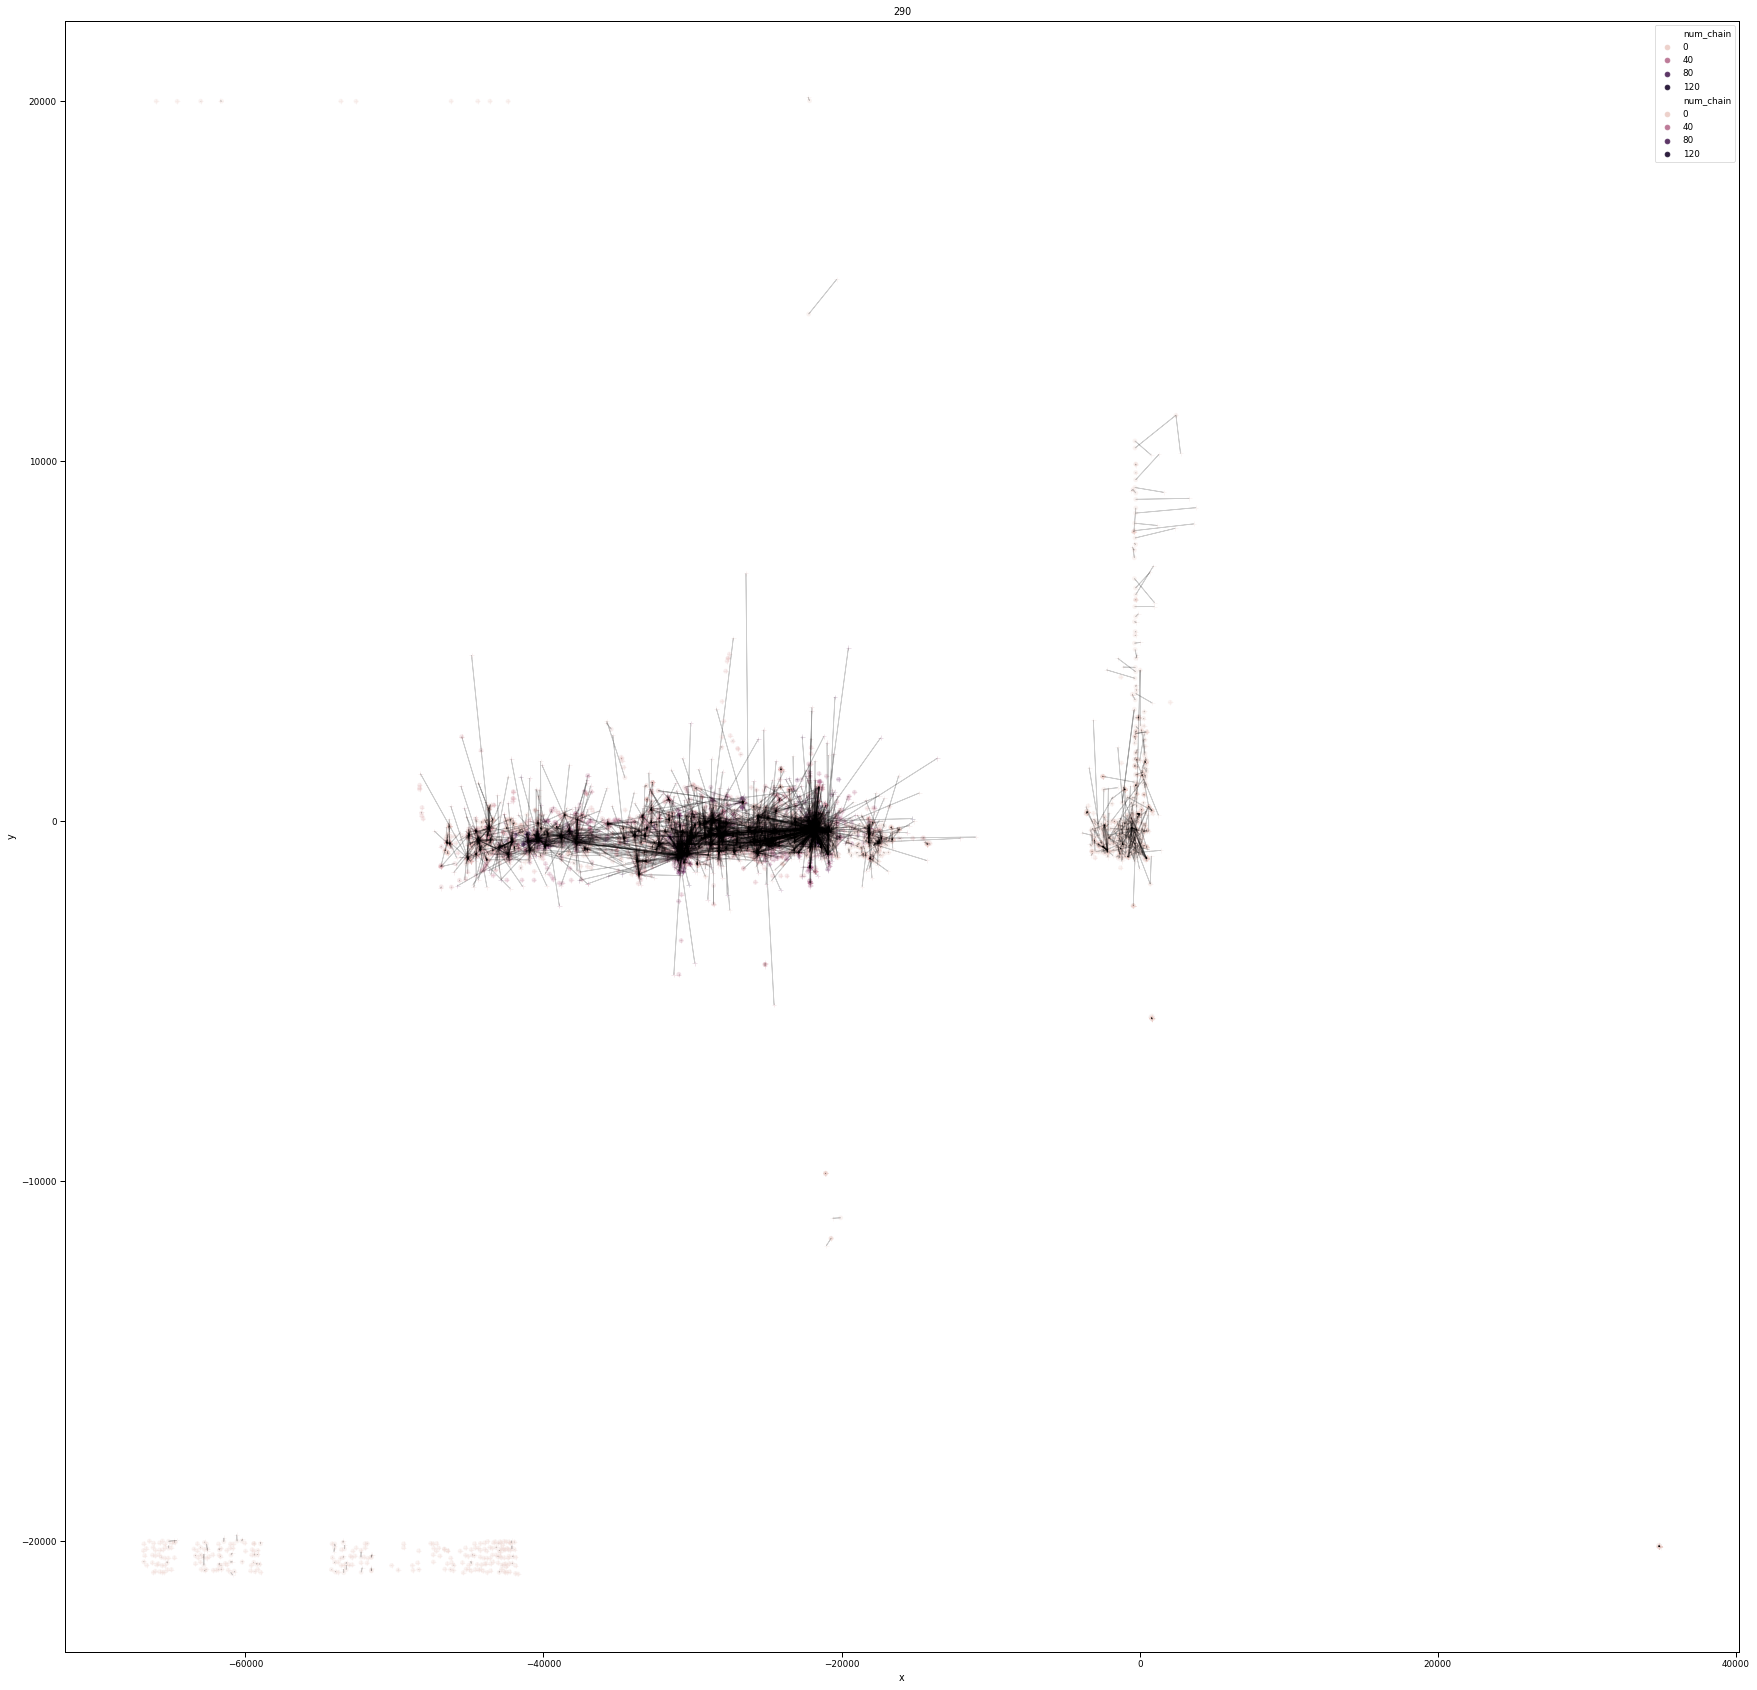

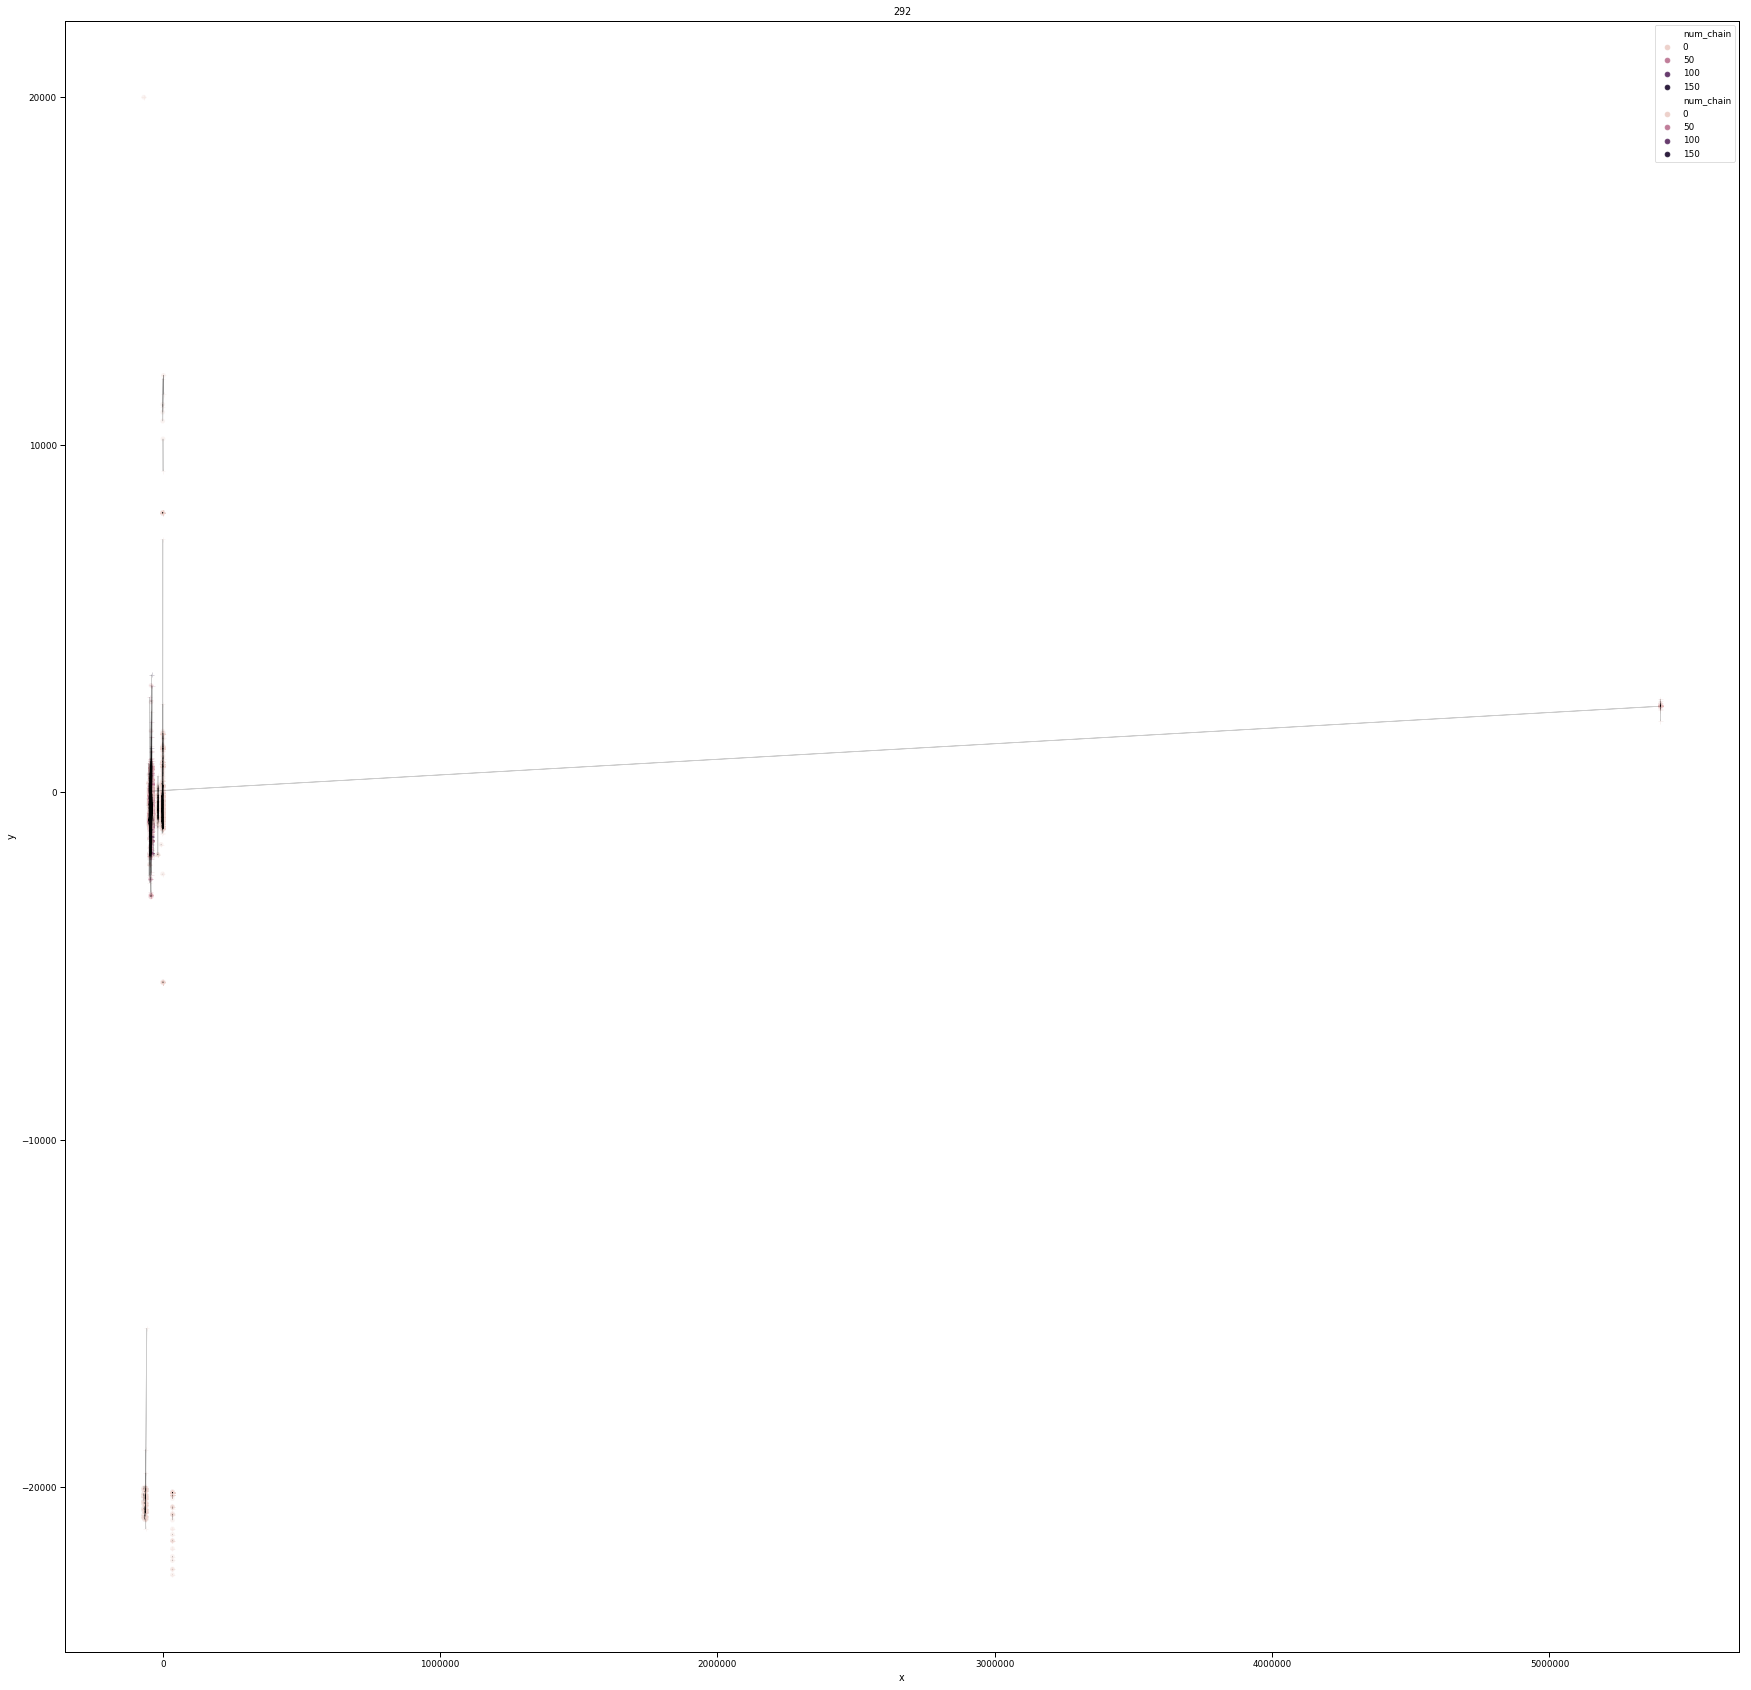

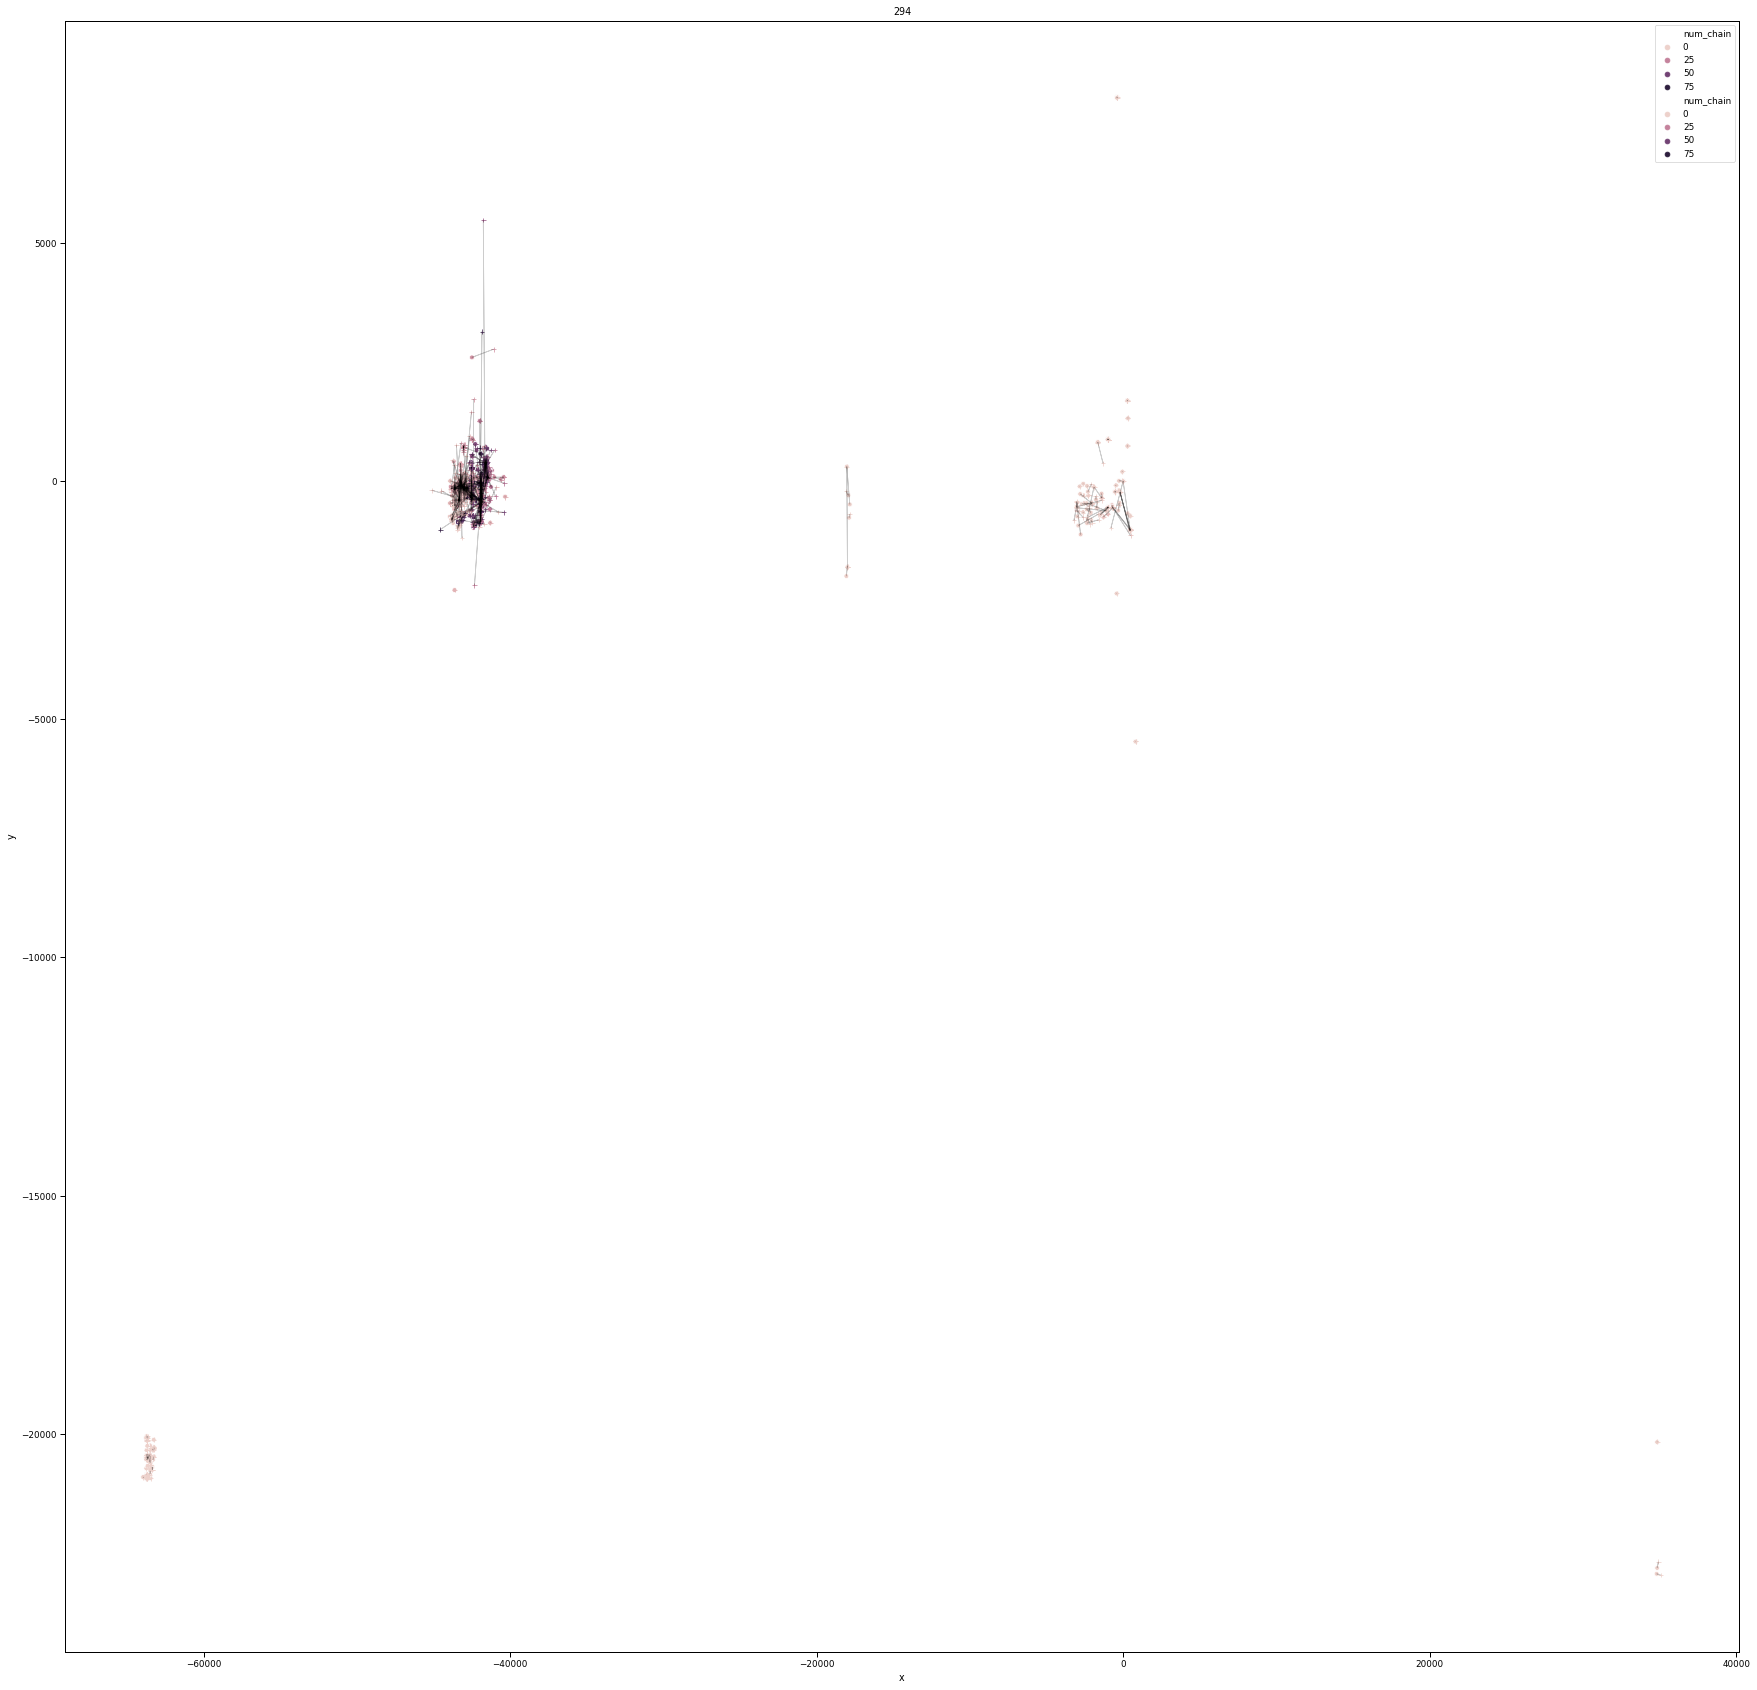

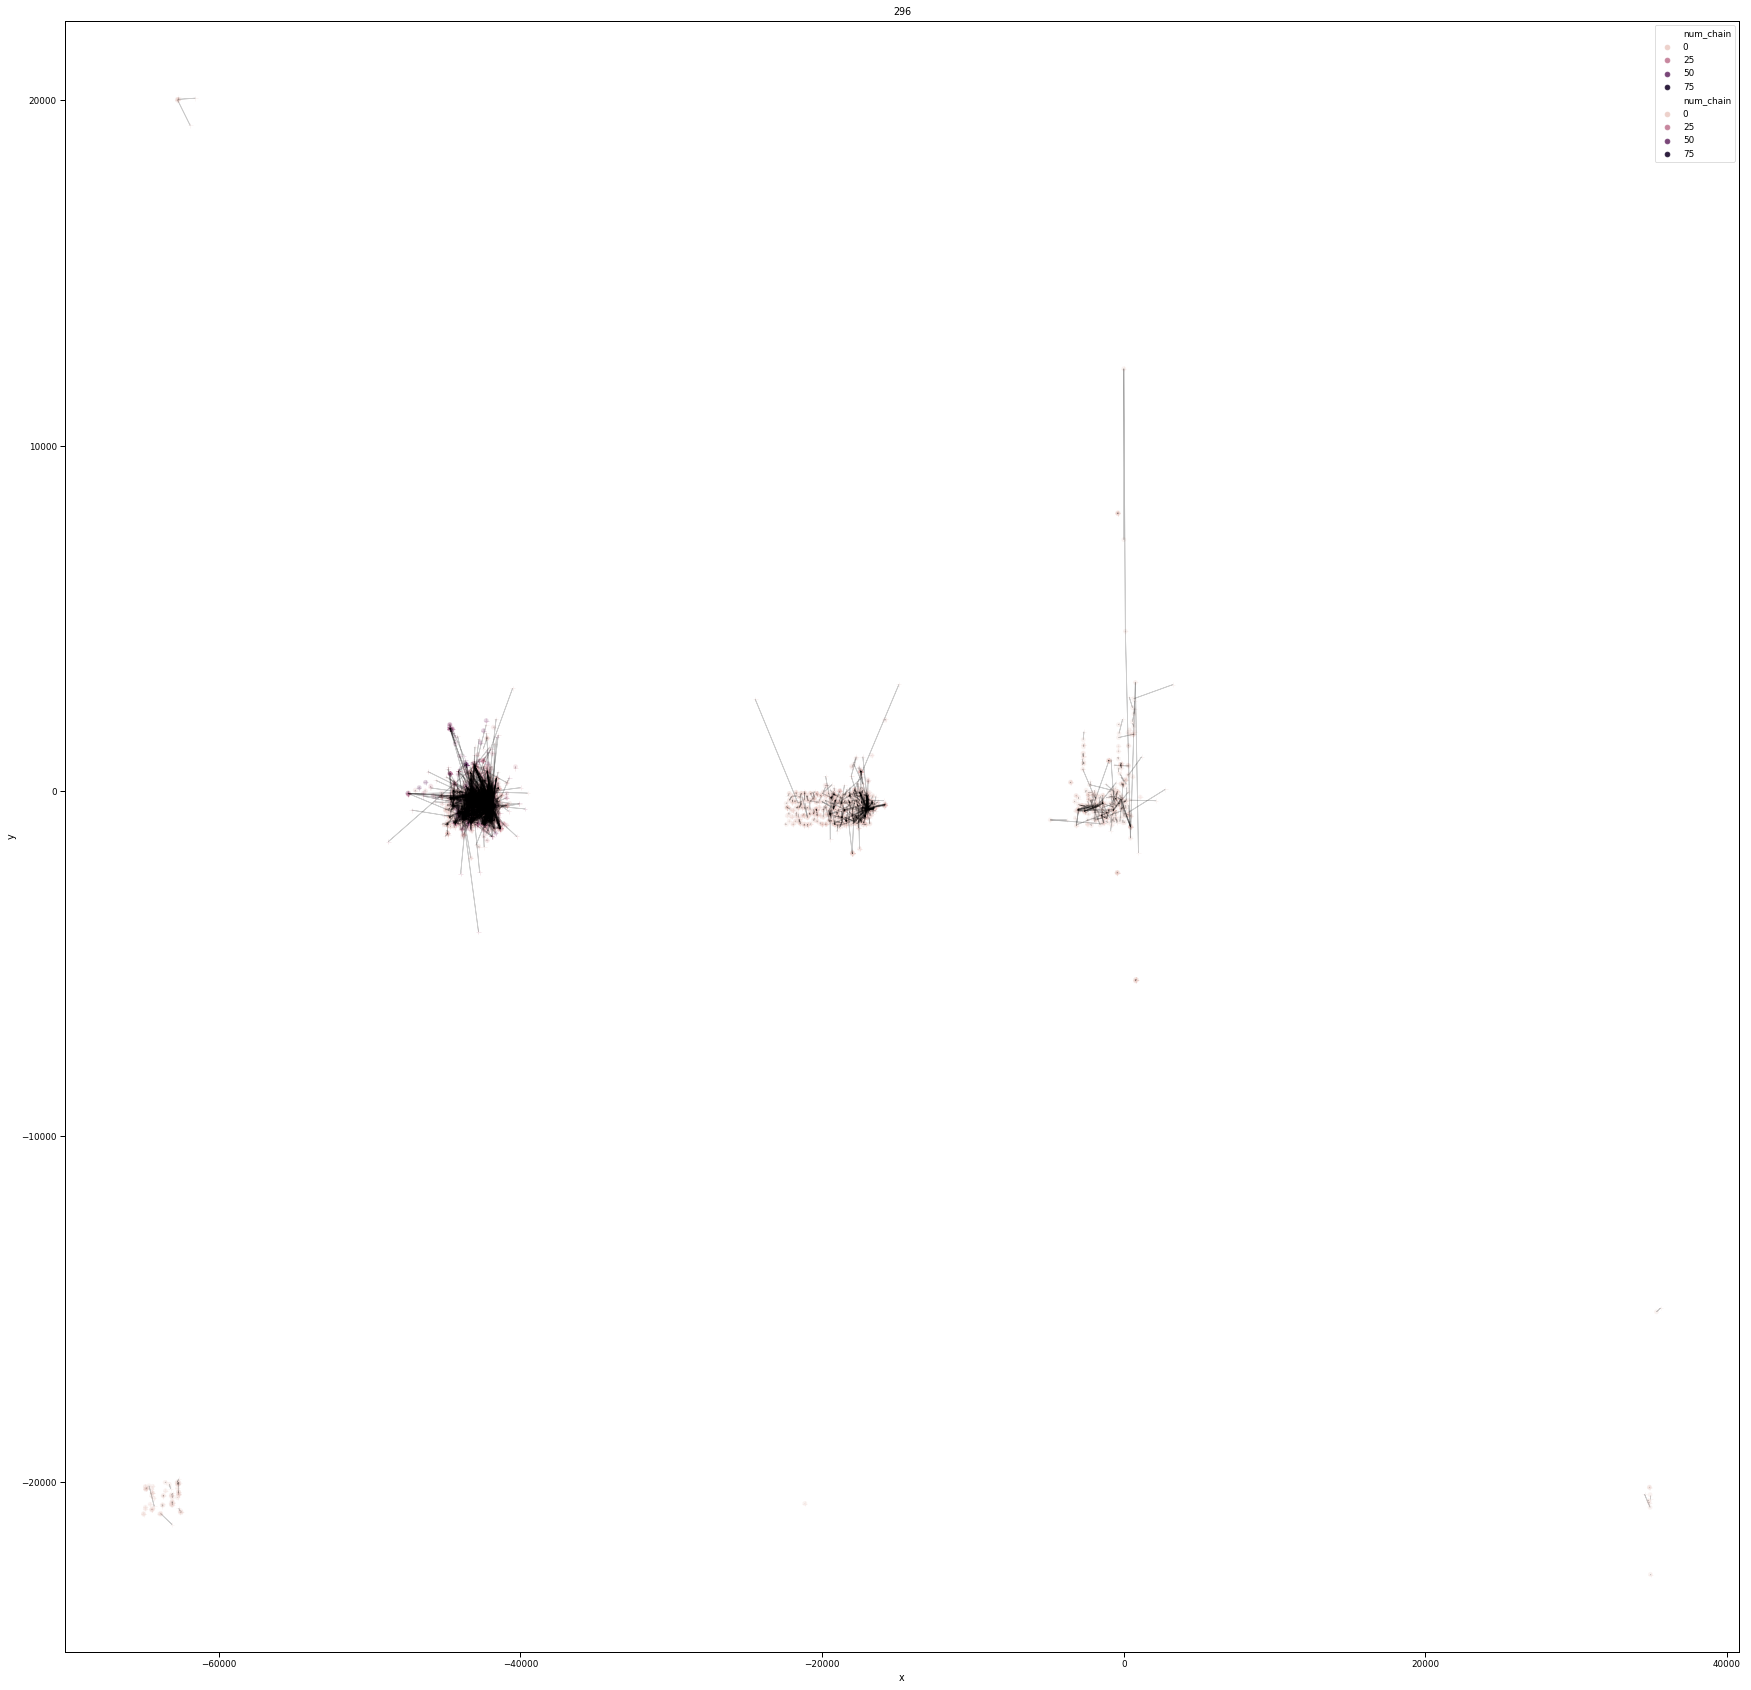

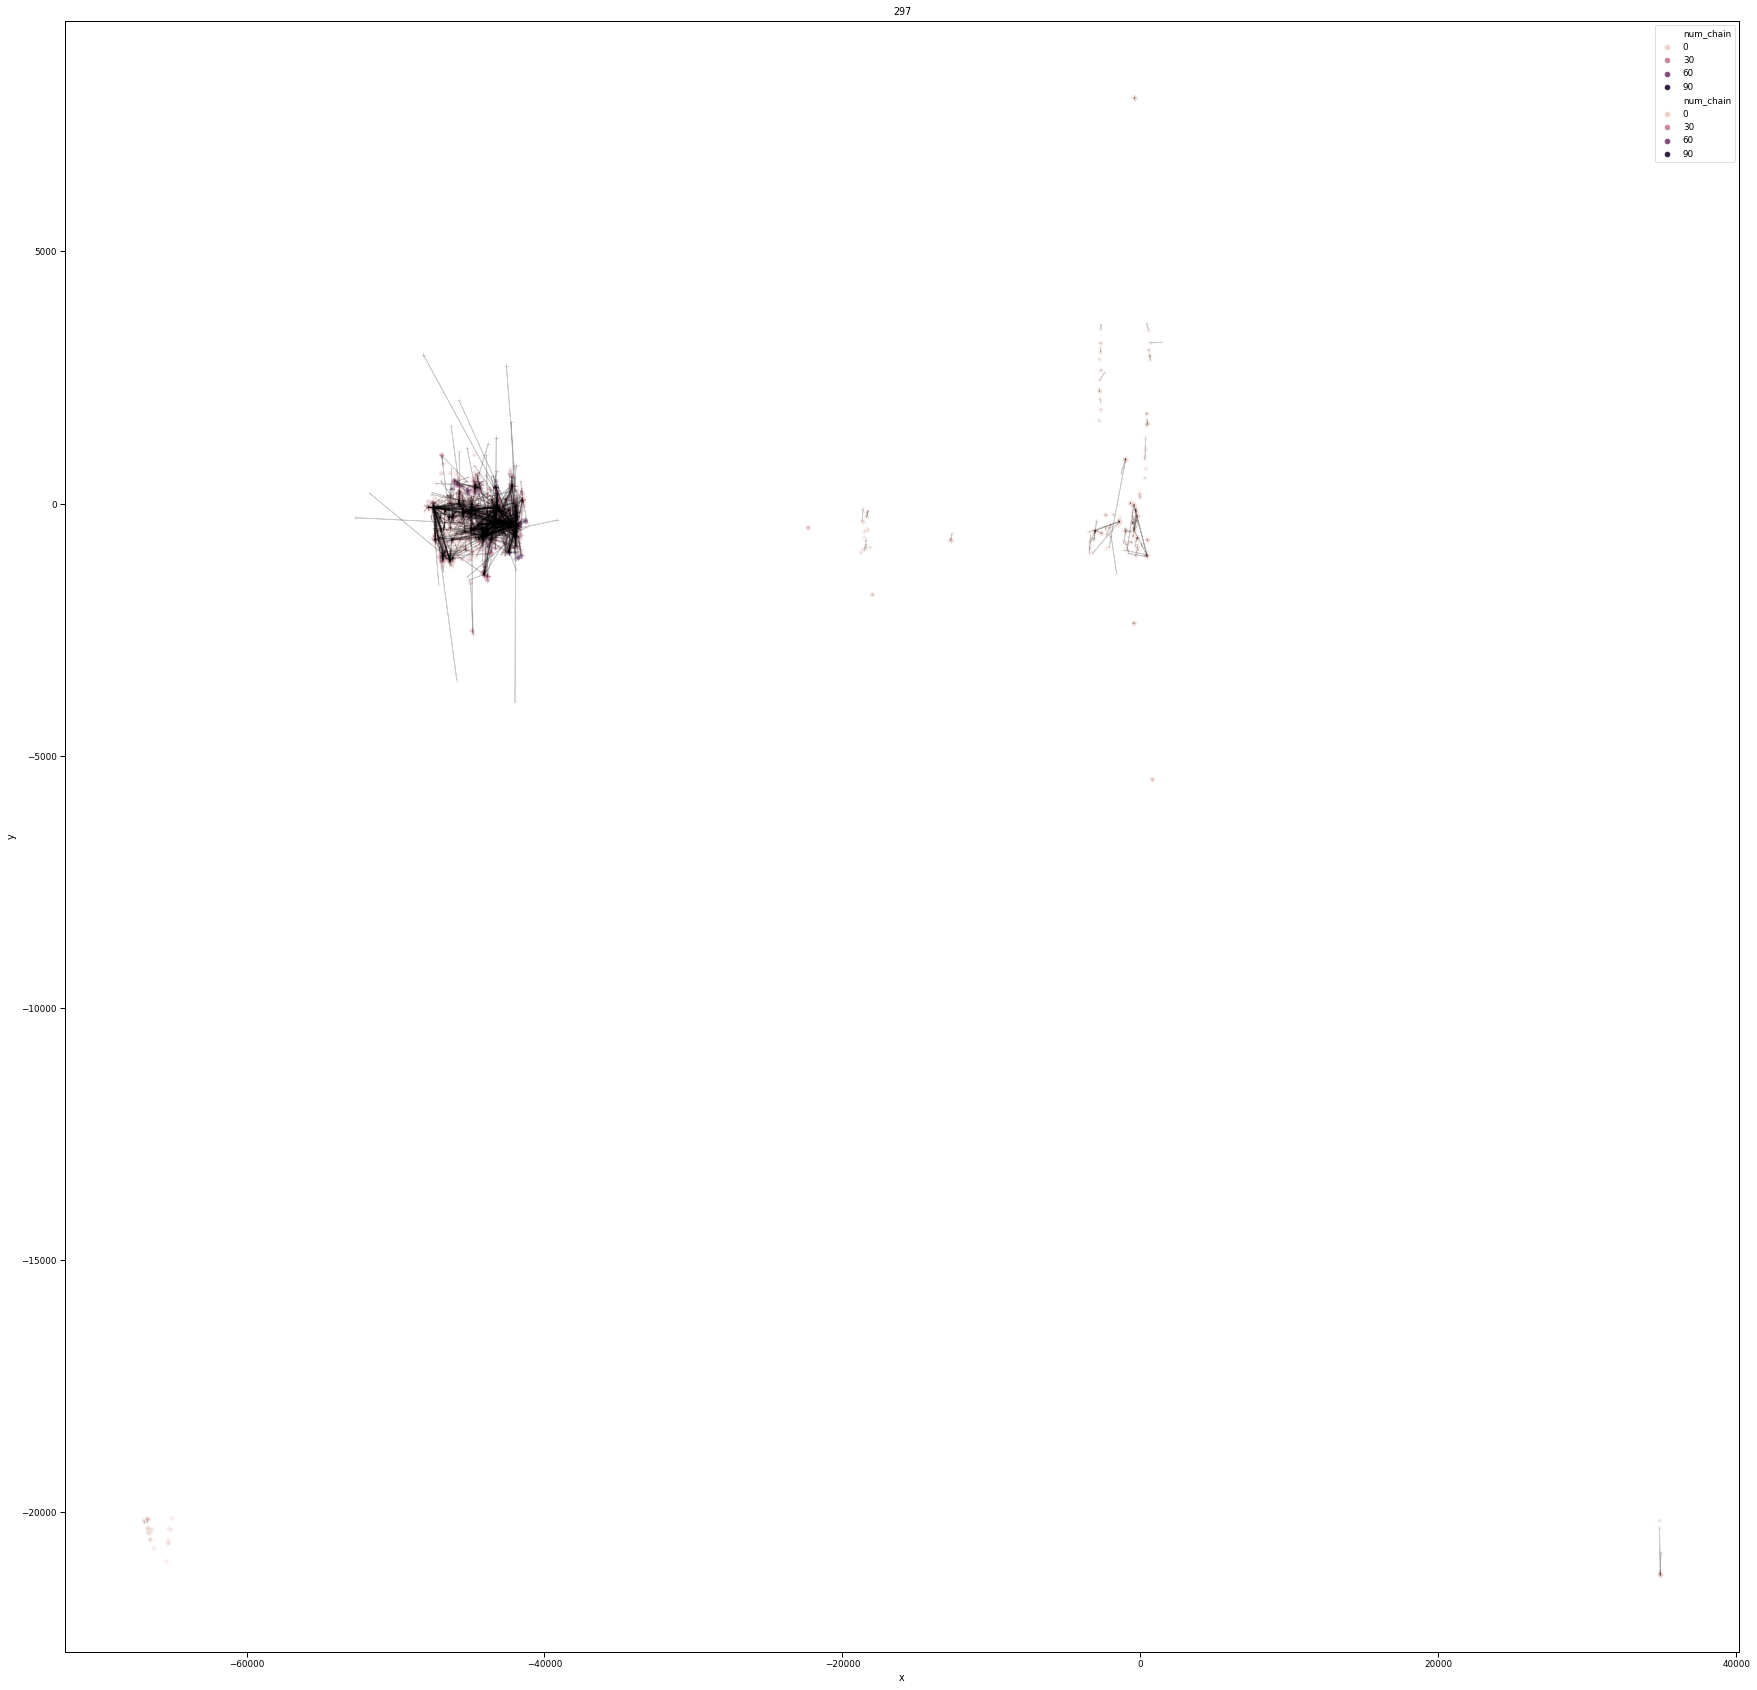

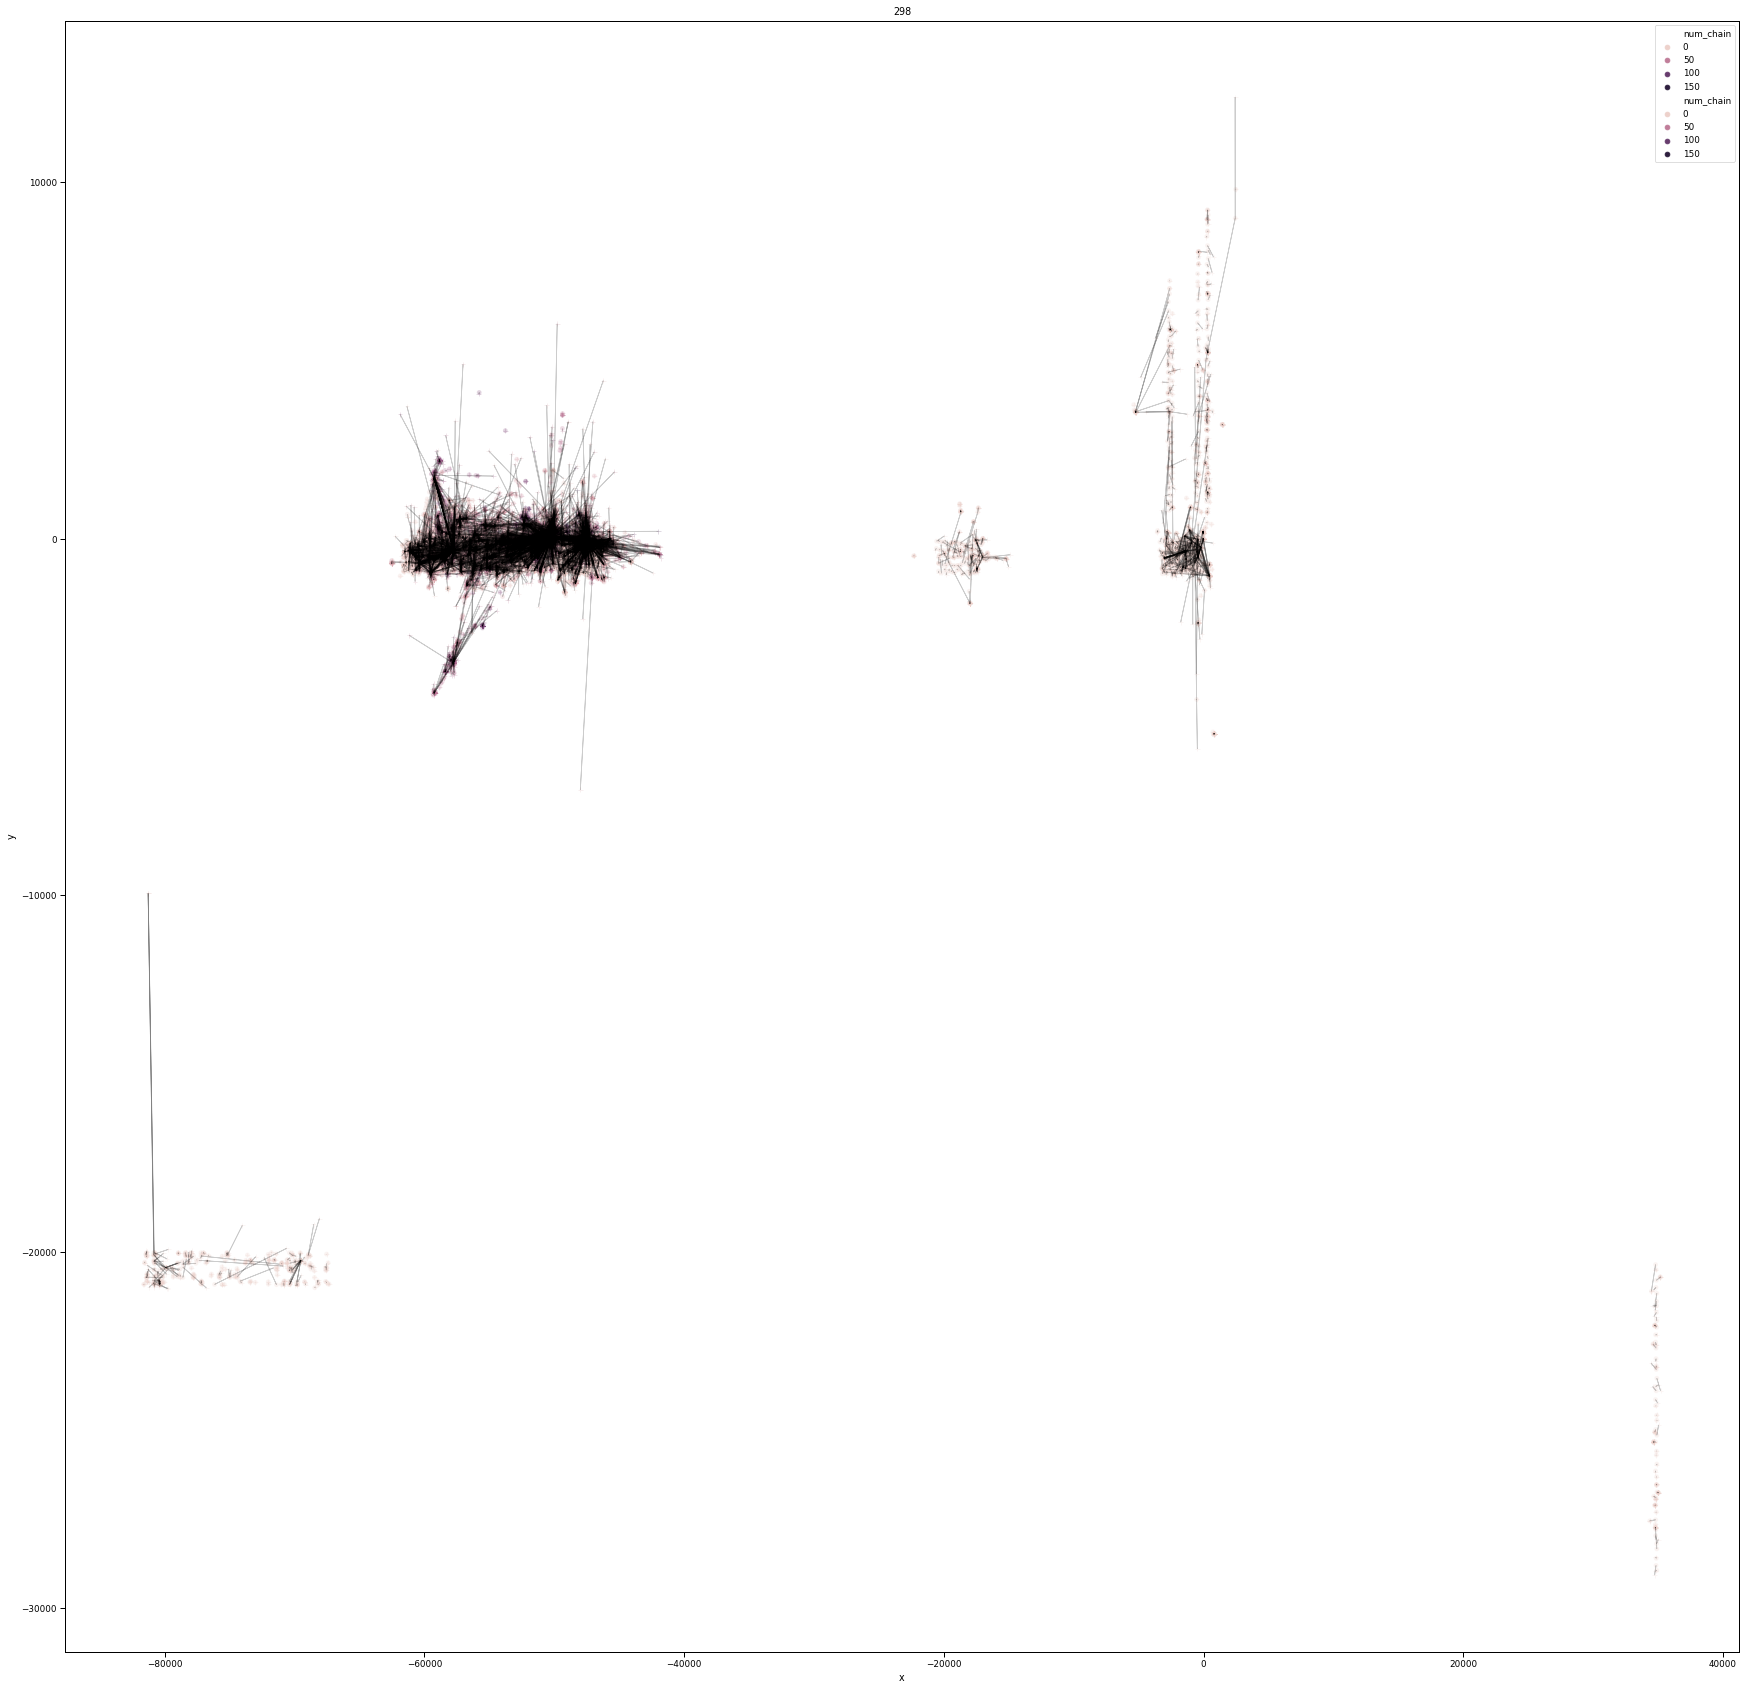

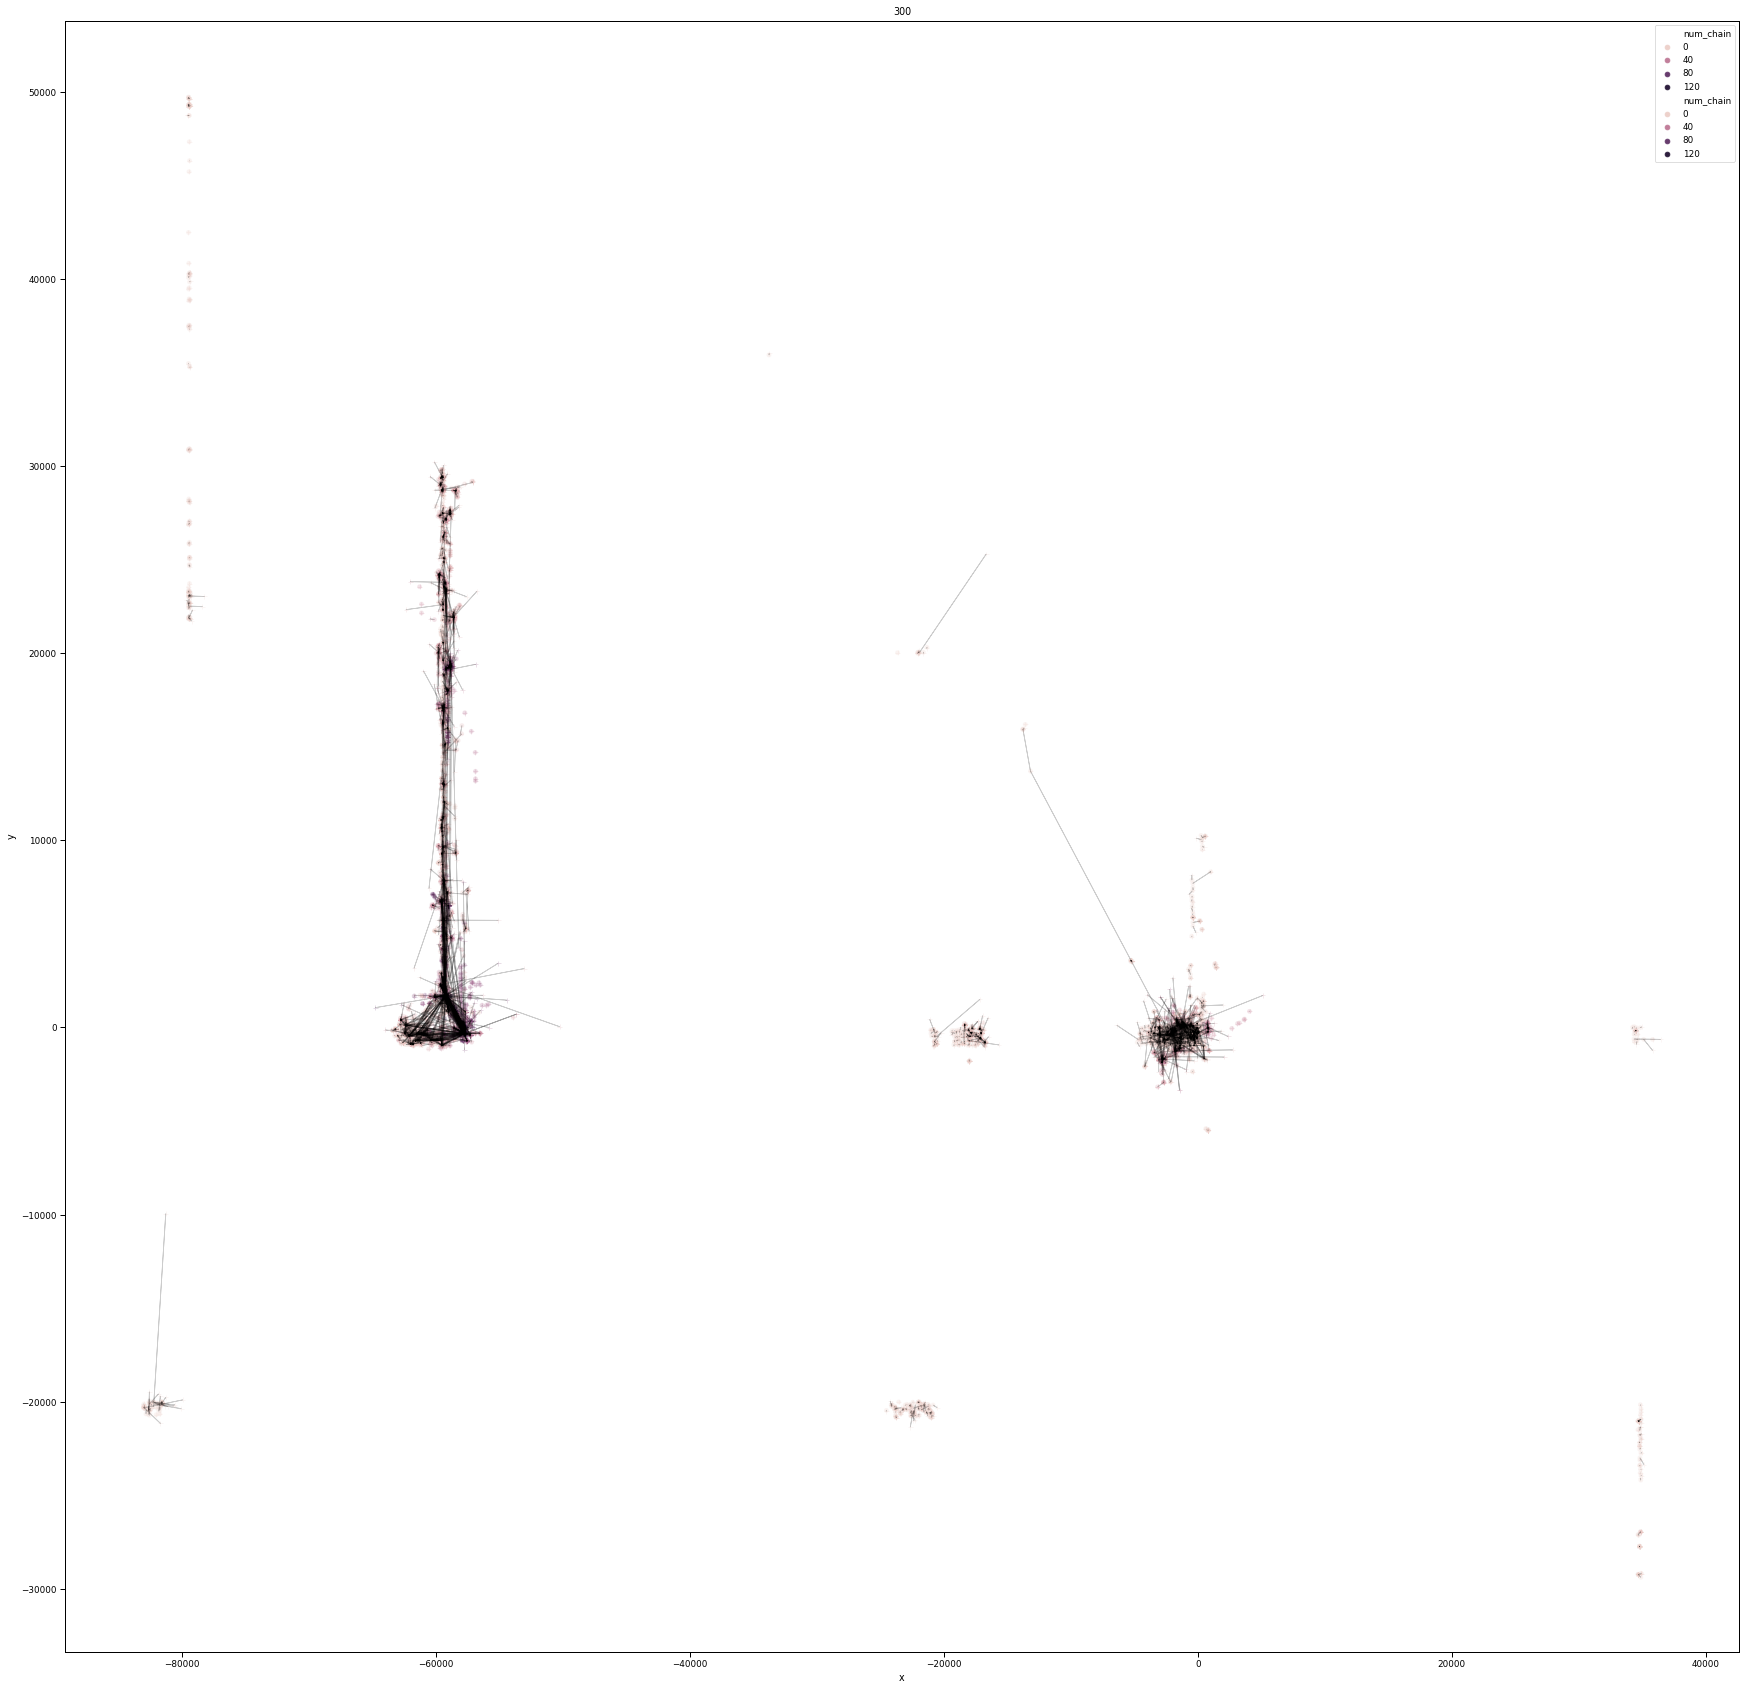

In [310]:
for s in np.arange(252,302):
    plot_individual_immigration(s)
    plt.show()

In [302]:
raw_data.query('playerID == "1833198"')

,release,server,event,timestamp,playerID,uniqueID,param1,param2,param3,param4,param5
9941,251,bigserver2,B,1564330976,1833198,e80f5de6e432383a17e542f36a1a53011553c4ee,F,"(200,238)",parent=1833124,pop=90,chain=5
10004,251,bigserver2,D,1564331424,1833198,e80f5de6e432383a17e542f36a1a53011553c4ee,age=7.46,F,"(188,247)",hunger,pop=94
